In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from pyproj import Proj

def get_date_subfolder():
    current_date = datetime.now()
    return current_date.strftime('%Y_%m_%d')

app_indv_csv_path = '/data/shared/src/STV/NEON_TEAK/allen/data/NEON_struct-plant/TEAK_appindv_allyears_2022.csv'
map_tag_csv_path = '/data/shared/src/STV/NEON_TEAK/allen/data/NEON_struct-plant/TEAK_maptag_allyears_2022.csv'
subplot_loc_csv_path = '/data/shared/src/STV/NEON_TEAK/allen/data/NEON_struct-plant/TEAK_subplotloc_allyears_2022.csv'

root_output_path = '/data/shared/src/STV/NEON_TEAK/allen/figs/veg_input/'
date_subfolder = get_date_subfolder()
date_output_path = os.path.join(root_output_path, date_subfolder)

app_indv = pd.read_csv(app_indv_csv_path)

# filter out saplings and keep stem diameter greater than 1cm
# Note:  I keep rows where 'growthForm' is NA because some rows have stemDiameter values, but this is later filtered out with the 2015 filter, because all of those records are of that year.
filtered_df = app_indv[(app_indv['growthForm'].str.contains('sapling') == False) | (pd.isna(app_indv['growthForm']))]
filtered_df = filtered_df[(filtered_df['stemDiameter'] > 0.1)]
filtered_df = filtered_df[filtered_df['plantStatus'].str.contains('Live')]
filtered_df = filtered_df[filtered_df['date'].str.contains('2015') == False]

# Ensure the full save path exists
os.makedirs(date_output_path, exist_ok=True)

filtered_df.to_csv(os.path.join(date_output_path, 'filtered_df.csv'))

FileNotFoundError: [Errno 2] No such file or directory: '/data/shared/src/STV/NEON_TEAK/allen/data/NEON_struct-plant/TEAK_appindv_allyears_2022.csv'

In [61]:
### This block tests how many records where height is not NA and maxCrownDiameter and ninetyCrownDiameter are NA

# There are exactly 2 rows that fit this condition

print(len(filtered_df))
filtered_df_test = filtered_df.dropna(subset=['height']).copy()
print(len(filtered_df_test))
filtered_df_test = filtered_df_test.dropna(subset=['maxCrownDiameter', 'ninetyCrownDiameter']).copy()
print(len(filtered_df_test))

1042
962
960


In [62]:
### This block will calculate the regression line that fits the data from x = height, y = crown_width

# Drop rows where height, maxCrownDiameter, ninetyCrownDiameter, are NA
filtered_df_calc_reg = filtered_df.dropna(subset=['height', 'maxCrownDiameter', 'ninetyCrownDiameter']).copy()

# Perform calculations and create new columns in filtered_df_calc_reg
filtered_df_calc_reg['crown_radius'] = (filtered_df_calc_reg['maxCrownDiameter'] + filtered_df_calc_reg["ninetyCrownDiameter"]) / 4
filtered_df_calc_reg['crown_width'] = filtered_df_calc_reg['crown_radius'] * 2

# Perform regression
x = filtered_df_calc_reg['height'].values
y = filtered_df_calc_reg['crown_width'].values

log_x = np.log10(x)
log_y = np.log10(y)

coefficients = np.polyfit(log_x, log_y, 1)
b, a = coefficients

print(f"The regression formula is: y = (10^{a:.4f}) * (x^{b:.4f})")

The regression formula is: y = (10^-0.0556) * (x^0.5448)


In [63]:
# set new crown diameter (width) values according to calculated quadratic regression formula based on height (for exactly 2 records)
def exponential_func(x):
    return (10**-0.0556) * (x**0.5448)

# If the row at tested column is NA, then generate values
for plot_index, loc_row in filtered_df.iterrows():
    if pd.isna(loc_row['maxCrownDiameter']):
        filtered_df.at[plot_index, 'maxCrownDiameter'] = exponential_func(loc_row['height'])
    if pd.isna(loc_row['ninetyCrownDiameter']):
        filtered_df.at[plot_index, 'ninetyCrownDiameter'] = exponential_func(loc_row['height'])
    if pd.isna(loc_row['baseCrownHeight']):
        filtered_df.at[plot_index, 'baseCrownHeight'] = loc_row['height'] * 0.2

# set new values and ratios
filtered_df['crown_radius'] = (filtered_df['maxCrownDiameter'] + filtered_df["ninetyCrownDiameter"])/4
filtered_df ['crown_width'] = (filtered_df ['crown_radius'] * 2)
filtered_df ['crown_depth'] = filtered_df ['height'] - filtered_df ['baseCrownHeight']
filtered_df ['crown_width/h'] = filtered_df ['crown_width'] / filtered_df ['height']
filtered_df ['crown_depth/h'] = filtered_df ['crown_depth'] / filtered_df ['height']
filtered_df ['crown_depth/crown_width'] = filtered_df ['crown_depth'] / filtered_df ['crown_width']

# Assigns separate dataframes for _100 and _400
shrub_stem_nona_df = filtered_df.dropna(subset=['stemDiameter'])
shrub_stem_nona_df = shrub_stem_nona_df.sort_values(by=['individualID', 'date'])
shrub_stem_nona_df = shrub_stem_nona_df.drop_duplicates(subset='individualID', keep='last')
shrub_stem_nona_100_df = shrub_stem_nona_df[shrub_stem_nona_df['subplotID'].str.contains('_100')]
shrub_stem_nona_400_df = shrub_stem_nona_df[shrub_stem_nona_df['subplotID'].str.contains('_400')]
shrub_stem_nona_100_df = shrub_stem_nona_100_df.sort_values(by='plotID')
shrub_stem_nona_400_df = shrub_stem_nona_400_df.sort_values(by='plotID')

shrub_height_nona_df = filtered_df.dropna(subset=['height'])
shrub_height_nona_df = shrub_height_nona_df.sort_values(by=['individualID', 'date'])
shrub_height_nona_df = shrub_height_nona_df.drop_duplicates(subset='individualID', keep='last')
shrub_height_nona_100_df = shrub_height_nona_df[shrub_height_nona_df['subplotID'].str.contains('_100')]
shrub_height_nona_400_df = shrub_height_nona_df[shrub_height_nona_df['subplotID'].str.contains('_400')]
shrub_height_nona_100_df = shrub_height_nona_100_df.sort_values(by='plotID')
shrub_height_nona_400_df = shrub_height_nona_400_df.sort_values(by='plotID')

# noshrub dataframes
noshrub_df = filtered_df[(filtered_df['growthForm'].str.contains('shrub') == False) | (pd.isna(filtered_df['growthForm']))]
noshrub_df = noshrub_df.sort_values(by=['individualID', 'date'])
noshrub_df = noshrub_df.drop_duplicates(subset='individualID', keep='last')
noshrub_100_df = noshrub_df[noshrub_df['subplotID'].str.contains('_100')]
noshrub_400_df = noshrub_df[noshrub_df['subplotID'].str.contains('_400')]

noshrub_stem_nona_df = noshrub_df.dropna(subset=['stemDiameter'])
noshrub_stem_nona_df = noshrub_stem_nona_df.sort_values(by=['individualID', 'date'])
noshrub_stem_nona_df = noshrub_stem_nona_df.drop_duplicates(subset='individualID', keep='last')

noshrub_stem_nona_df['subplotID'] = noshrub_stem_nona_df['subplotID'].astype(str)
noshrub_stem_nona_100_df = noshrub_stem_nona_df[noshrub_stem_nona_df['subplotID'].str.contains('_100') == True]
noshrub_stem_nona_400_df = noshrub_stem_nona_df[noshrub_stem_nona_df['subplotID'].str.contains('_400') == True]
noshrub_stem_nona_100_df = noshrub_stem_nona_100_df.sort_values(by='plotID')
noshrub_stem_nona_400_df = noshrub_stem_nona_400_df.sort_values(by='plotID')

noshrub_height_nona_df = noshrub_df.dropna(subset=['height'])
noshrub_height_nona_df = noshrub_height_nona_df.sort_values(by=['individualID', 'date'])
noshrub_height_nona_df = noshrub_height_nona_df.drop_duplicates(subset='individualID', keep='last')
noshrub_height_nona_100_df = noshrub_height_nona_df[noshrub_height_nona_df['subplotID'].str.contains('_100')]
noshrub_height_nona_400_df = noshrub_height_nona_df[noshrub_height_nona_df['subplotID'].str.contains('_400')]
noshrub_height_nona_100_df = noshrub_height_nona_100_df.sort_values(by='plotID')
noshrub_height_nona_400_df = noshrub_height_nona_400_df.sort_values(by='plotID')

noshrub_stem_height_nona_df = noshrub_df.dropna(subset=['stemDiameter'])
noshrub_stem_height_nona_df = noshrub_stem_height_nona_df.dropna(subset=['height'])

# print(len(noshrub_stem_nona_df))
# pd.set_option('display.expand_frame_repr', False)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(noshrub_stem_nona_100_df[['individualID','plotID', 'date', 'subplotID', 'growthForm', 'maxCrownDiameter', 'crown_depth', 'height']])

In [81]:
def get_date_subfolder():
    current_date = datetime.now()
    return current_date.strftime('%Y_%m_%d')

def plot_tree_data_relationships(df, save_path, plot_type):

    # Set up subplots
    figs, axs = plt.subplots(1, 4, figsize=(35, 16))
    
    # Extract relevant data
    df = df.sort_values(by='height')
    
    # Extract the data needed for plots
    x_existing = df['height']
    y_existing_crown_width = df['crown_width']
    y_existing_crown_depth = df['crown_depth']
    y_existing_stem_diameter = df['stemDiameter']
    y_existing_crown_ratio = df['crown_width/h']

    # Exponential Regression Line for Crown Width and Height
    def exponential_func(x, a, b):
        return (10 ** a) * (x ** b)
    
    popt, _ = curve_fit(exponential_func, x_existing, y_existing_crown_width)
    a, b = popt
    
    print(f"The regression formula is: y = (10^{a:.4f}) * (x^{b:.4f})")
    
    y_pred = exponential_func(x_existing, *popt)
    
    # Calculate R2 and RMSE
    r2 = r2_score(y_existing_crown_width, y_pred)
    rmse = np.sqrt(mean_squared_error(y_existing_crown_width, y_pred))

    # Plot 1: Crown Width vs Height
    axs[0].scatter(x_existing, y_existing_crown_width)
    axs[0].plot(x_existing, y_pred, color='red', label=f"y = 10^{a:.2f} * x^{b:.2f} \n with R\u00B2 = {r2:.4f} and RMSE = {rmse:.4f}")
    axs[0].set_title(f'Crown width and height relation\n for {plot_type} m\u00B2 plots')
    axs[0].set_xlabel('Tree Height (m)')
    axs[0].set_ylabel('Crown Width (m)')
    axs[0].legend(fontsize='18')
    
    # Plot 2: Crown Depth vs Height
    axs[1].scatter(x_existing, y_existing_crown_depth)
    axs[1].set_title(f'Crown depth and height relation (with shrubs)\n for {plot_type} m\u00B2 plots')
    axs[1].set_xlabel('Tree Height (m)')
    axs[1].set_ylabel('Crown Depth (m)')
    
    # Plot 3: DBH vs Height
    axs[2].scatter(x_existing, y_existing_stem_diameter)
    axs[2].set_title(f'DBH and height relation\n for {plot_type} m\u00B2 plots')
    axs[2].set_xlabel('Tree Height (m)')
    axs[2].set_ylabel('DBH (in)')
    
    # Plot 4: Crown Width/Height Ratio vs Height
    axs[3].scatter(x_existing, y_existing_crown_ratio)
    axs[3].set_title(f'Crown Width to height ratio and height relation\n for {plot_type} m\u00B2 plots')
    axs[3].set_xlabel('Tree Height (m)')
    axs[3].set_ylabel('Crown Width (m)/Height')
    
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(os.path.join(save_path, f'TEAK_{plot_type}_height_relations.png'))
    plt.show()

The regression formula is: y = (10^-0.1062) * (x^0.6377)


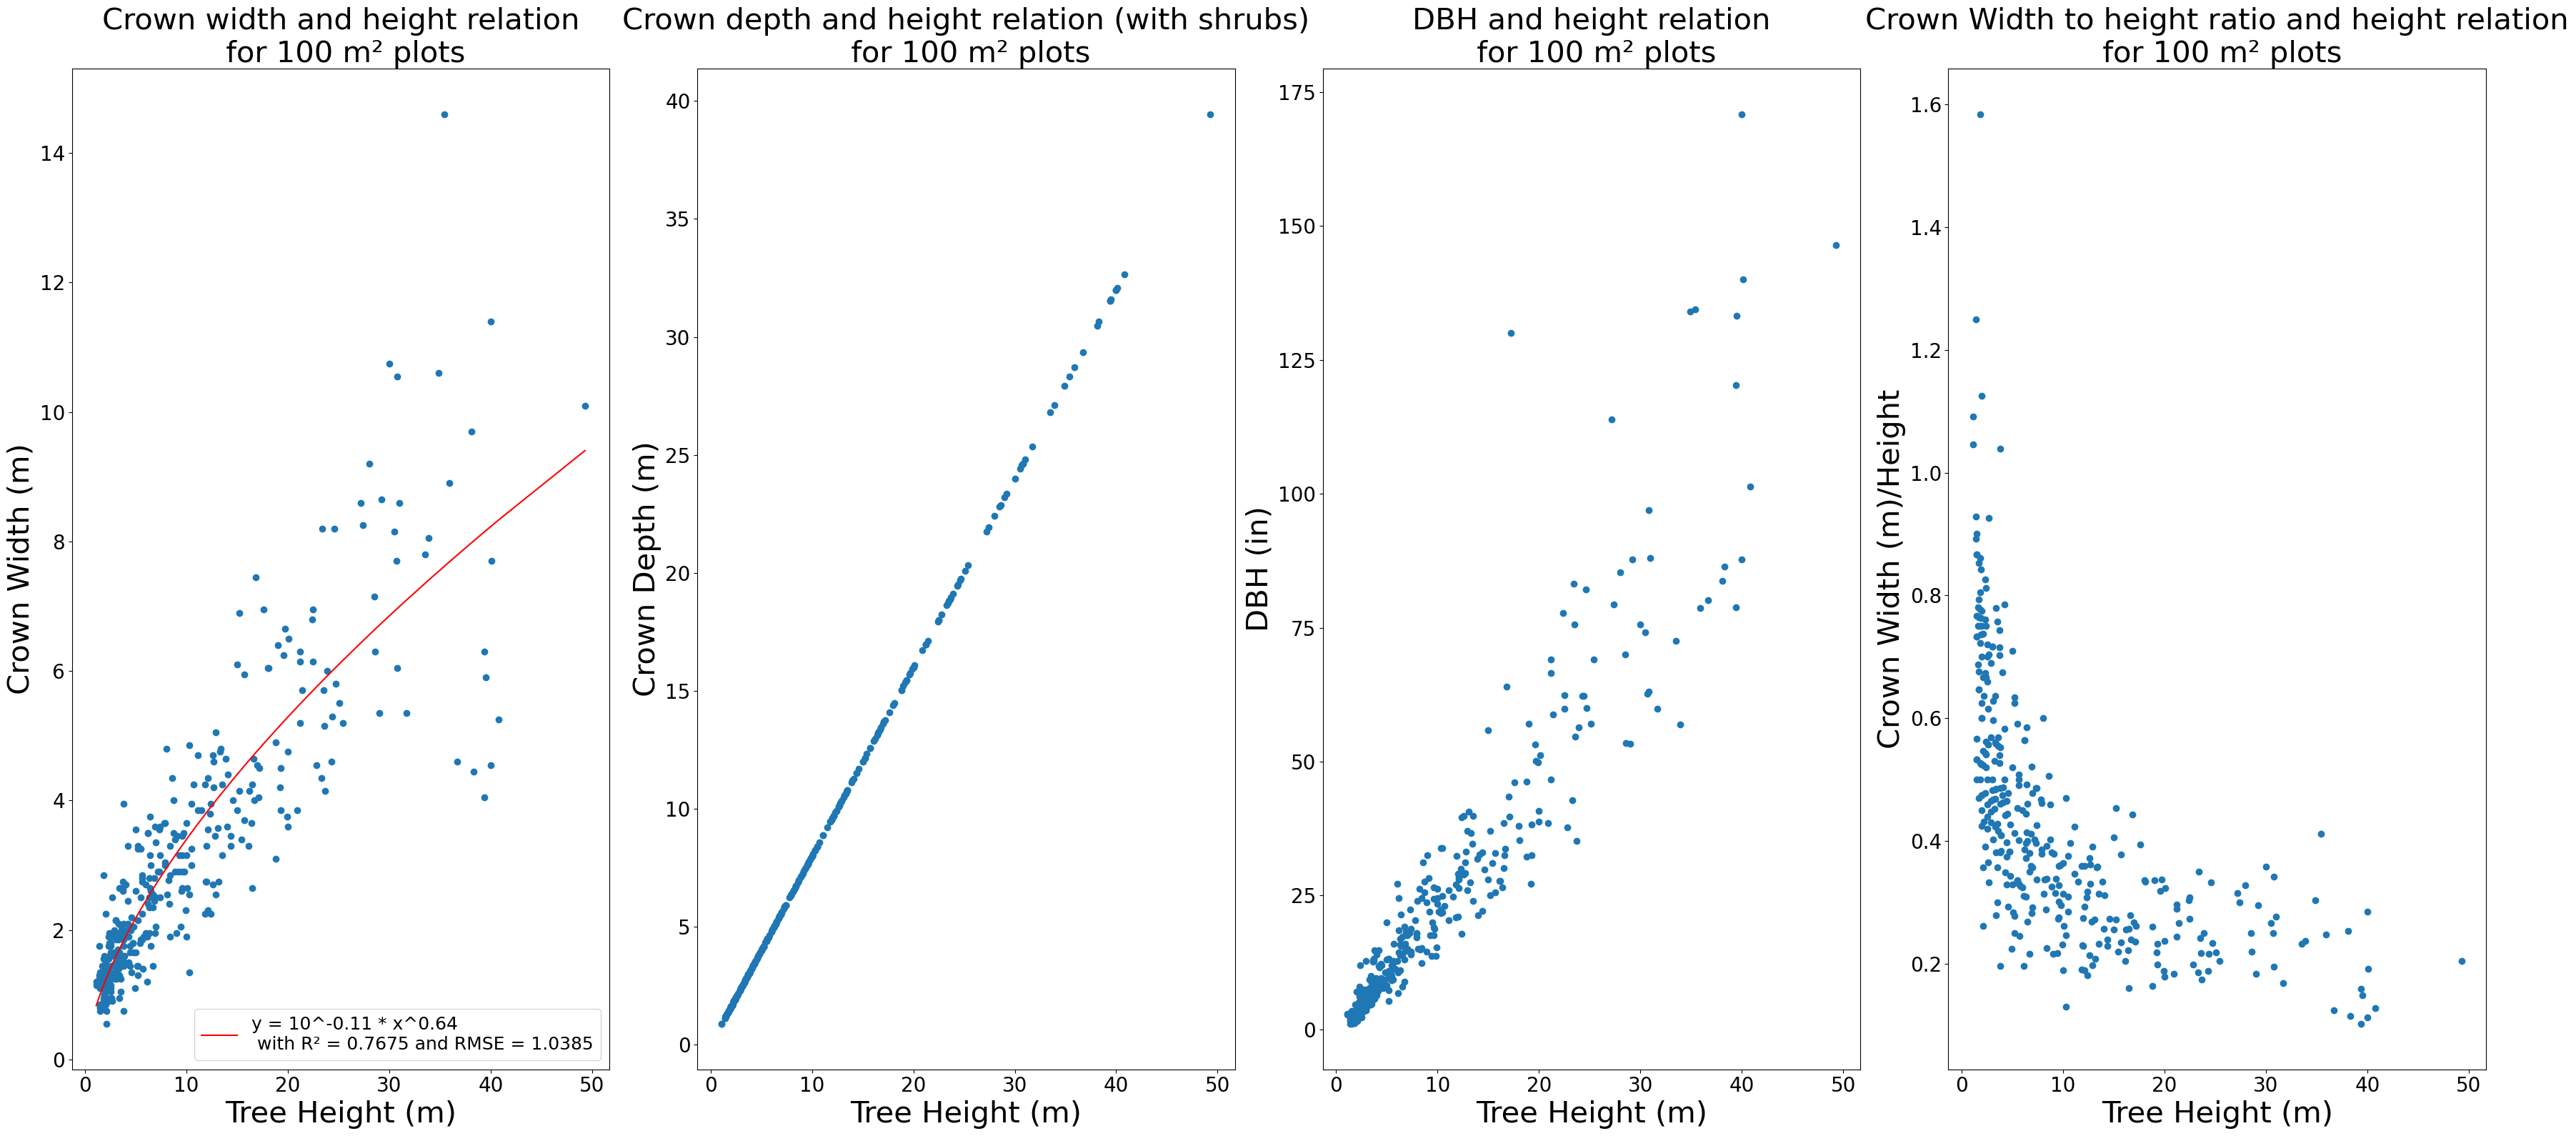

The regression formula is: y = (10^-0.0596) * (x^0.5526)


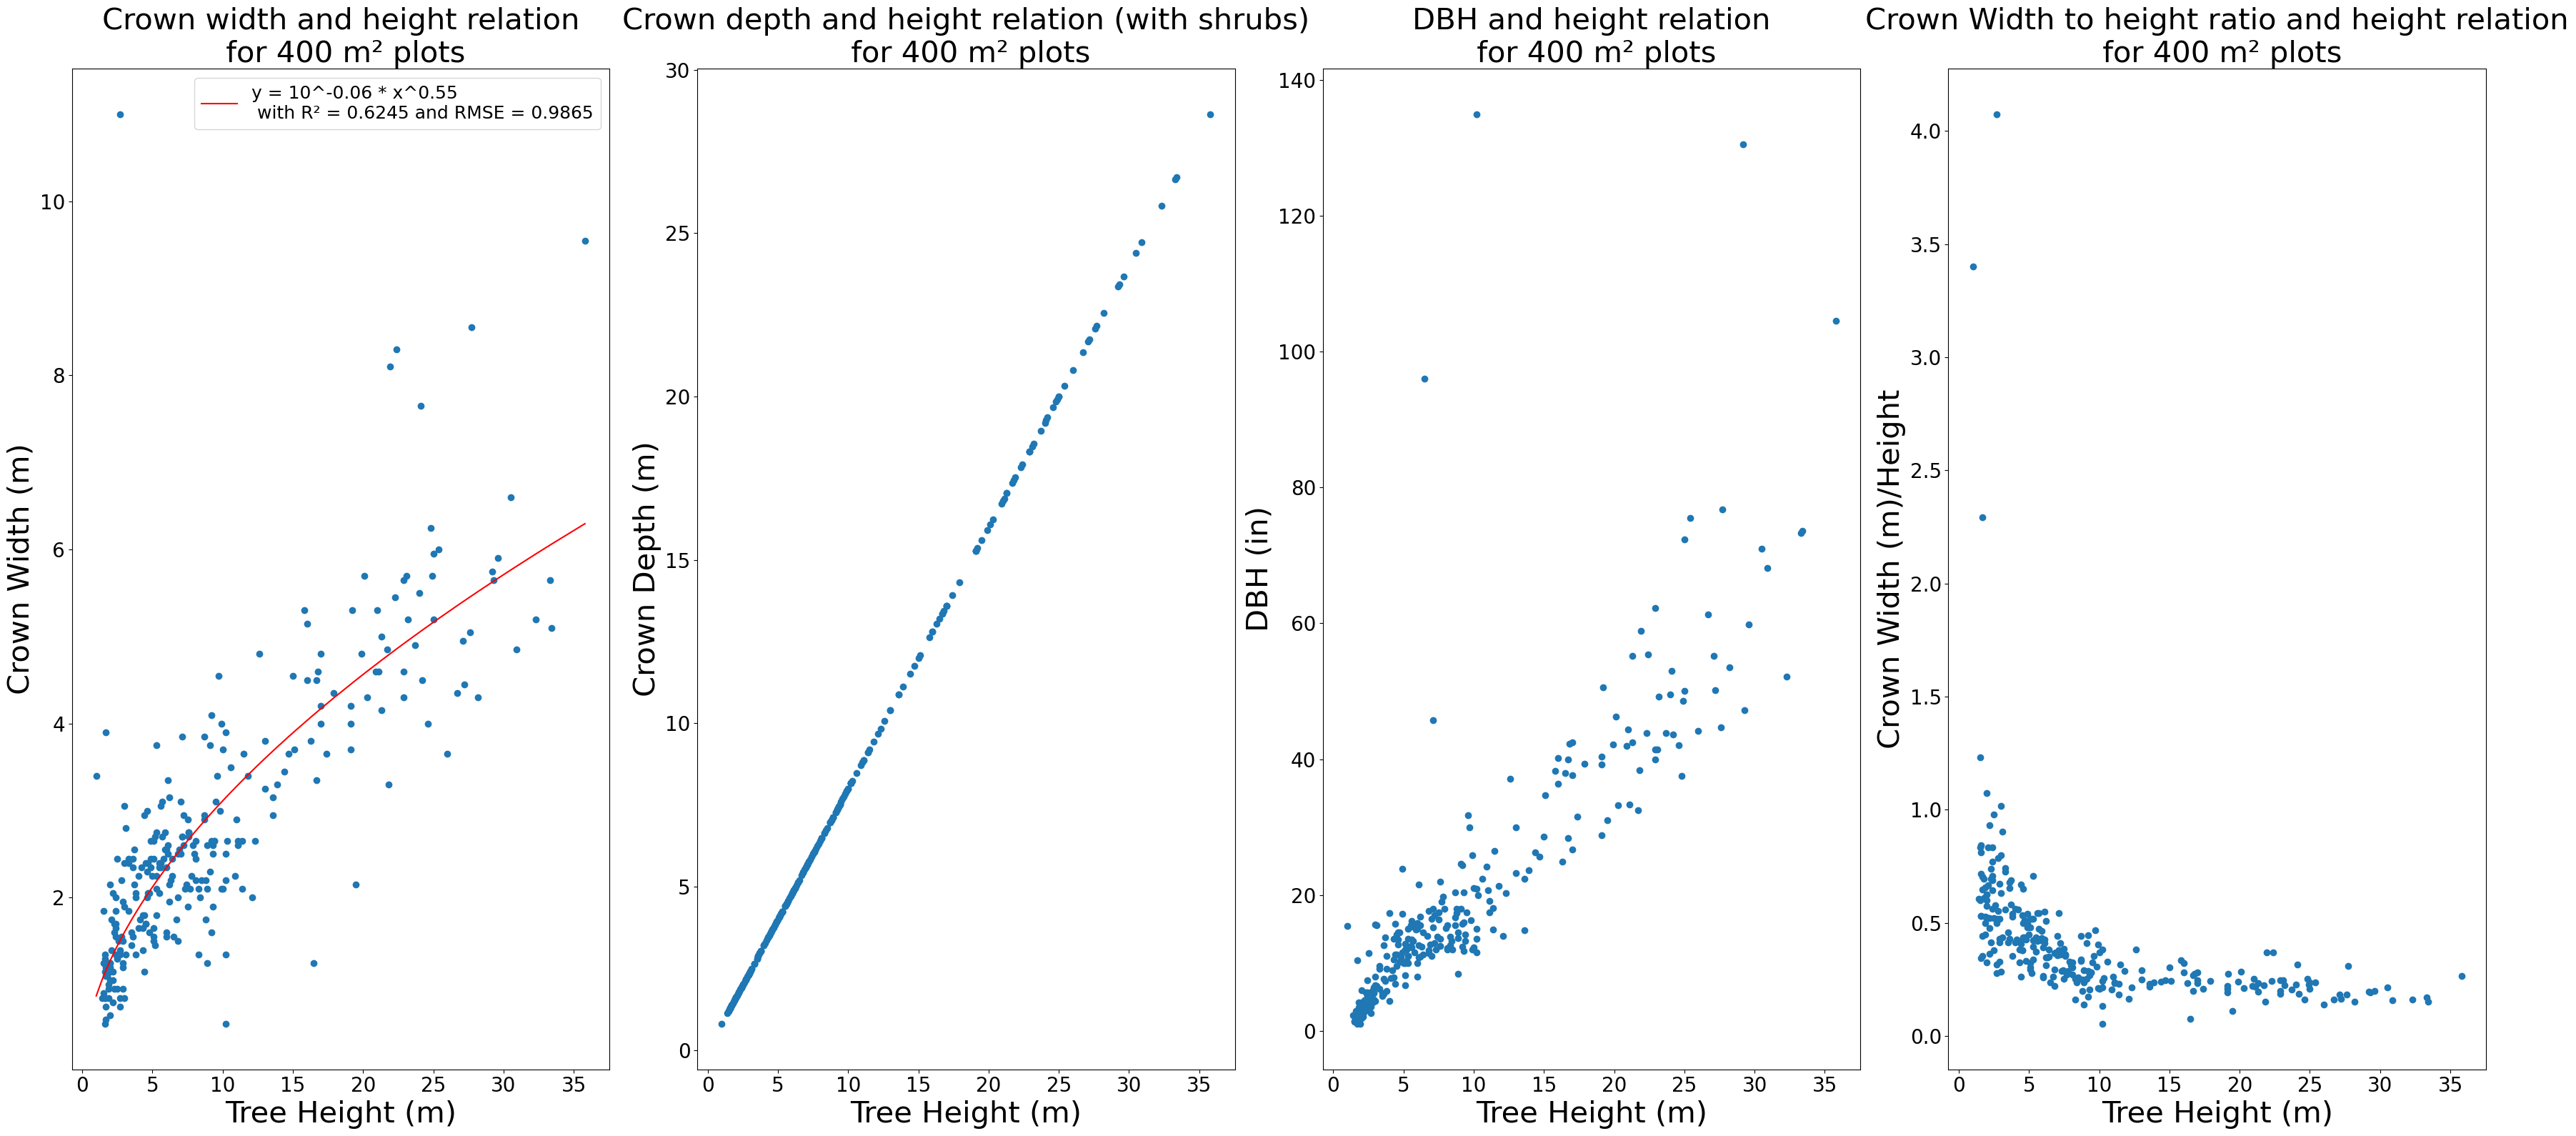

In [67]:
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

noshrub_height_nona_100_df = noshrub_height_nona_100_df.sort_values(by='height')
noshrub_height_nona_400_df = noshrub_height_nona_400_df.sort_values(by='height')

plot_tree_data_relationships(noshrub_height_nona_100_df, date_output_path, "100")
plot_tree_data_relationships(noshrub_height_nona_400_df, date_output_path, "400")

The regression formula is: y = (10^-0.0853) * (x^0.6229)


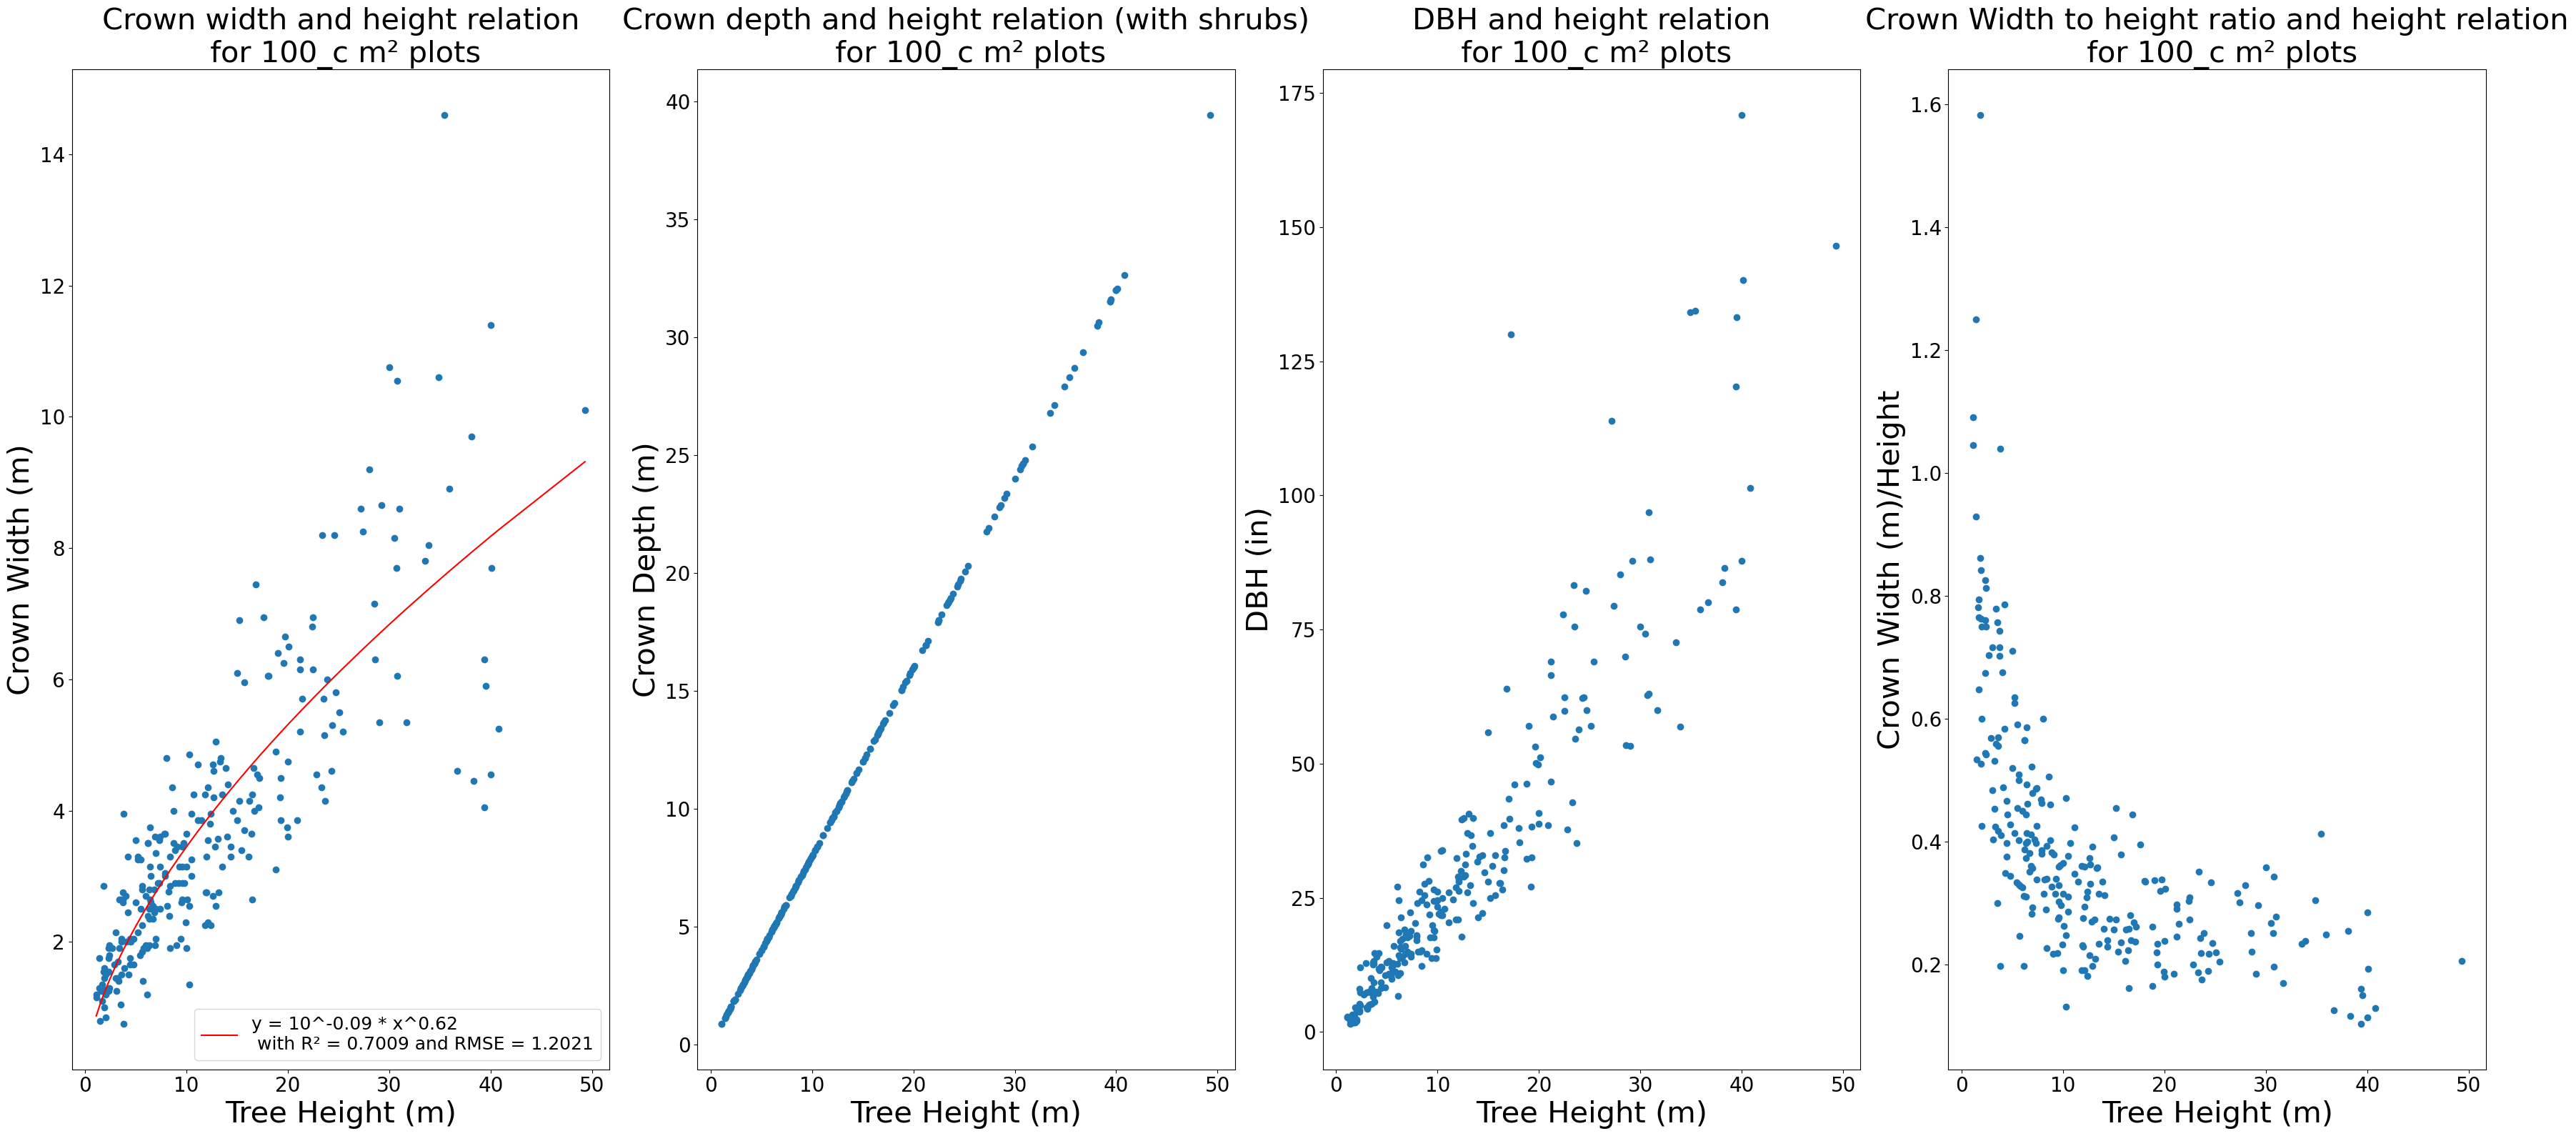

In [49]:

noshrub_height_nona_100_df_43_to_47 = noshrub_height_nona_100_df[~noshrub_height_nona_100_df['plotID'].isin(subset)]
plot_tree_data_relationships(noshrub_height_nona_100_df_43_to_47, date_output_path, "100_c")

In [50]:
def plot_histograms(df_height, df_stem, save_path, shrub=True):
    
    # Determine the appropriate subfolder based on the shrub variable
    if shrub:
        full_save_path = os.path.join(save_path, 'with_shrub')
    else:
        full_save_path = os.path.join(save_path, 'without_shrub')

    title_suffix = "(with Shrubs)" if shrub else "(without Shrubs)"
    
    # Ensure the full save path exists
    os.makedirs(full_save_path, exist_ok=True)
    
    print(full_save_path)
    
    # Plot 1: Crown Radius
    ax = df_height.hist(column='crown_radius', by=df_height['plotID'], bins=50, grid=False, figsize=(38, 38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)
    for ax_y in ax:
        for ax_x in ax_y:
            ax_x.set_ylabel('Count', fontsize=25)
            ax_x.set_xlabel('Crown Radius (m)', fontsize=25)
    plt.suptitle(f'Crown Radius Count (meters) for all TEAK sites {title_suffix}', x=0.5, y=0.1, fontsize=36)
    fig = ax[0][0].get_figure()
    fig.savefig(os.path.join(full_save_path, 'TEAK_crown_radius.png'))
    plt.show()

    # Plot 2: Tree Height
    ax = df_height.hist(column='height', by=df_height['plotID'], bins=50, grid=False, figsize=(38, 38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)
    for ax_y in ax:
        for ax_x in ax_y:
            ax_x.set_ylabel('Count', fontsize=25)
            ax_x.set_xlabel('Tree Height (m)', fontsize=25)
    plt.suptitle(f'Tree Height Count (meters) for all TEAK sites {title_suffix}', x=0.5, y=0.1, fontsize=36)
    fig = ax[0][0].get_figure()
    fig.savefig(os.path.join(full_save_path, 'TEAK_height.png'))
    plt.show()

    # Plot 3: Crown Width/Height Ratio
    ax = df_height.hist(column='crown_width/h', by=df_height['plotID'], bins=50, grid=False, figsize=(38, 48), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)
    for ax_y in ax:
        for ax_x in ax_y:
            ax_x.set_ylabel('Count', fontsize=25)
            ax_x.set_xlabel('Crown Width (m)/\nTree Height (m) Ratio', fontsize=25)
    plt.suptitle(f'Crown Width (meters) to Tree Height Ratio for all TEAK sites {title_suffix}', x=0.5, y=0.1, fontsize=36)
    fig = ax[0][0].get_figure()
    fig.savefig(os.path.join(full_save_path, 'TEAK_crown_width_height_ratio.png'))
    plt.show()

    # Plot 4: Crown Depth/Height Ratio
    ax = df_height.hist(column='crown_depth/h', bins=50, grid=False, figsize=(19, 10), color='#86bf91', zorder=2, rwidth=0.9)
    ax[0][0].set_ylabel('Count', fontsize=25)
    ax[0][0].set_xlabel('Crown Depth (m)/Tree Height (m) Ratio', fontsize=25)
    plt.title(f'Crown Depth (meters) to Tree Height (meters) Ratio {title_suffix}', fontsize=36)
    fig = ax[0][0].get_figure()
    fig.savefig(os.path.join(full_save_path, 'TEAK_crown_depth_height_ratio.png'))
    plt.show()

    # Plot 5: Crown Depth/Crown Width Ratio
    ax = df_height.hist(column='crown_depth/crown_width', bins=50, grid=False, figsize=(19, 10), color='#86bf91', zorder=2, rwidth=0.9)
    ax[0][0].set_ylabel('Count', fontsize=25)
    ax[0][0].set_xlabel('Crown Depth (m)/Crown Width (m) Ratio', fontsize=25)
    plt.title(f'Crown Depth (meters) to Crown Width (meters) Ratio {title_suffix}', fontsize=36)
    fig = ax[0][0].get_figure()
    fig.savefig(os.path.join(full_save_path, 'TEAK_crown_depth_crown_width_ratio.png'))
    plt.show()

    # Plot 6: DBH
    ax = df_stem.hist(column='stemDiameter', by=df_stem['plotID'], bins=50, grid=False, figsize=(38, 38), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)
    for ax_y in ax:
        for ax_x in ax_y:
            ax_x.set_ylabel('Count', fontsize=25)
            ax_x.set_xlabel('DBH in dcm', fontsize=25)
    plt.suptitle('Stem Diameter/DBH count (decimeters) for all TEAK sites', x=0.5, y=0.02, fontsize=36)  # Title at bottom
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust the bottom margin to fit the title
    plt.subplots_adjust(top=0.9)  # Ensure space for the title if needed
    plt.savefig(os.path.join(full_save_path, 'TEAK_DBH.png'))
    plt.show()
    plt.close()

    # Close all figures to free up memory
    plt.close('all')

/data/shared/src/STV/NEON_TEAK/allen/figs/veg_input/2024_09_09/with_shrub


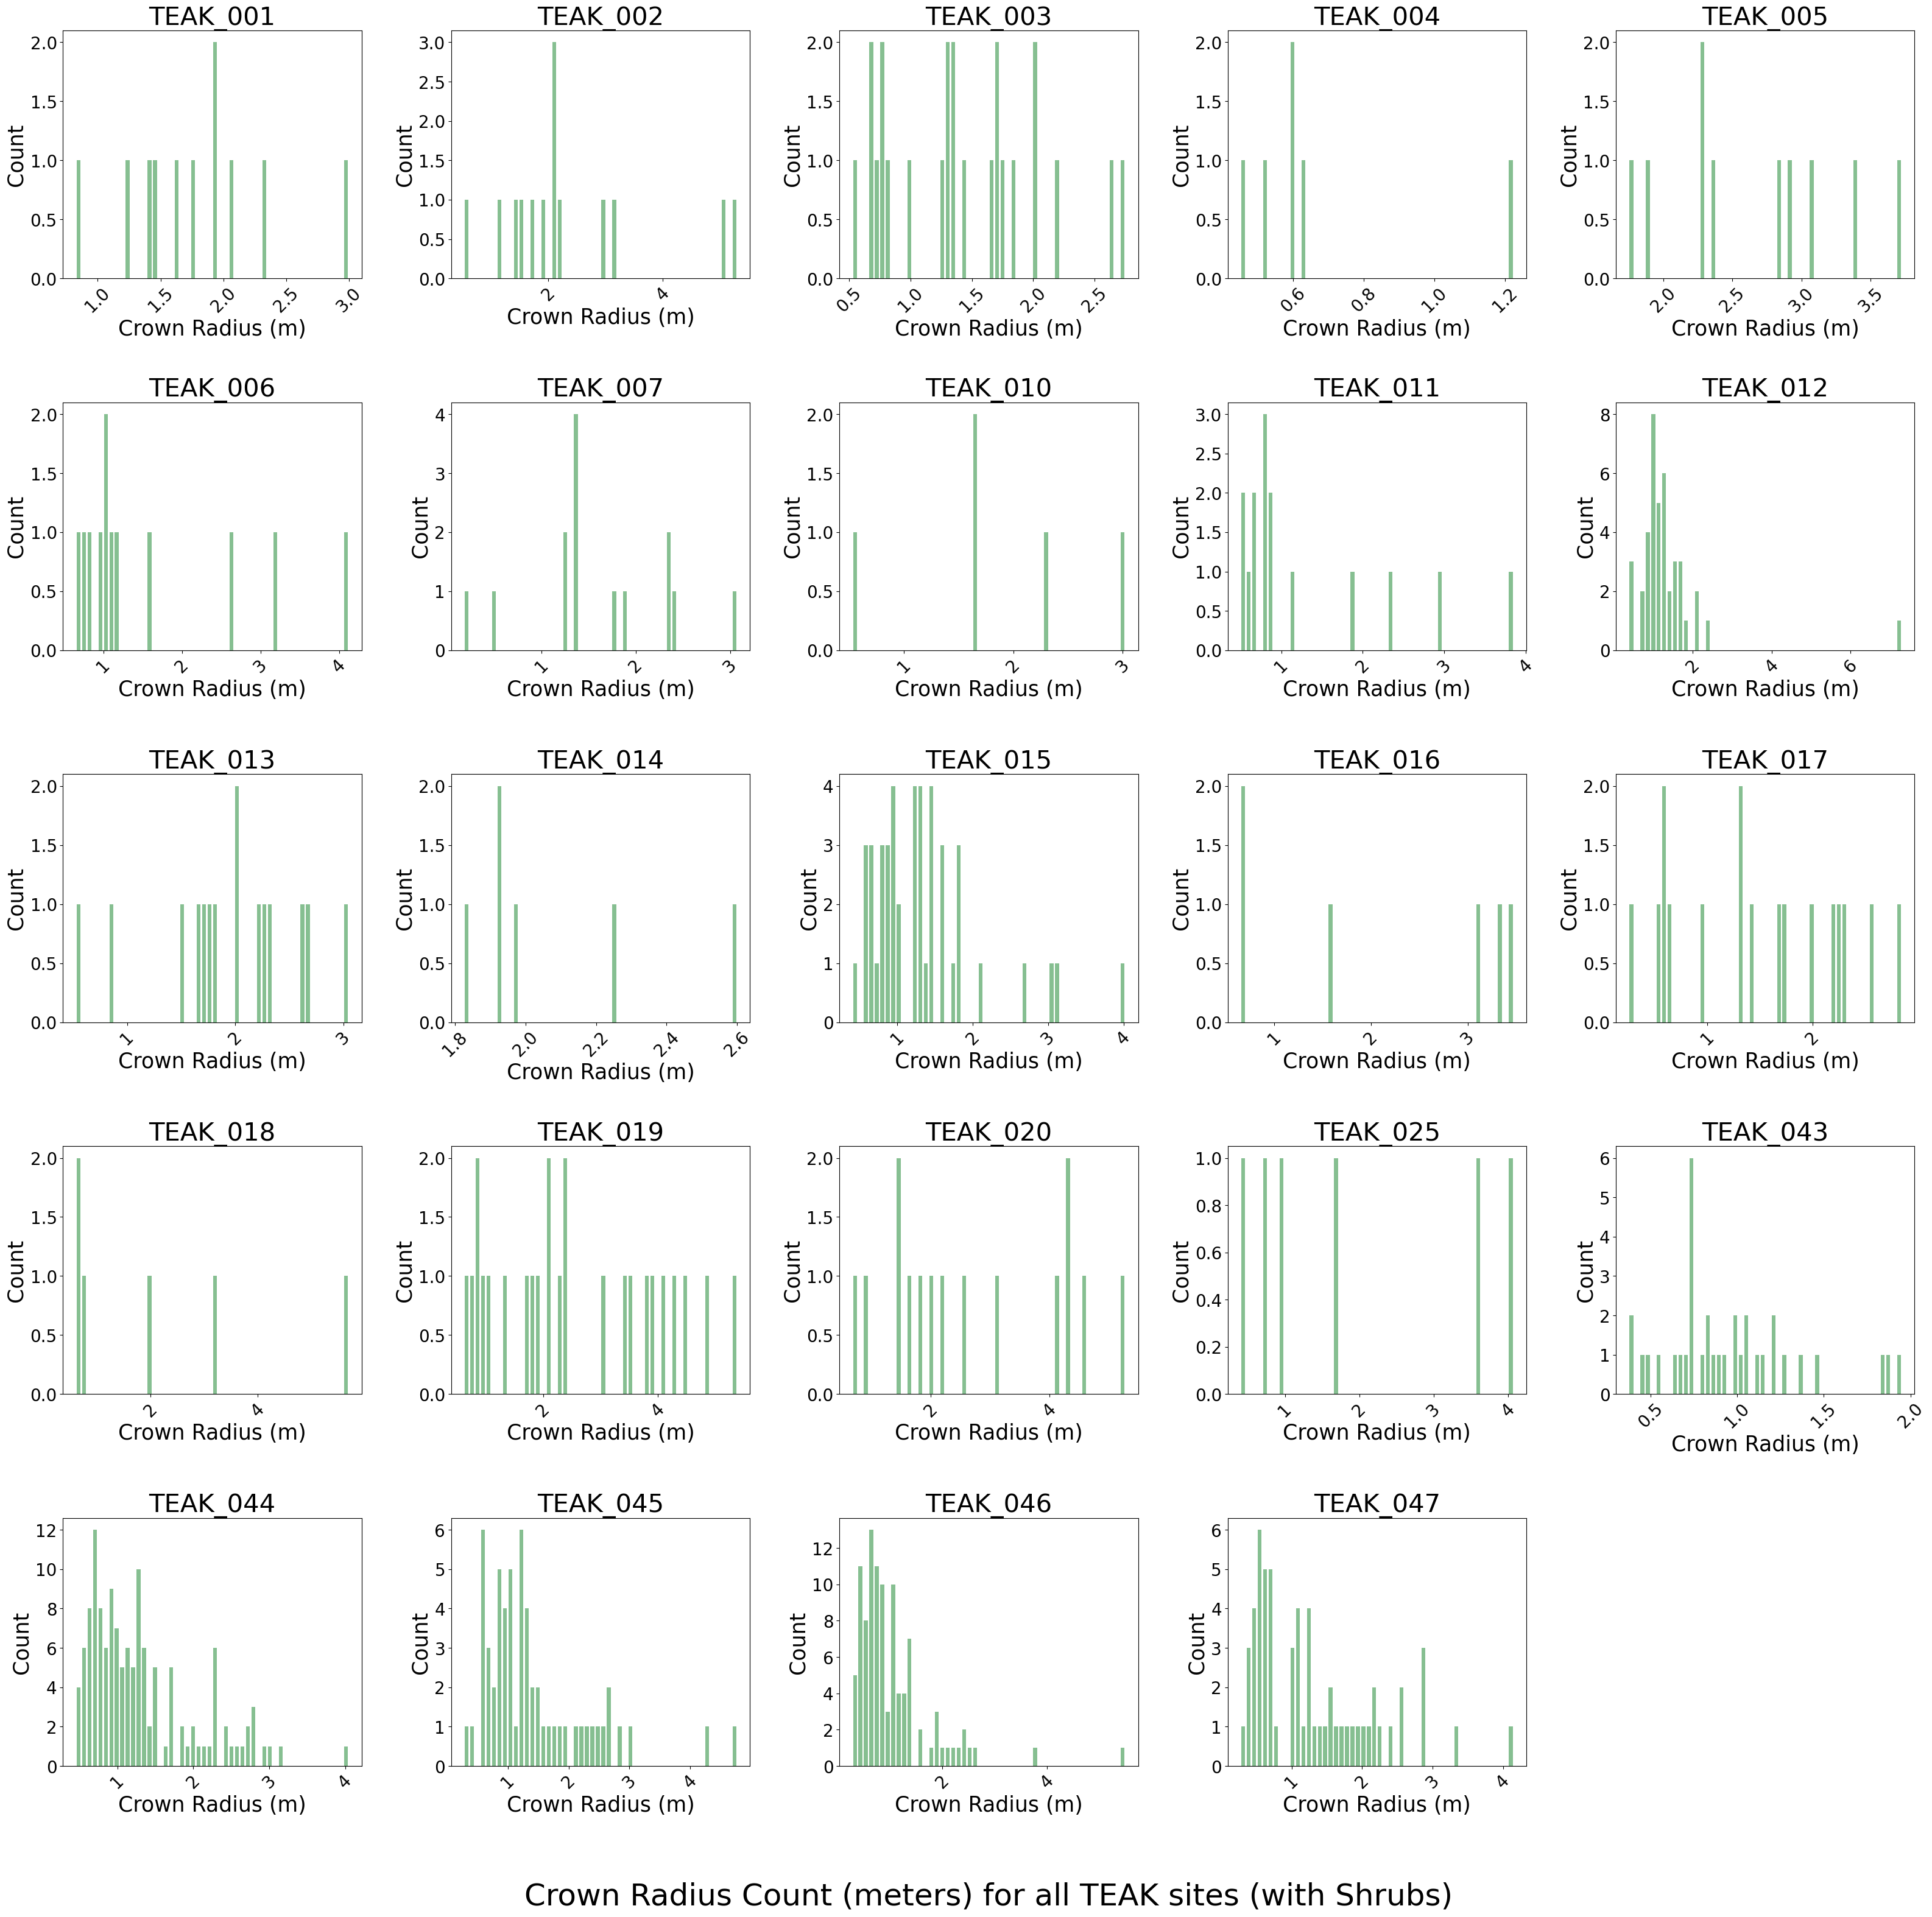

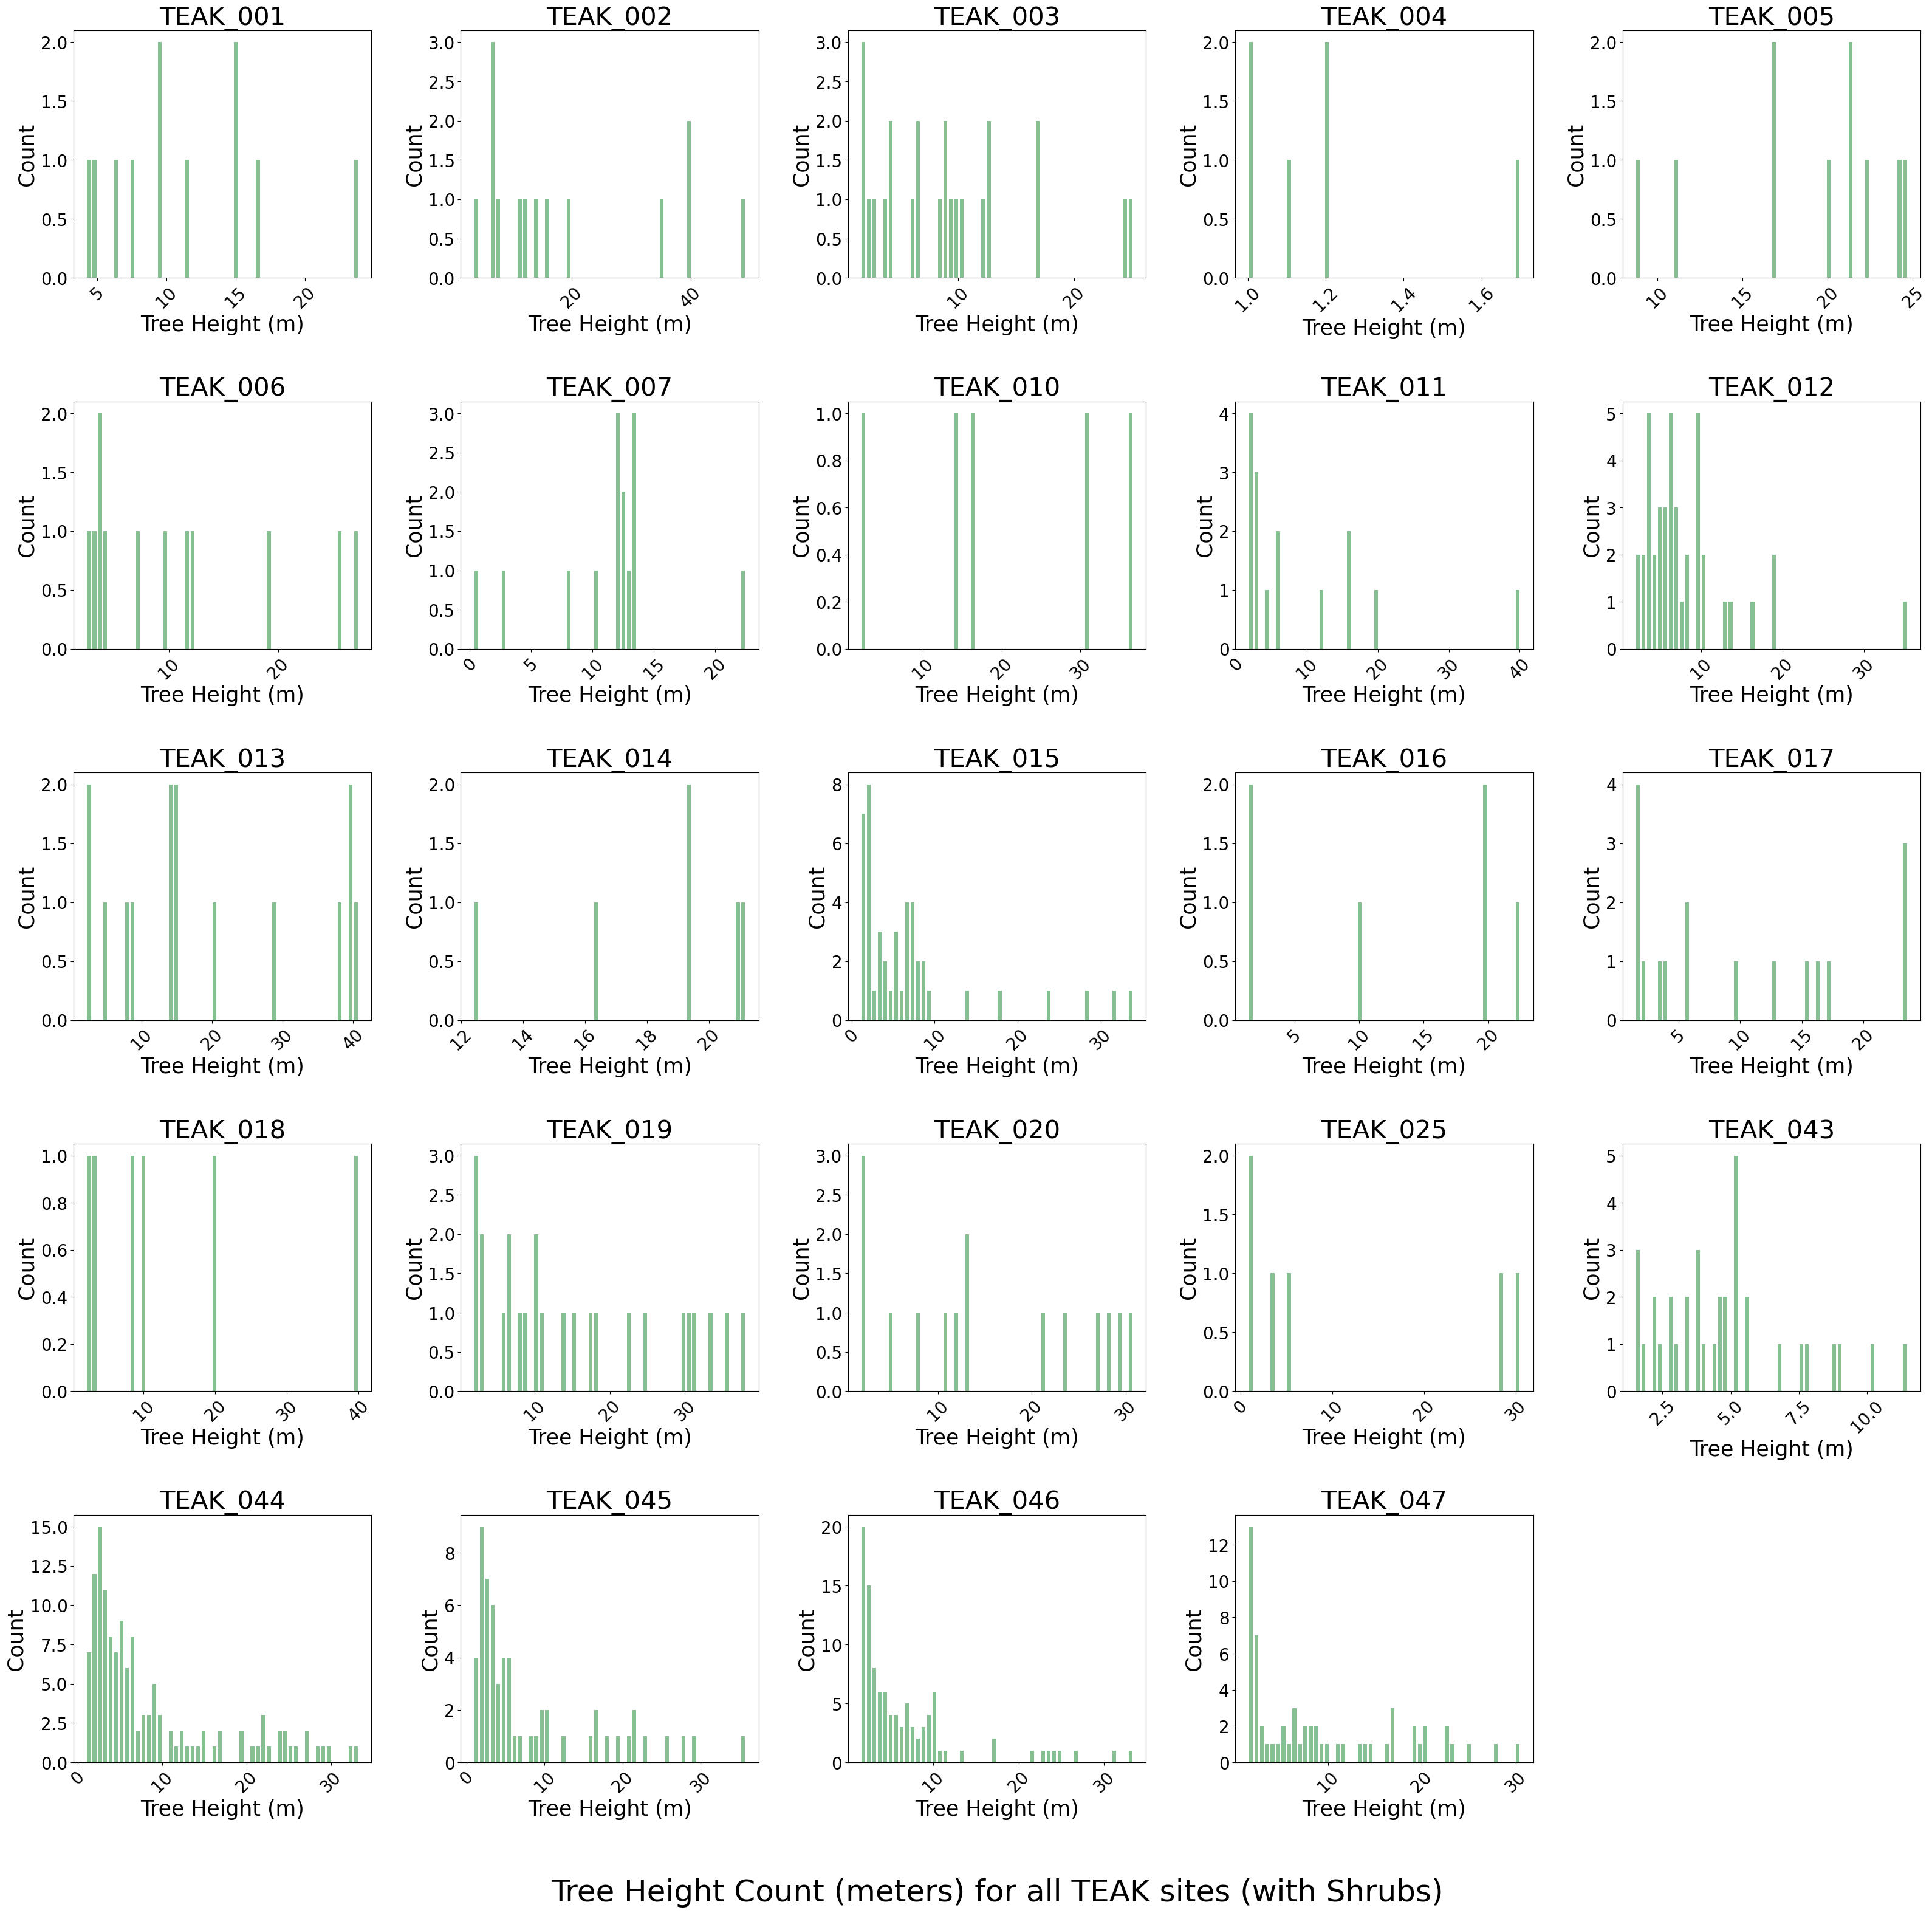

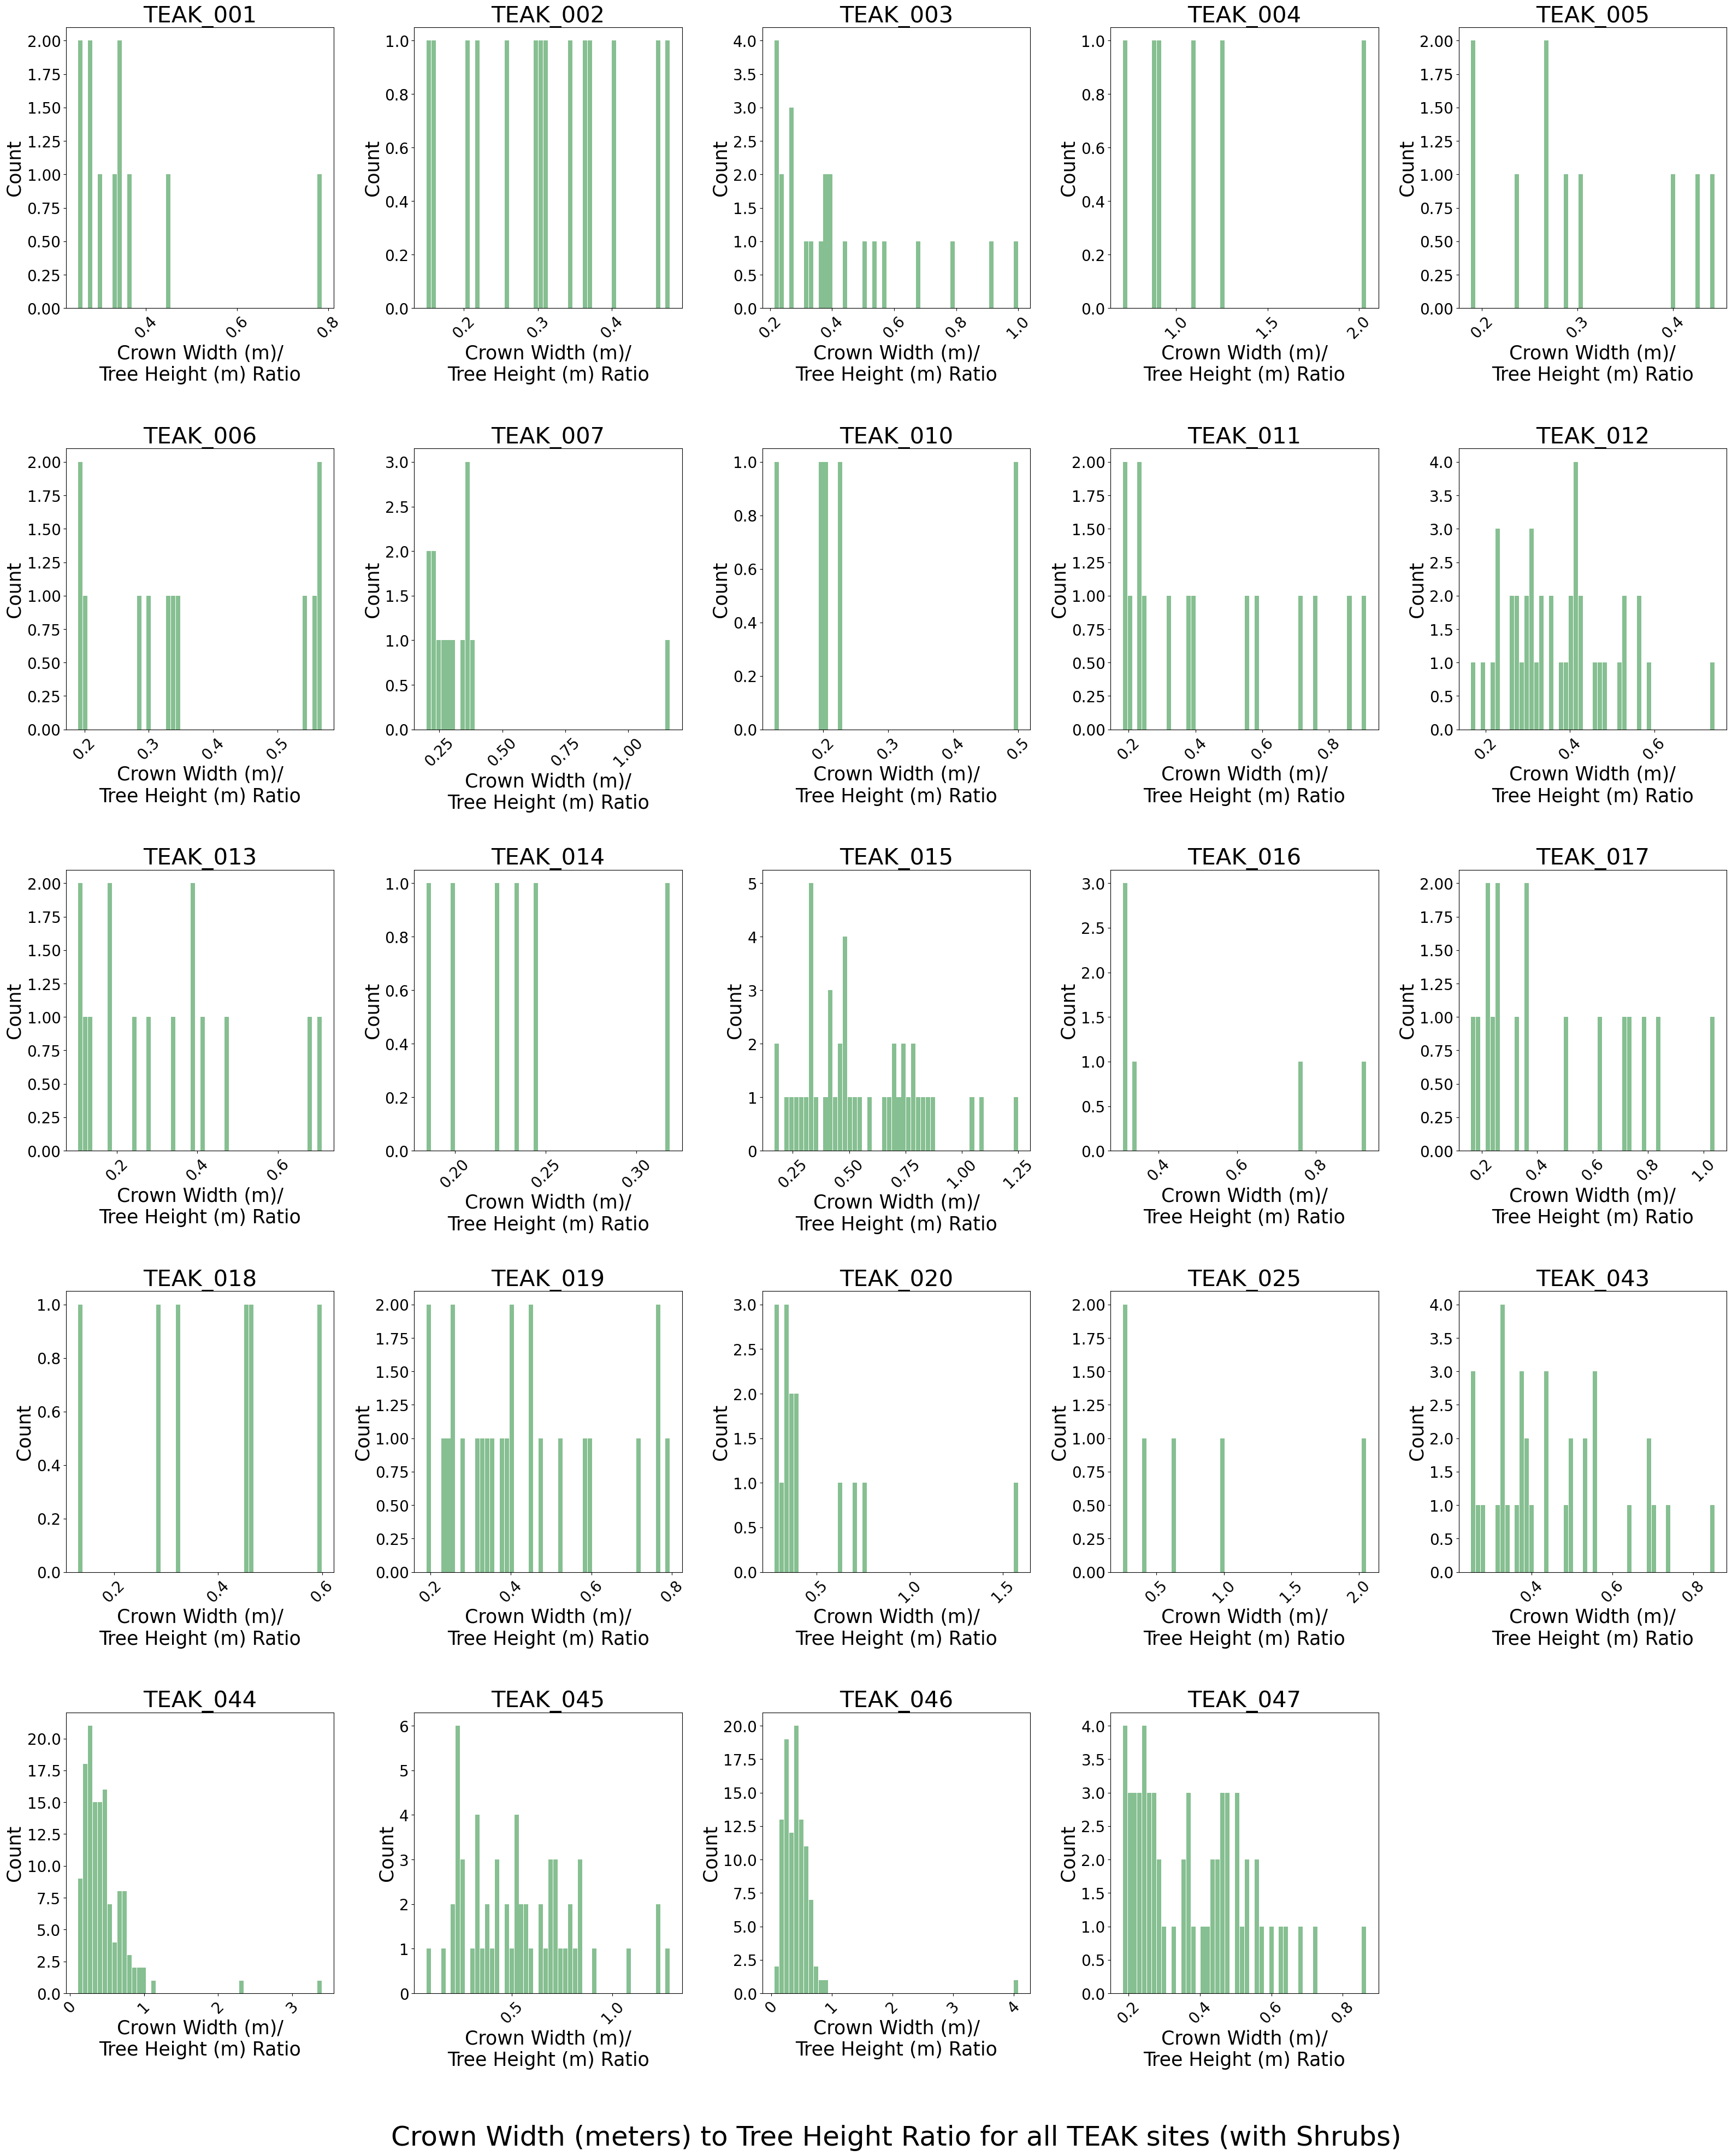

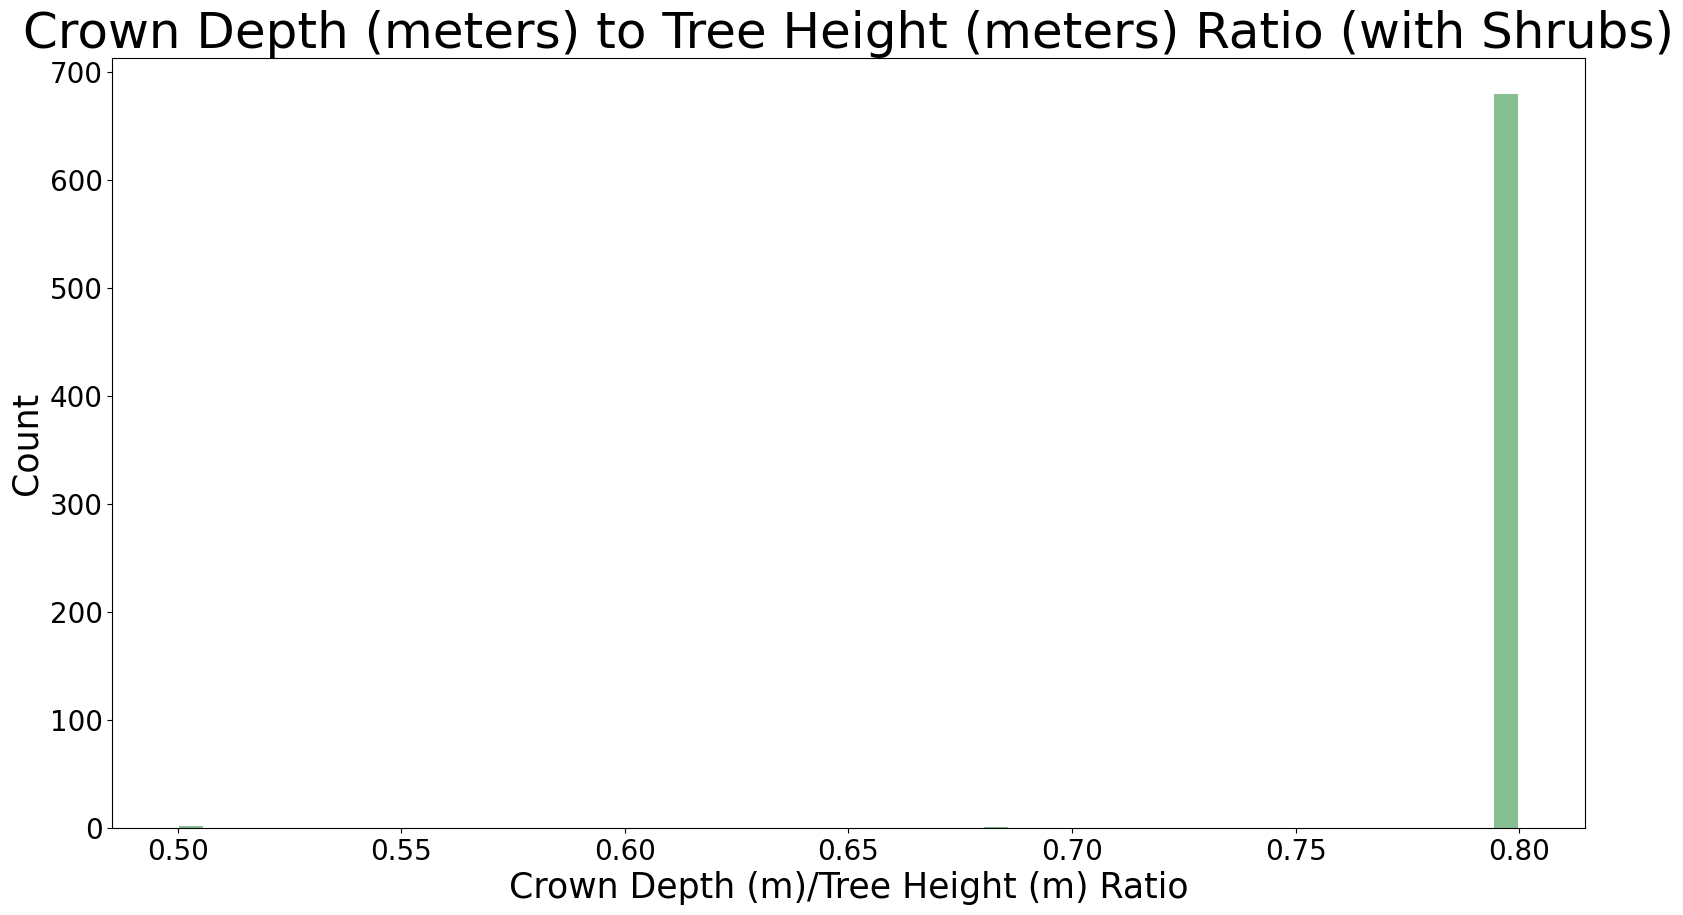

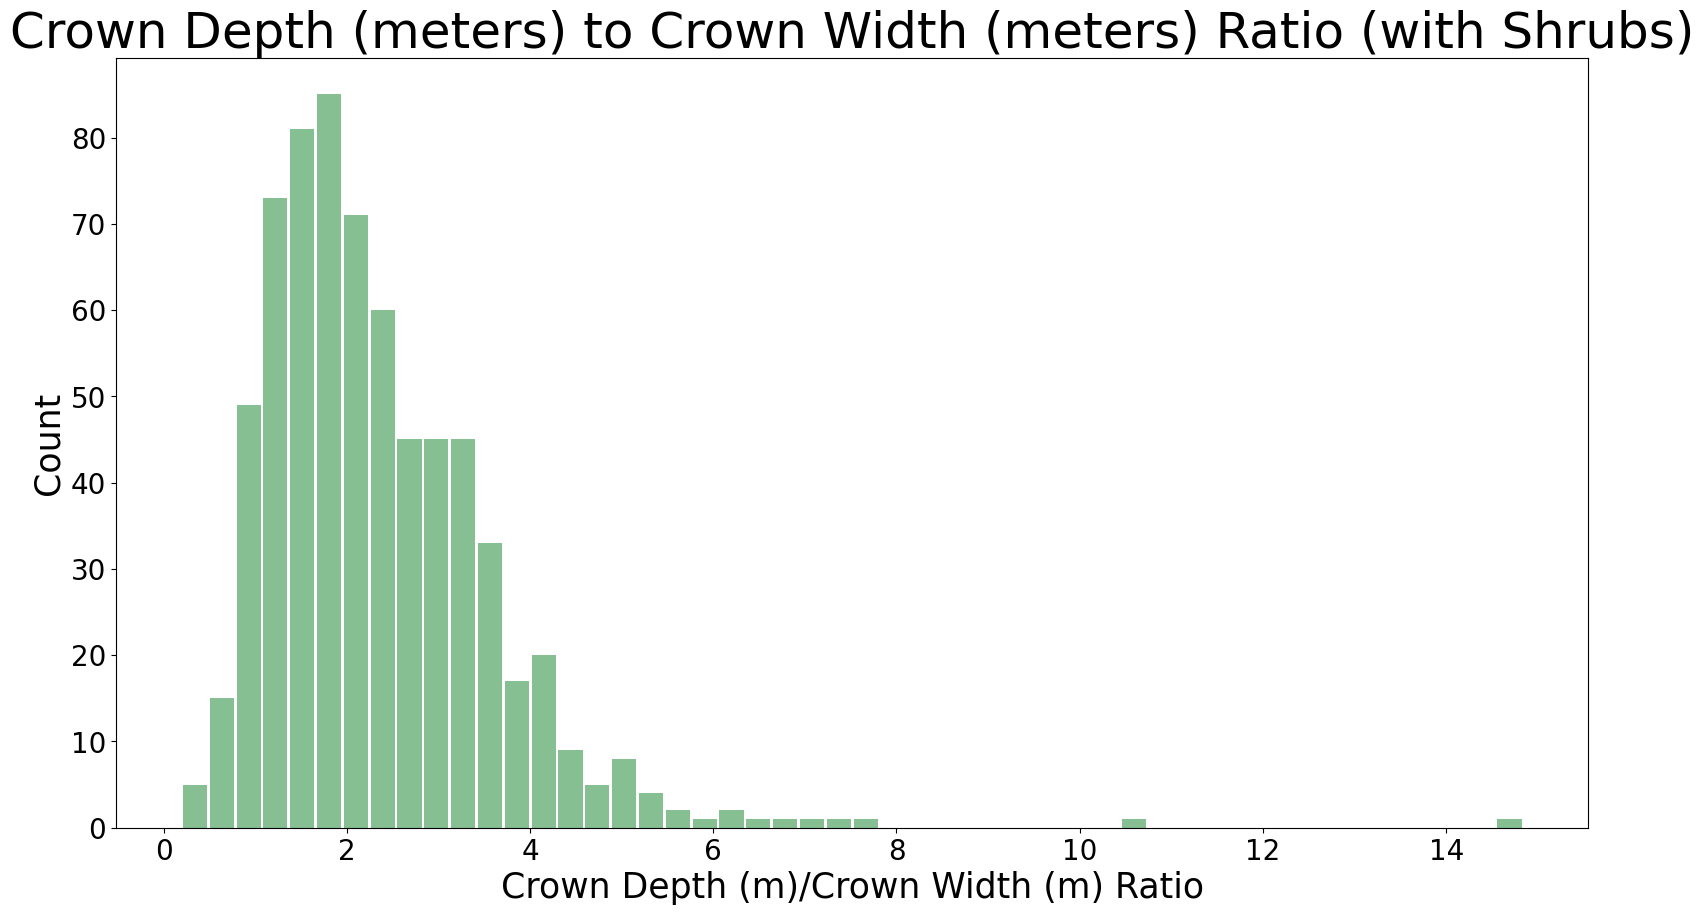

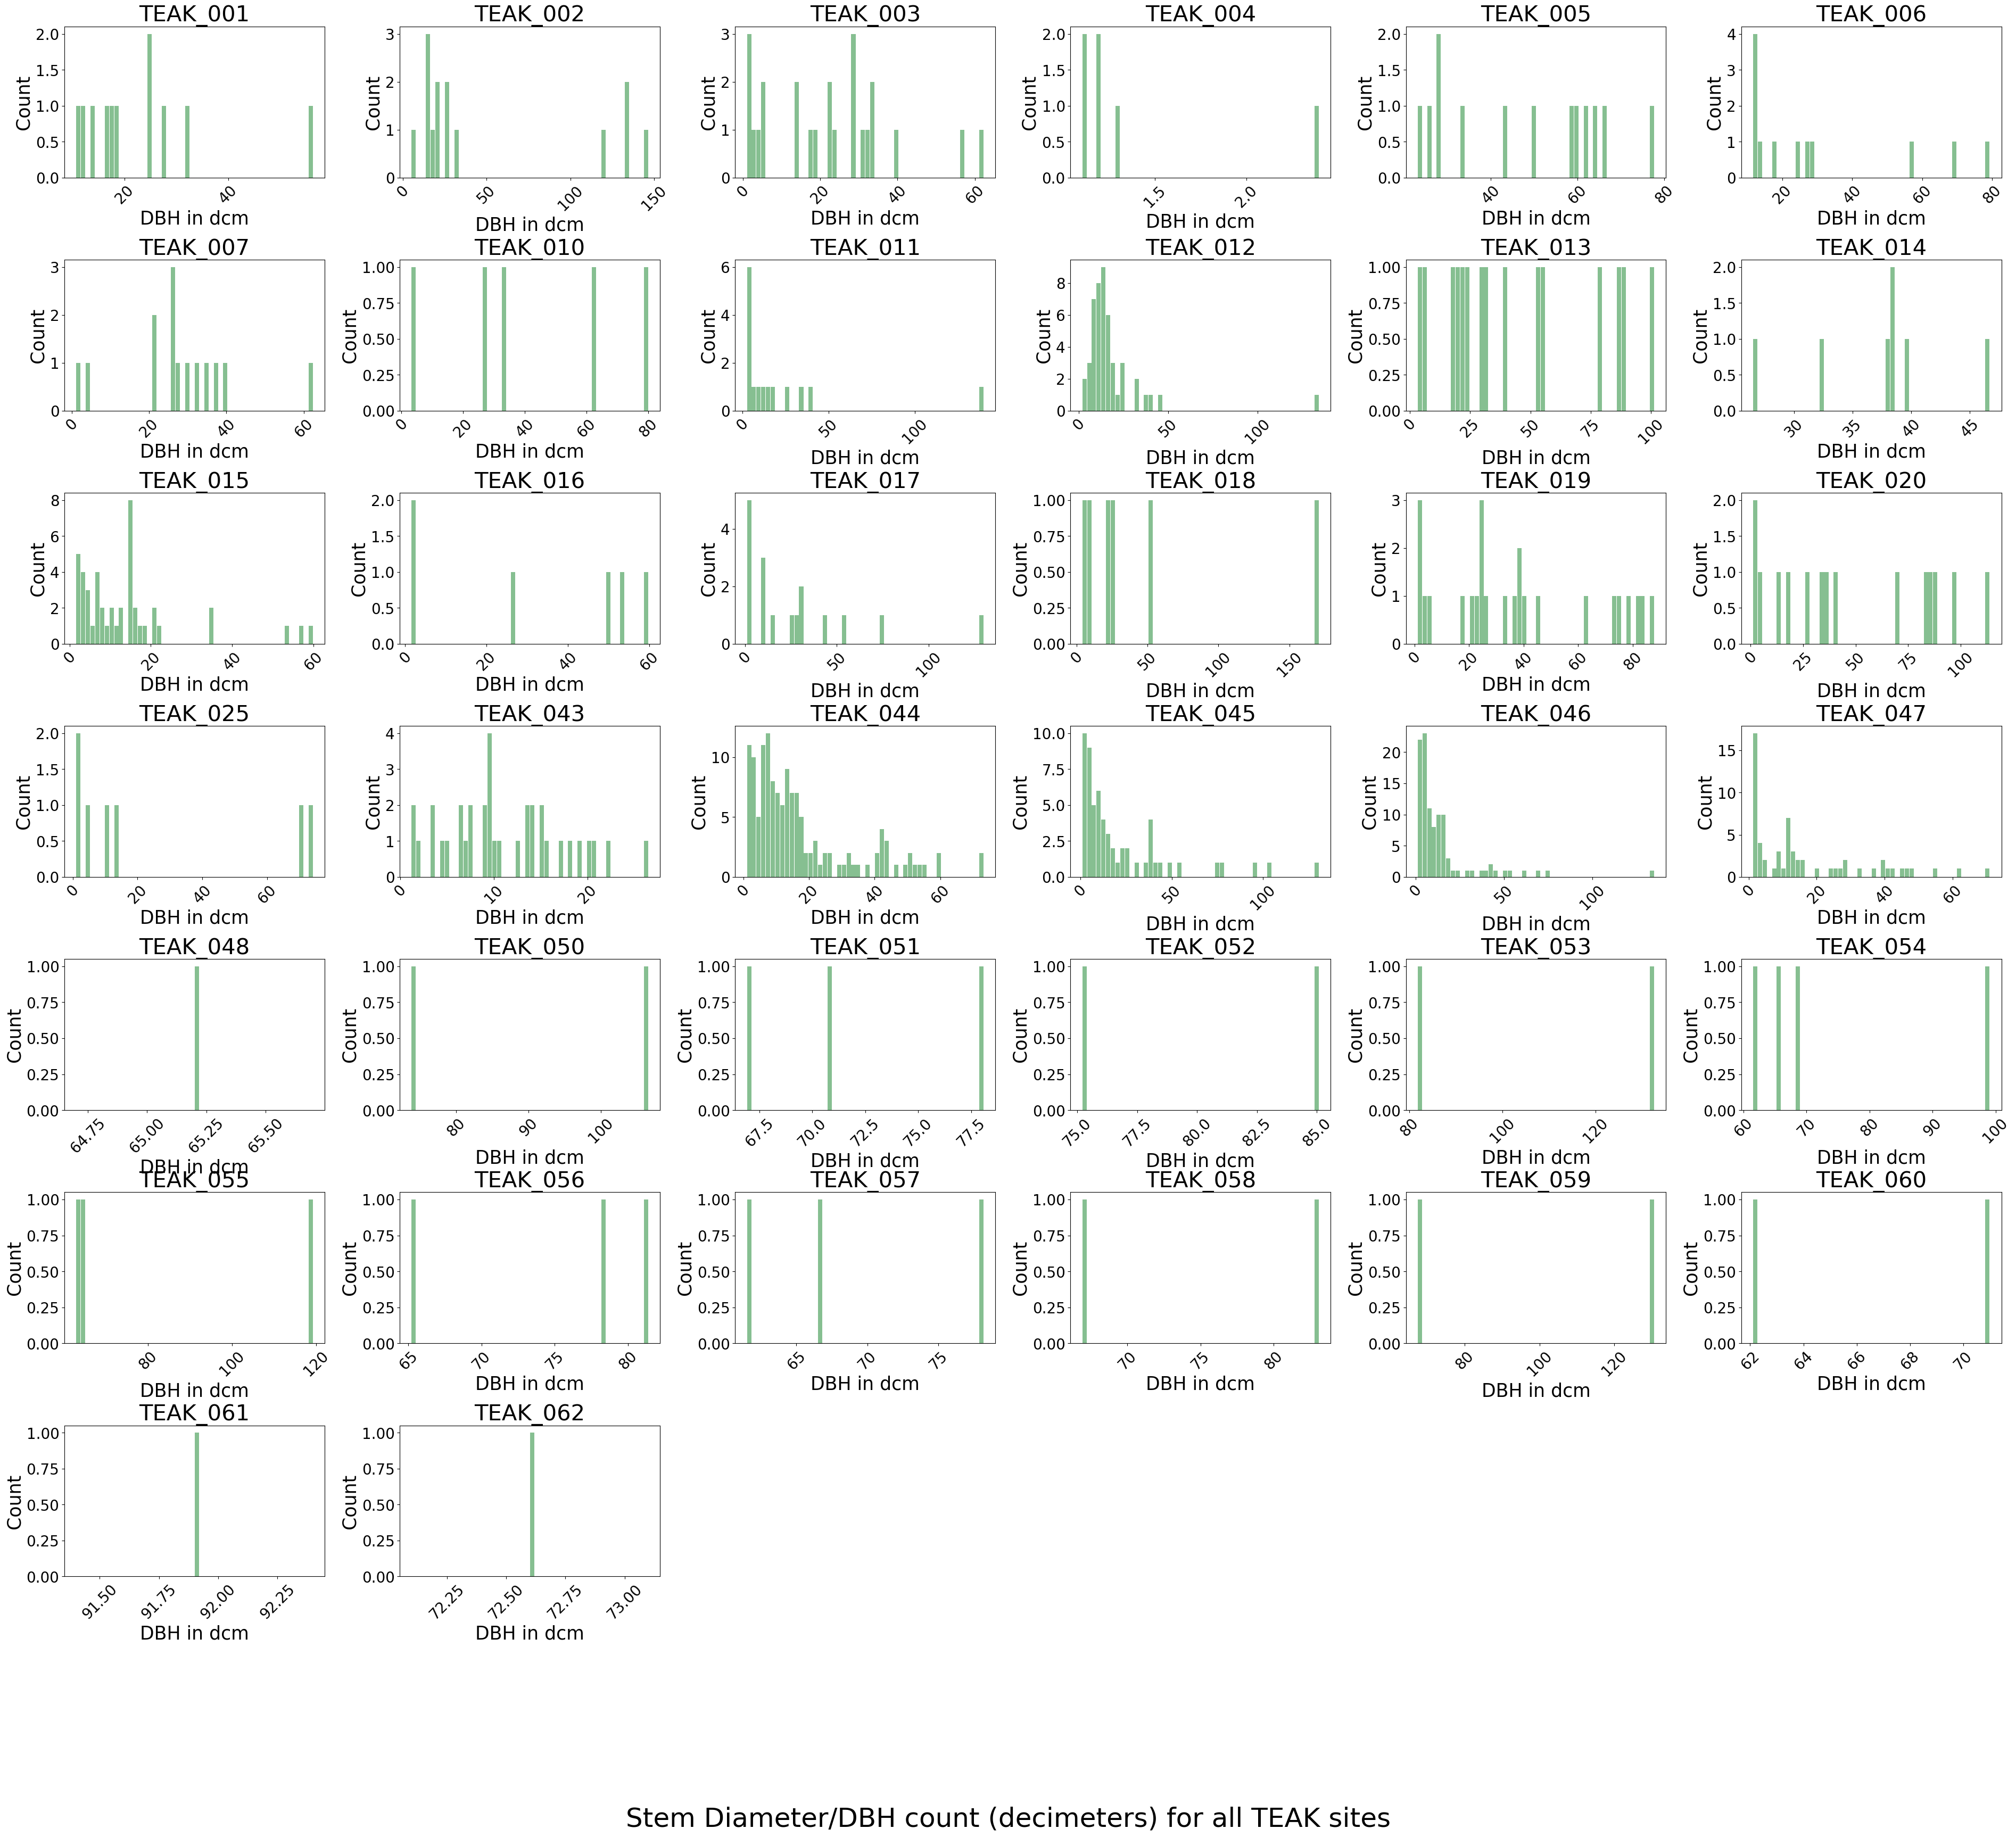

In [51]:
plot_histograms(shrub_height_nona_df, shrub_stem_nona_df, date_output_path, shrub=True)

/data/shared/src/STV/NEON_TEAK/allen/figs/veg_input/2024_09_09/without_shrub


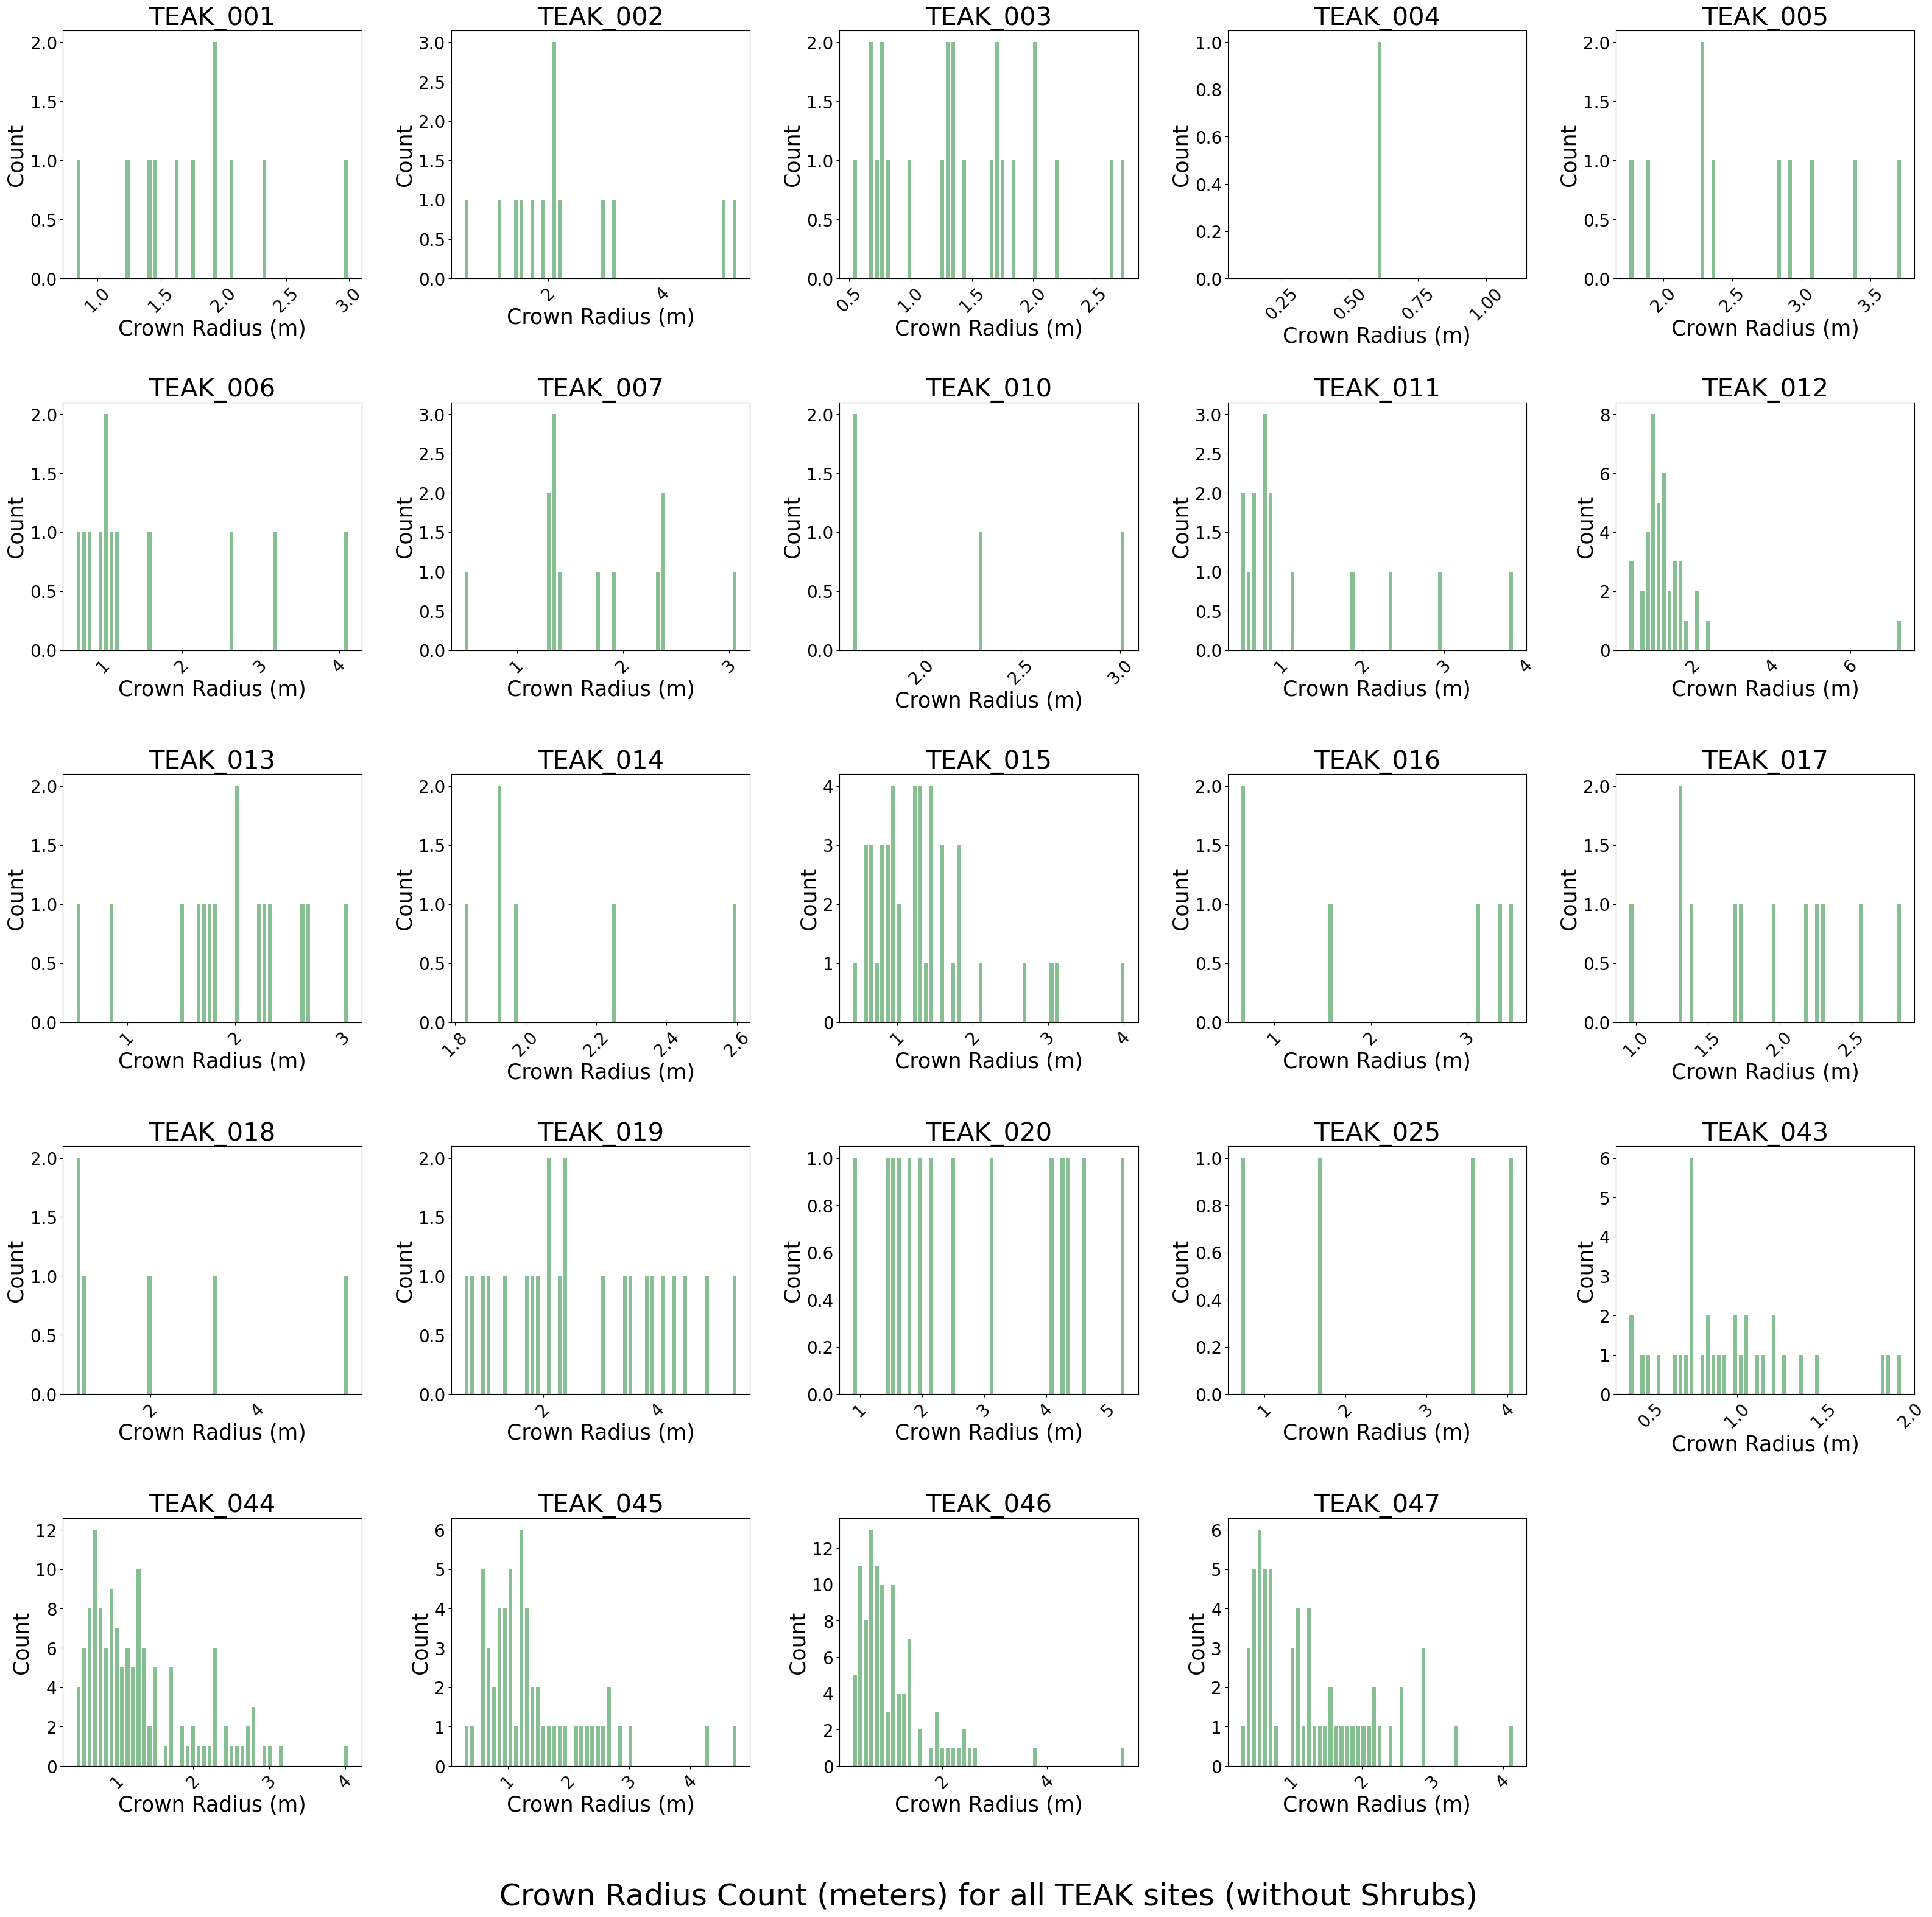

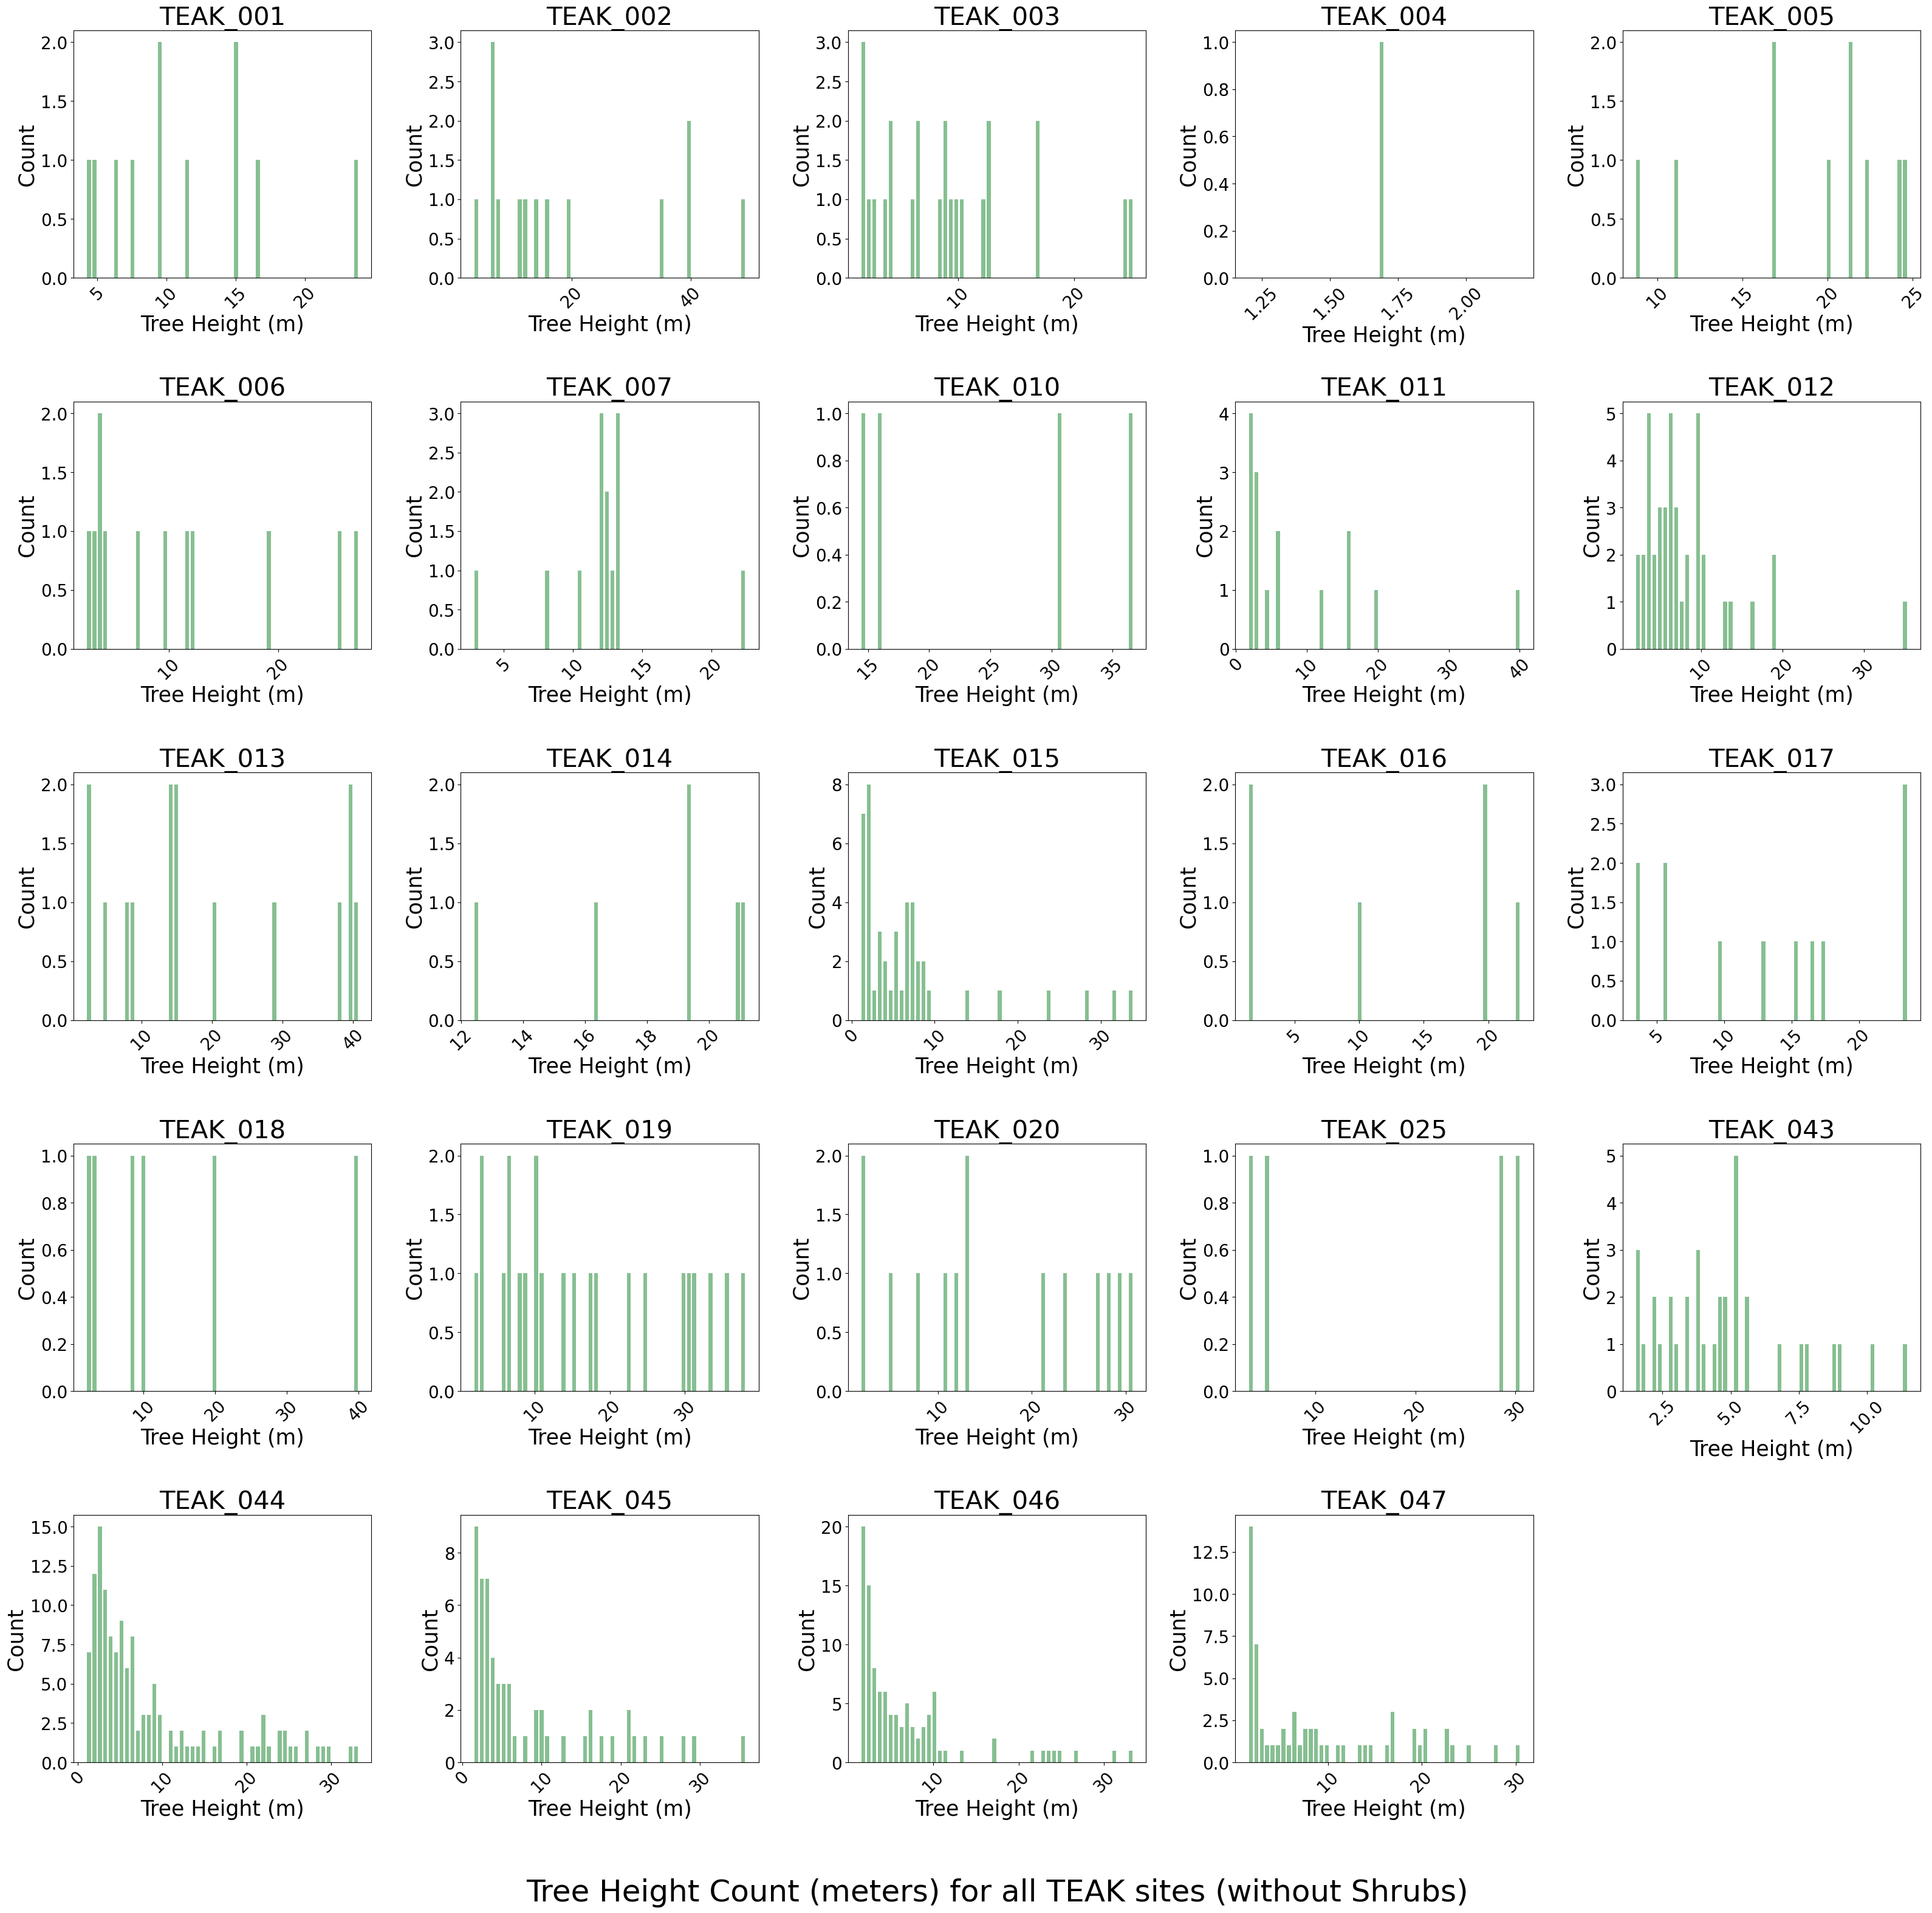

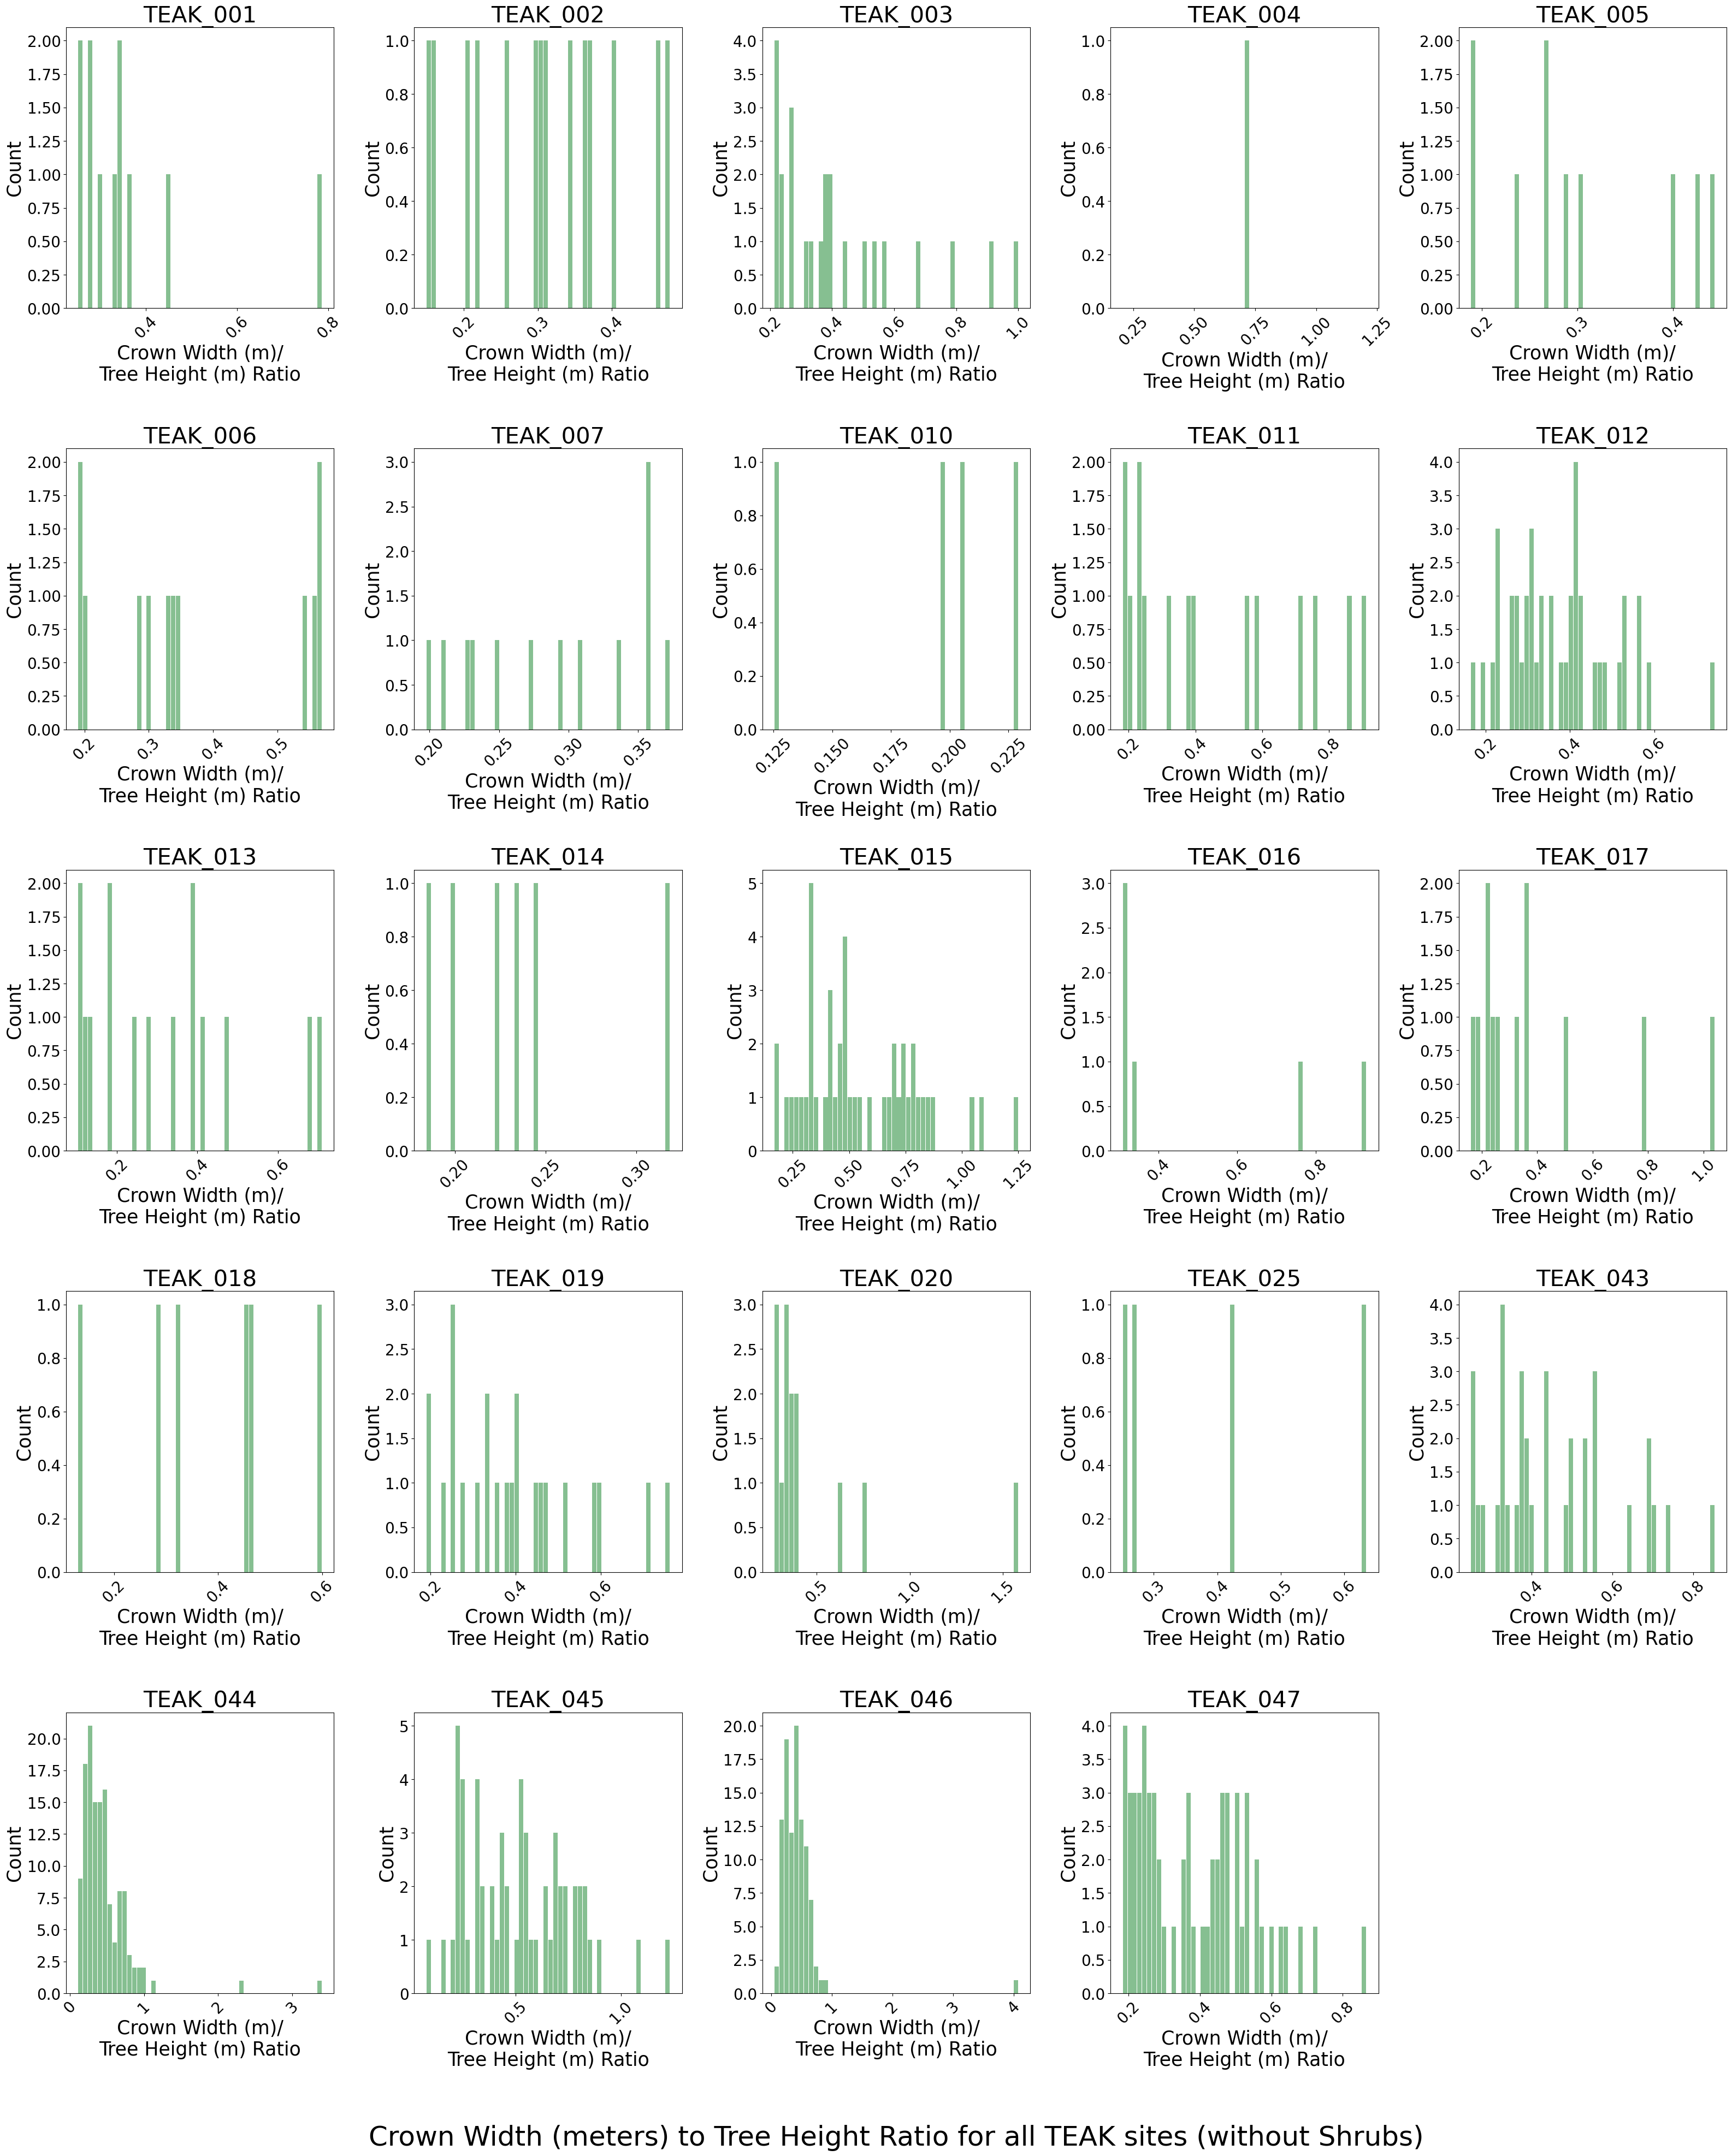

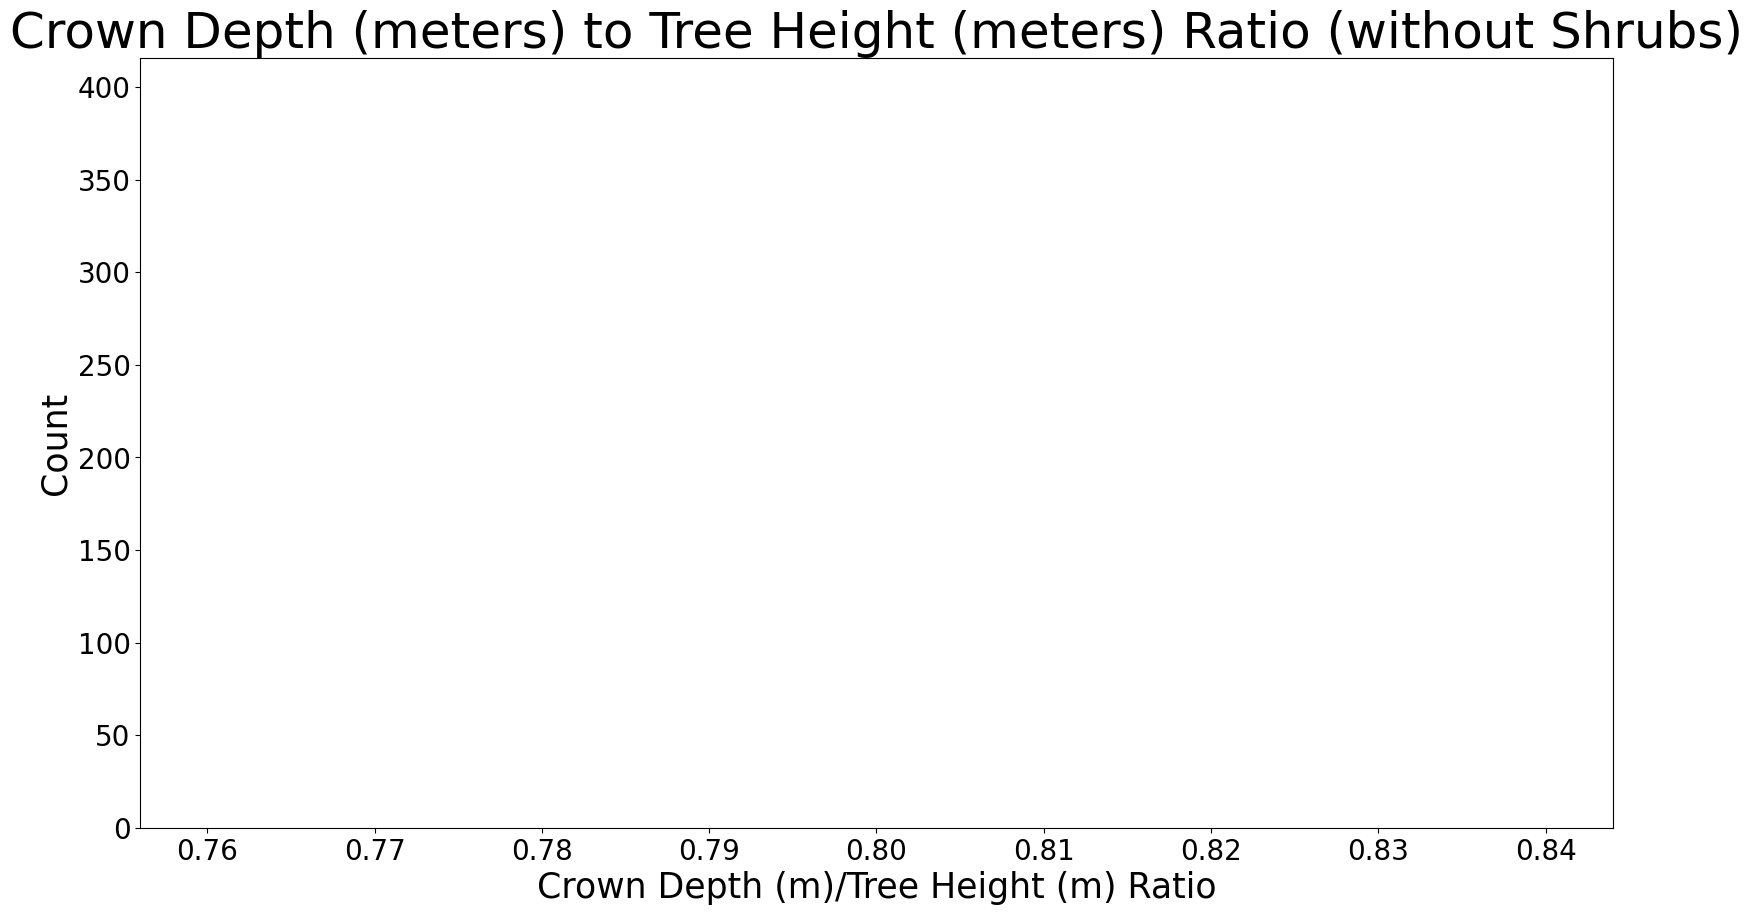

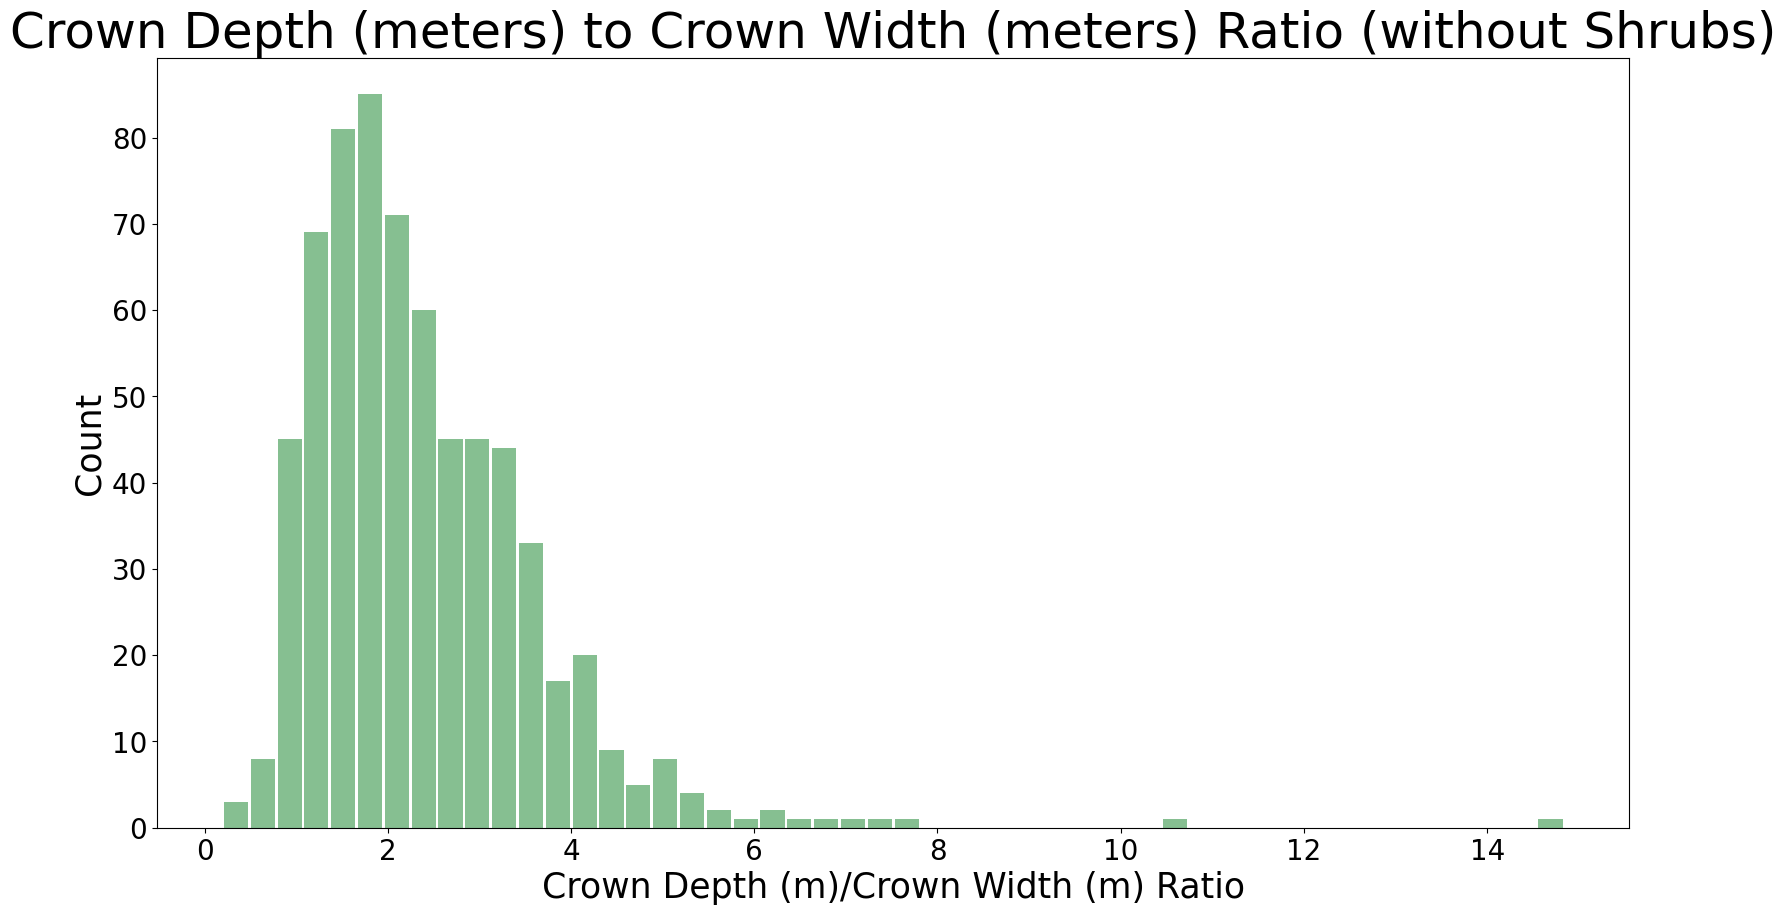

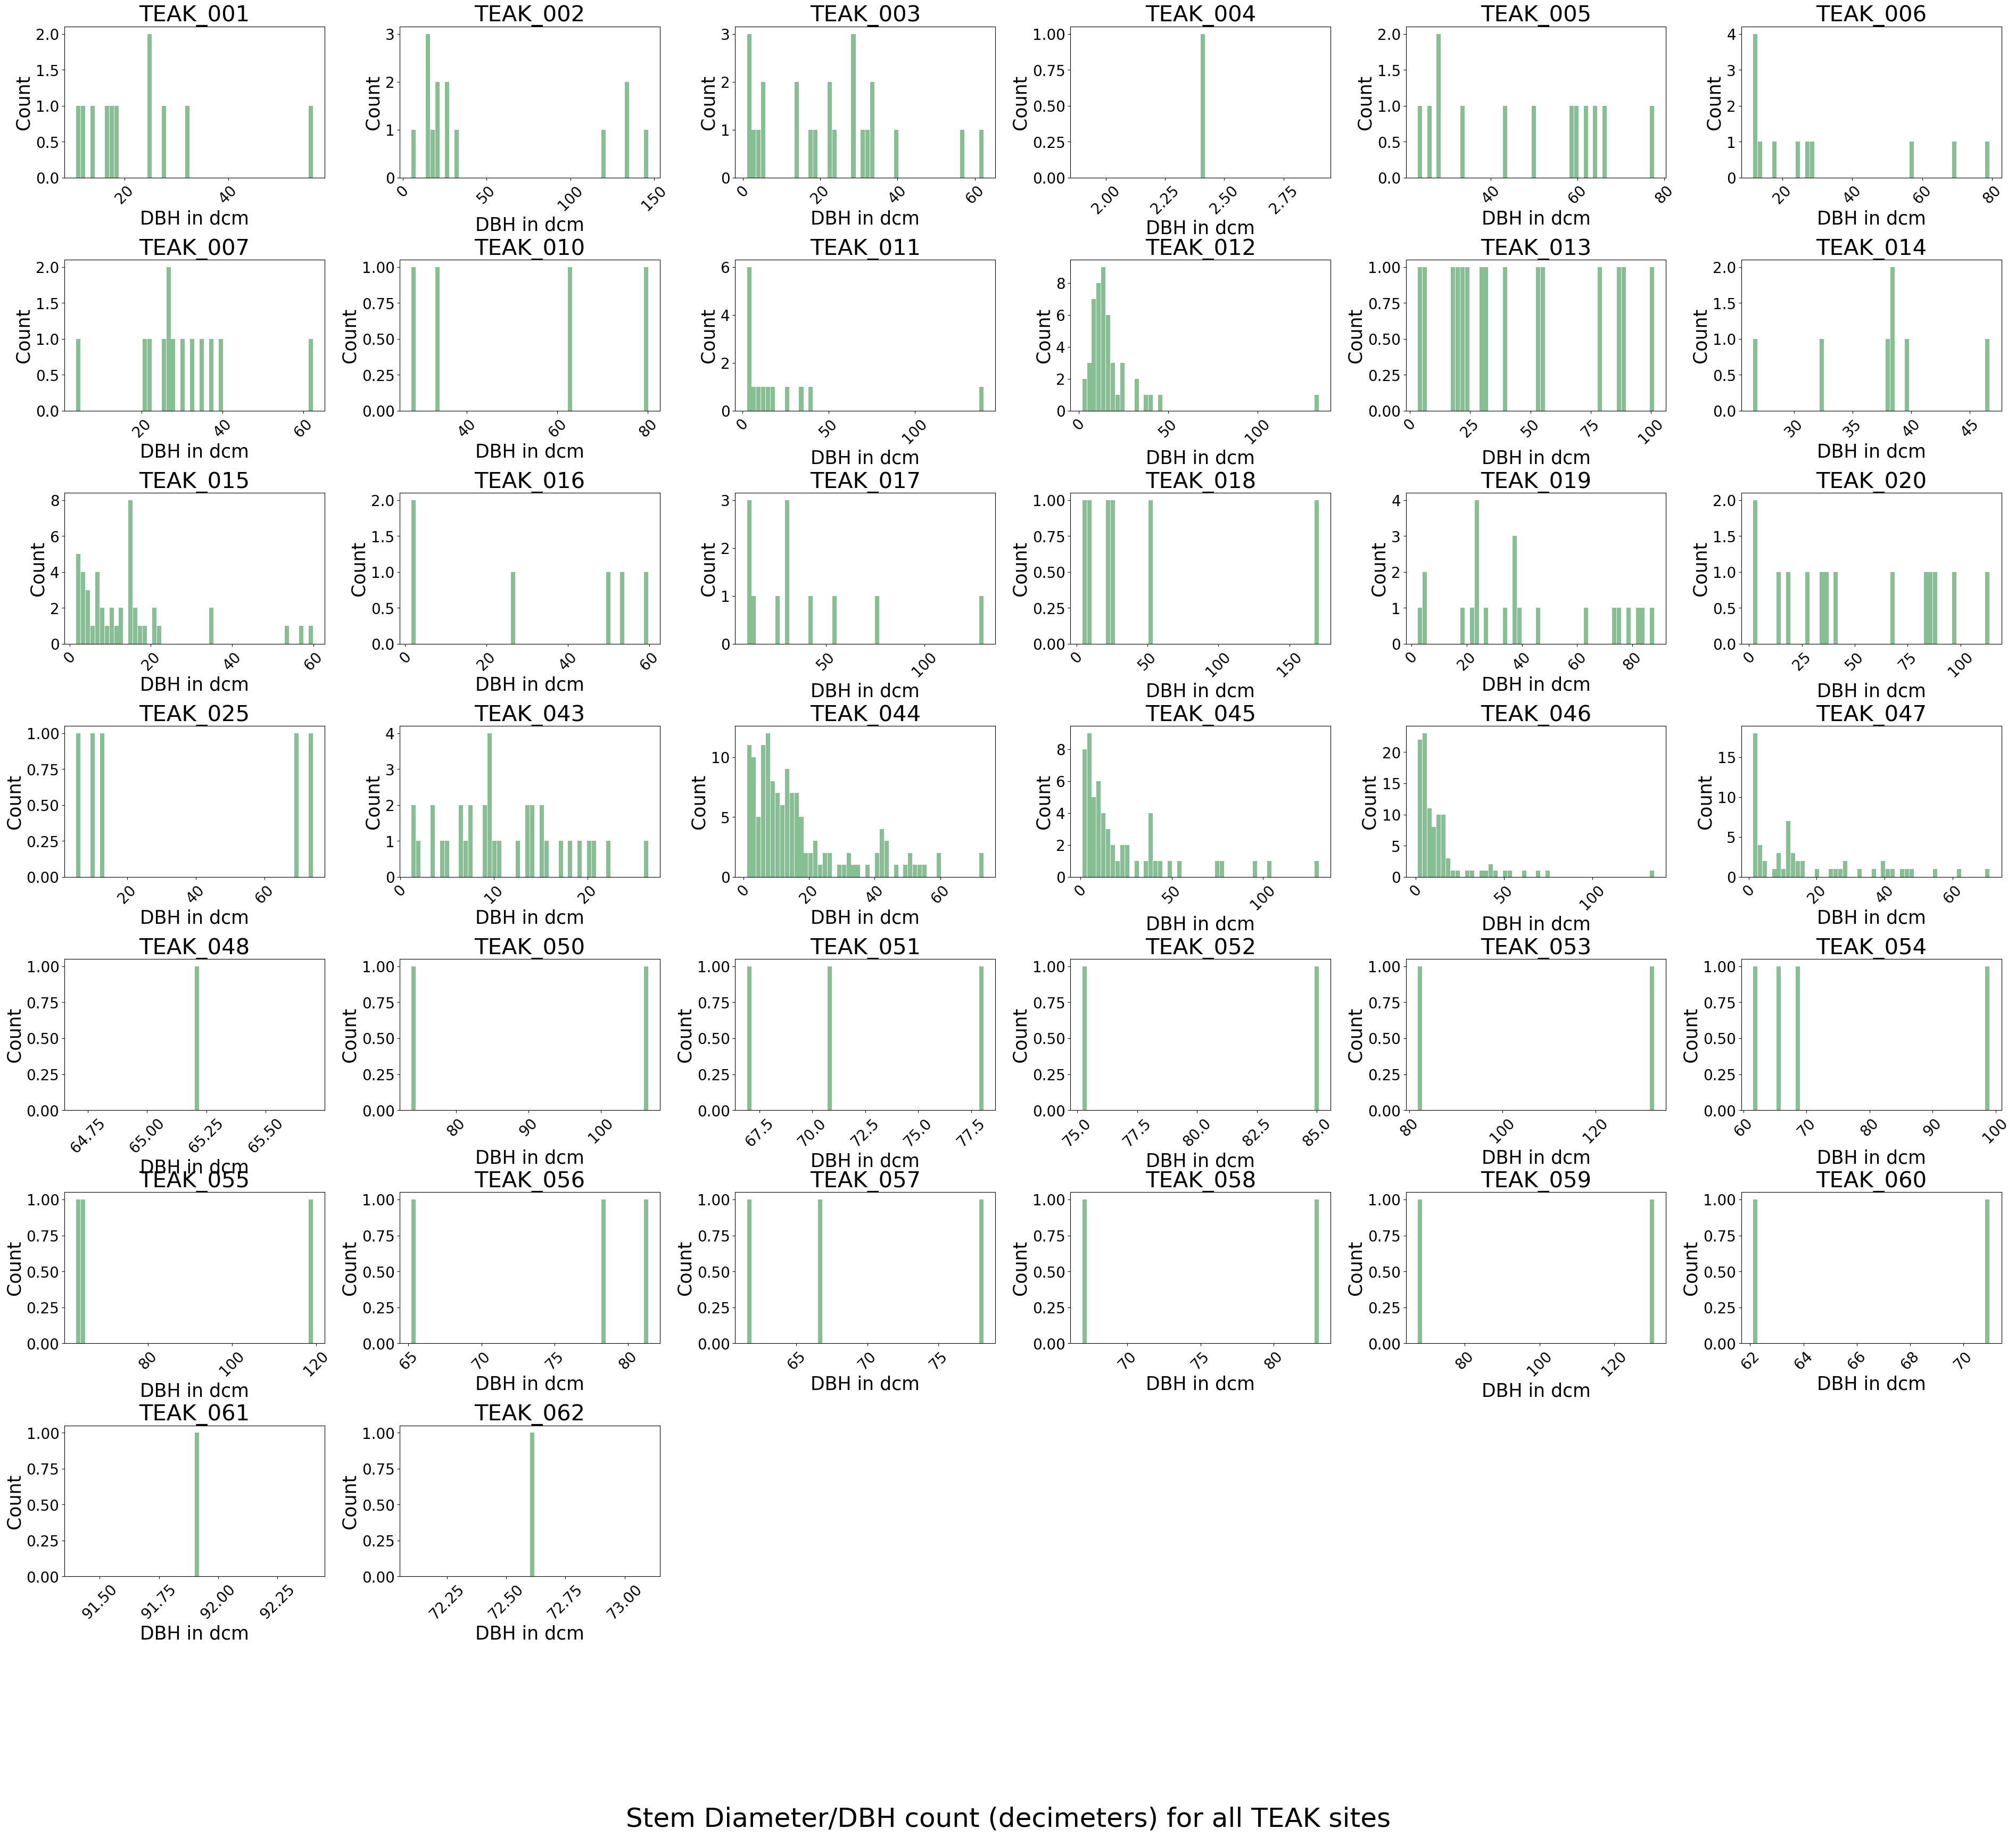

In [52]:
plot_histograms(noshrub_height_nona_df, noshrub_stem_nona_df, date_output_path, shrub=False)

In [1]:
# Adjust pandas display options to show more rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full column width
pd.set_option('display.max_seq_item', None)  # Show full sequences

# Define a function that takes x, y, row, and col and plots on a specific subplot
def plot_on_subplot(axs, x, y, row, col, title, xlabel, ylabel, color, subset_label):
    """Plots a scatter plot on the specified subplot given row, col, x, and y data."""
    axs[row, col].scatter(x, y, color=color, label=subset_label)
    axs[row, col].set_title(title, fontsize=36)
    axs[row, col].set_xlabel(xlabel, fontsize=36)
    axs[row, col].set_ylabel(ylabel, fontsize=36)
    axs[row, col].legend(fontsize=30)
        
def plot_tree_data_relationships_two_df(df1, df2, save_path, plot_type):
    df_concat = pd.concat([df1, df2], axis=0, ignore_index=True)
    
    # Extract relevant data
    df_concat = df_concat.sort_values(by='height')
    df_concat['width_to_height'] = df_concat['crown_width']/df_concat['height']
    df_concat = df_concat[df_concat['width_to_height'] < 1]
    
    df_test = df_concat[df_concat['height'] == 2.7]
    print(df_test[['crown_width', 'height']].to_string())
    df_test2 = df2[df2['height'] == 2.7]
    print(df_test2[['crown_width', 'height']].to_string())
    df_test1 = df1[df1['height'] == 2.7]
    print(df_test1[['crown_width', 'height']].to_string())
    
    # Extract the data needed for plots
    x_existing = df_concat['height']
    y_existing_crown_width = df_concat['crown_width']
    
    x_existing_1 = df1['height']
    y_existing_crown_width_1 = df1['crown_width']
    y_existing_crown_depth_1 = df1['crown_depth']
    y_existing_stem_diameter_1 = df1['stemDiameter']
    
    x_existing_2 = df2['height']
    y_existing_crown_width_2 = df2['crown_width']
    y_existing_crown_depth_2 = df2['crown_depth']
    y_existing_stem_diameter_2 = df2['stemDiameter']

    # Exponential Regression Line for Crown Width and Height
    def exponential_func(x, a, b):
        return (10 ** a) * (x ** b)
    
    popt, _ = curve_fit(exponential_func, x_existing, y_existing_crown_width)
    a, b = popt
    
    print(f"The regression formula is: y = (10^{a:.4f}) * (x^{b:.4f})")
    
    y_pred = exponential_func(x_existing, *popt)
    
    # Calculate R2 and RMSE
    r2 = r2_score(y_existing_crown_width, y_pred)
    rmse = np.sqrt(mean_squared_error(y_existing_crown_width, y_pred))

    figs, axs = plt.subplots(3, 2, figsize=(25, 32))
    
    # Plot 1: Crown Width vs Height
    subplot_1_title = f'Crown width and height relation\n for {plot_type} m\u00B2 plots'
    plot_on_subplot(axs, x_existing_1, y_existing_crown_width_1, 0, 0, subplot_1_title, 'Tree Height (m)', 'Crown Width (m)', 'green', '100 m^2 plots')
    plot_on_subplot(axs, x_existing_2, y_existing_crown_width_2, 0, 0, subplot_1_title, 'Tree Height (m)', 'Crown Width (m)', 'blue', '400 m^2 plots')
    axs[0, 0].plot(x_existing, y_pred, color='red', label=f"y = 10^{a:.2f} * x^{b:.2f} \n with R\u00B2 = {r2:.4f} and RMSE = {rmse:.4f}")
    axs[0, 0].legend(fontsize = '24')

    # Plot 2: Crown depth vs Height
    subplot_2_title = f'Crown depth and height relation\n for {plot_type} m\u00B2 plots'
    plot_on_subplot(axs, x_existing_1, y_existing_crown_depth_1, 0, 1, subplot_2_title, 'Tree Height (m)', 'Crown Depth (m)', 'green', '100 m^2 plots')
    plot_on_subplot(axs, x_existing_2, y_existing_crown_depth_2, 0, 1, subplot_2_title, 'Tree Height (m)', 'Crown Depth (m)', 'blue', '400 m^2 plots')

    # Plot 3: Crown Radius/height vs Height
    subplot_3_title = f'Crown Width/Height ratio and Height relation\n for {plot_type} m\u00B2 plots'
    plot_on_subplot(axs, x_existing_1, (y_existing_crown_width_1/x_existing_1), 1, 0, subplot_3_title, 'Tree Height (m)', 'Crown Width/Height', 'green', '100 m^2 plots')
    plot_on_subplot(axs, x_existing_2, (y_existing_crown_width_2/x_existing_2), 1, 0, subplot_3_title, 'Tree Height (m)', 'Crown Width/Height', 'blue', '400 m^2 plots')

    # Plot 4: Crown Depth/Crown Width vs Height
    subplot_4_title = f'Crown Depth/Crown Width ratio and Height relation\n for {plot_type} m\u00B2 plots'
    plot_on_subplot(axs, x_existing_1, (y_existing_crown_depth_1/y_existing_crown_width_1), 1, 1, subplot_4_title, 'Tree Height (m)', 'Crown Depth/Crown Width', 'green', '100 m^2 plots')
    plot_on_subplot(axs, x_existing_2, (y_existing_crown_depth_2/y_existing_crown_width_2), 1, 1, subplot_4_title, 'Tree Height (m)', 'Crown Depth/Crown Width', 'blue', '400 m^2 plots')
    
    # Plot 5: DBH vs Height
    subplot_5_title = f'DBH and Height relation\n for {plot_type} m\u00B2 plots'
    plot_on_subplot(axs, x_existing_1, y_existing_stem_diameter_1, 2, 0, subplot_5_title, 'Tree Height (m)', 'DBH (dcm)', 'green', '100 m^2 plots')
    plot_on_subplot(axs, x_existing_2, y_existing_stem_diameter_2, 2, 0, subplot_5_title, 'Tree Height (m)', 'DBH (dcm)', 'blue', '400 m^2 plots')
    
    # Plot 6: Crown Depth/Crown Width histogram
    df_concat.hist(column='crown_depth/crown_width', bins=50, ax=axs[2, 1], zorder=2, rwidth=0.9, xrot=45)
    axs[2, 1].set_title('Histogram of Crown Depth / Crown Width', fontsize=36)
    axs[2, 1].set_ylabel('Count', fontsize=36)
    axs[2, 1].set_xlabel('Crown Depth (m)/Crown Width (m) Ratio', fontsize=36)
    
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(os.path.join(save_path, f'TEAK_{plot_type}_height_relations.png'))
    plt.show()

NameError: name 'pd' is not defined

     crown_width  height
306         0.75     2.7
309         0.85     2.7
308         1.35     2.7
24          1.90     2.7
307         1.40     2.7
      crown_width  height
2318         0.75     2.7
2159         1.40     2.7
2405         1.35     2.7
2353         0.85     2.7
2434        11.00     2.7
      crown_width  height
4901          1.9     2.7
The regression formula is: y = (10^-0.1215) * (x^0.6318)


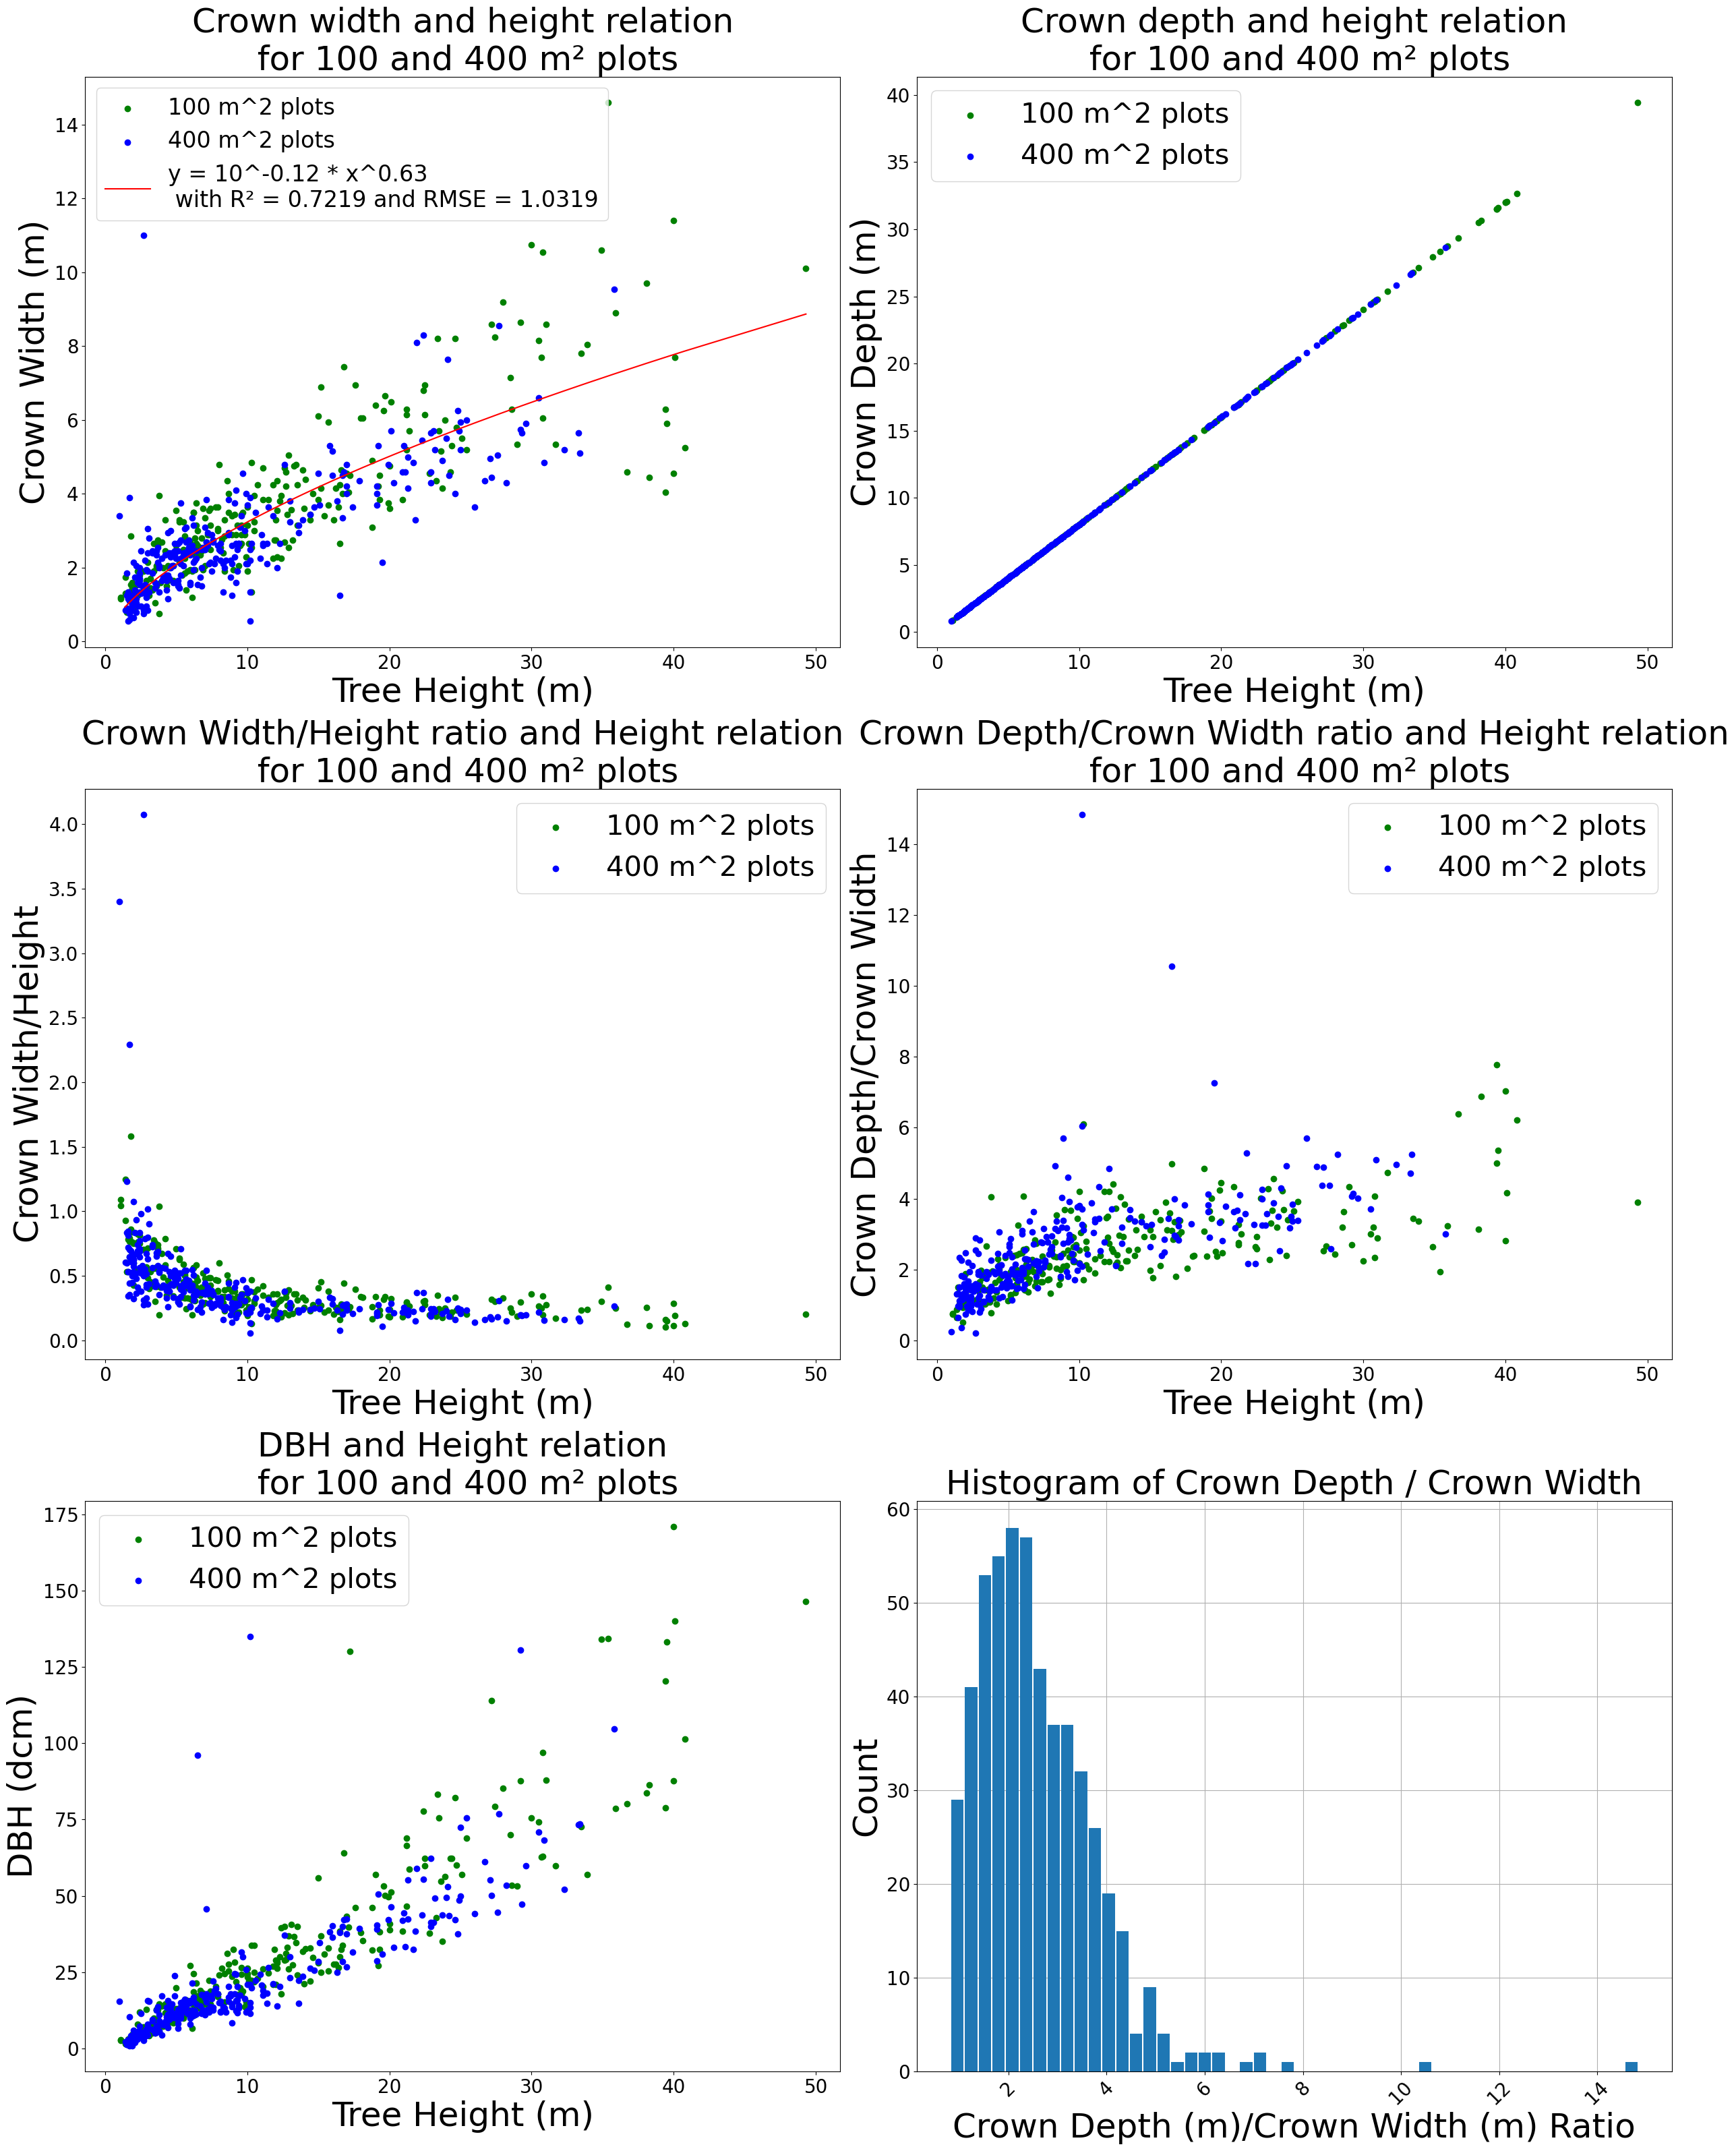

In [153]:
subset = ['TEAK_043', 'TEAK_044', 'TEAK_045', 'TEAK_046', 'TEAK_047']
noshrub_height_nona_100_df_remove_43_to_47 = noshrub_height_nona_100_df[~noshrub_height_nona_100_df['plotID'].isin(subset)]
noshrub_height_nona_400_df_43_to_47 = noshrub_height_nona_400_df[noshrub_height_nona_400_df['plotID'].isin(subset)]

plot_tree_data_relationships_two_df(noshrub_height_nona_100_df_remove_43_to_47, noshrub_height_nona_400_df_43_to_47, date_output_path, "100 and 400")

In [53]:
def plot_trees_per_plot(df, save_path, filename, figsize=(20, 12), title_size=24, label_size=30, tick_size=20):
    ### Plots the number of trees per plot using the given DataFrame.
    
    # Sort DataFrame by 'plotID'
    df = df.sort_values(by=['plotID'])
    
    # Print the number of unique plotIDs
    print(df['plotID'].nunique())
    
    # Get value counts for each plotID and sort by index
    unique_counts = df['plotID'].value_counts().sort_index()
    bar_positions = range(len(unique_counts))
    
    print(bar_positions)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.bar(unique_counts.index, unique_counts.values)
    
    # Set labels and title
    plt.xlabel('Plots', fontsize=label_size)
    plt.ylabel('Number of Trees', fontsize=label_size)
    plt.title('Number of Trees per Plot', fontsize=title_size)
    
    # Set font sizes for ticks
    plt.rcParams['axes.titlesize'] = title_size
    plt.rcParams['axes.labelsize'] = label_size
    plt.rcParams['xtick.labelsize'] = tick_size
    plt.rcParams['ytick.labelsize'] = tick_size
    
    # Set x-tick positions and labels
    plt.xticks([pos - 1 for pos in bar_positions], unique_counts.index, rotation=45, ha='center')

    # Save the figure to a file
    file = filename + ".png"
    plt.savefig(os.path.join(save_path, file))
    print(save_path)

    plt.tight_layout()
    plt.show()

38
range(0, 38)
/data/shared/src/STV/NEON_TEAK/allen/figs/veg_input/2024_09_09


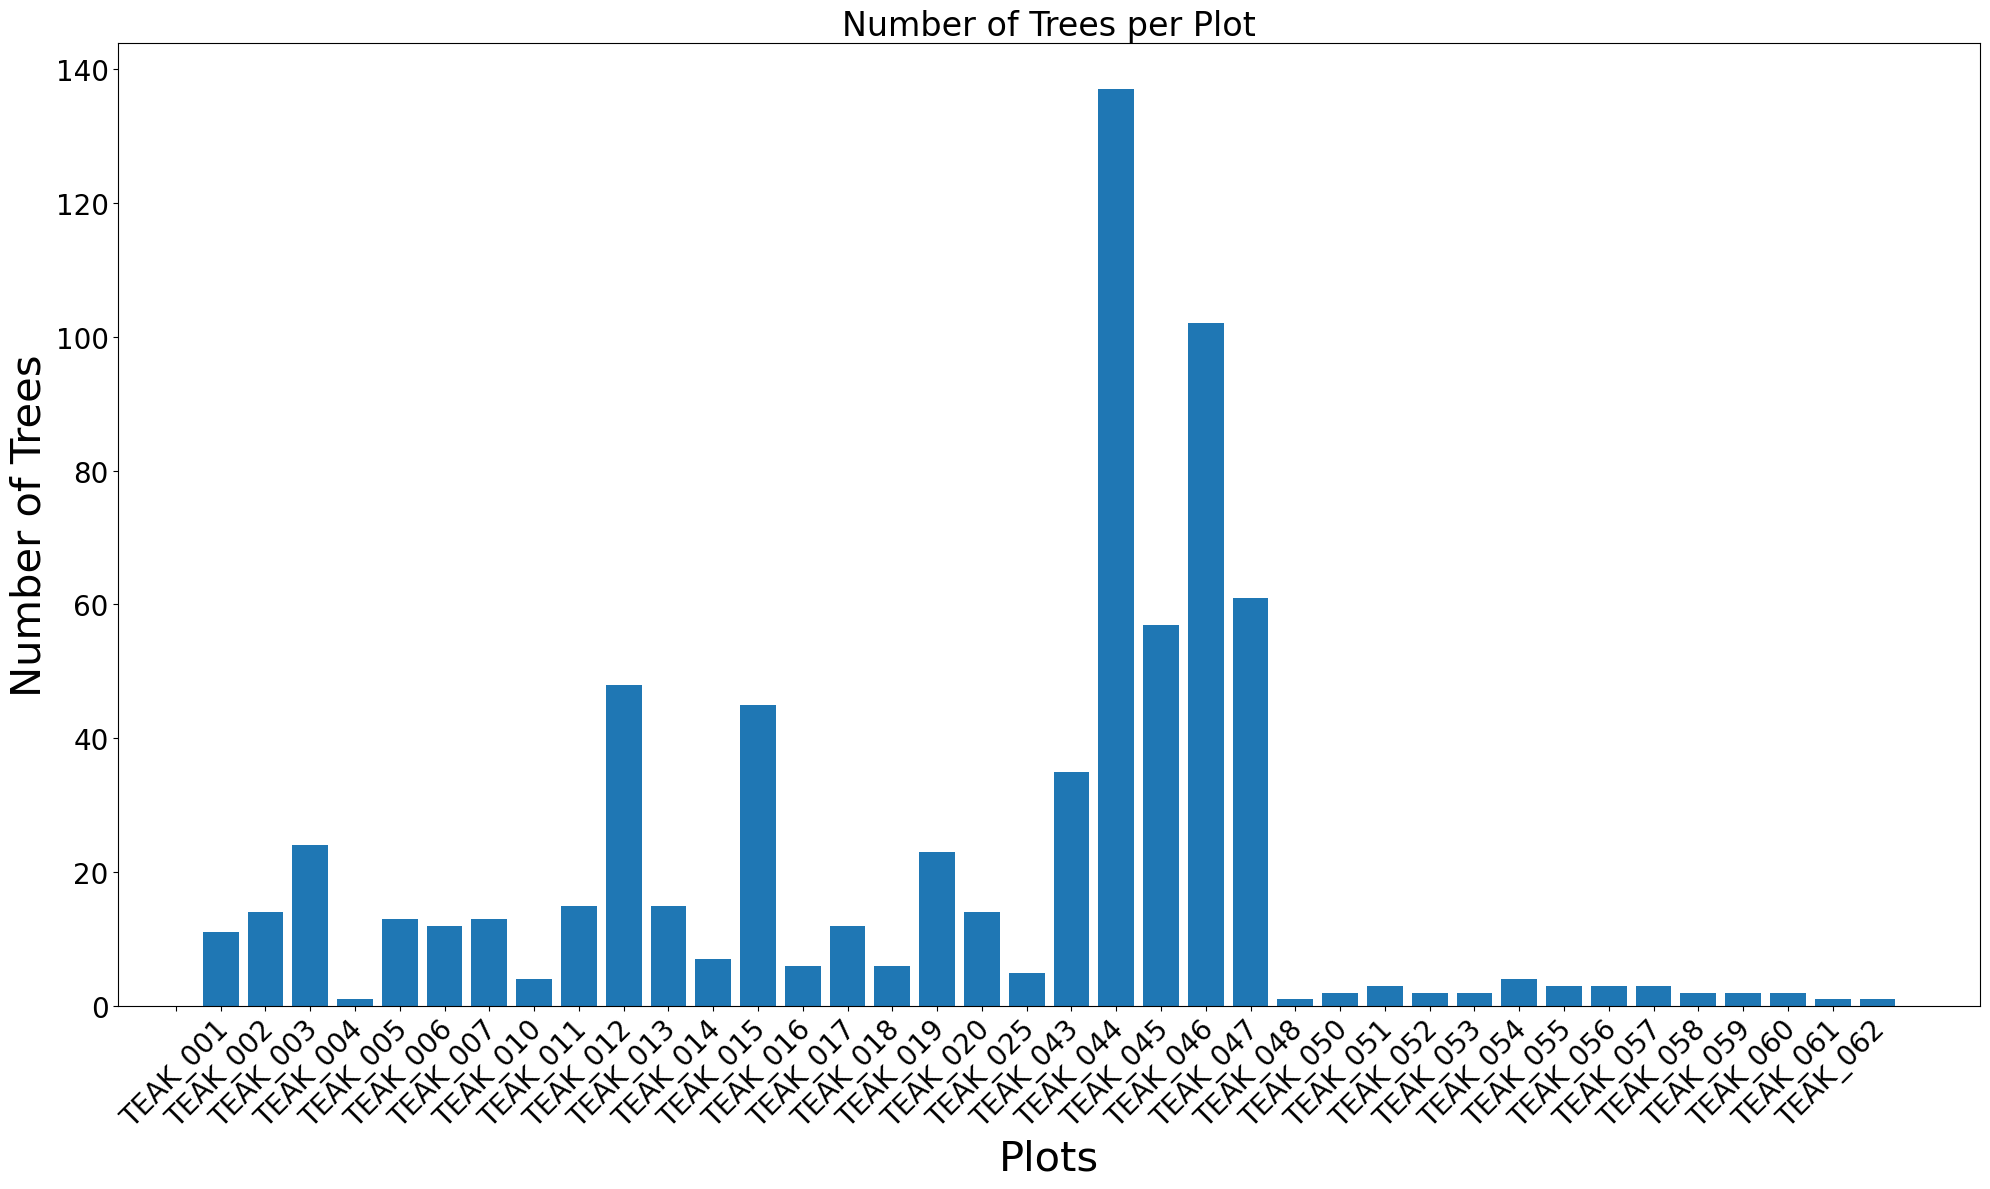

24
range(0, 24)
/data/shared/src/STV/NEON_TEAK/allen/figs/veg_input/2024_09_09


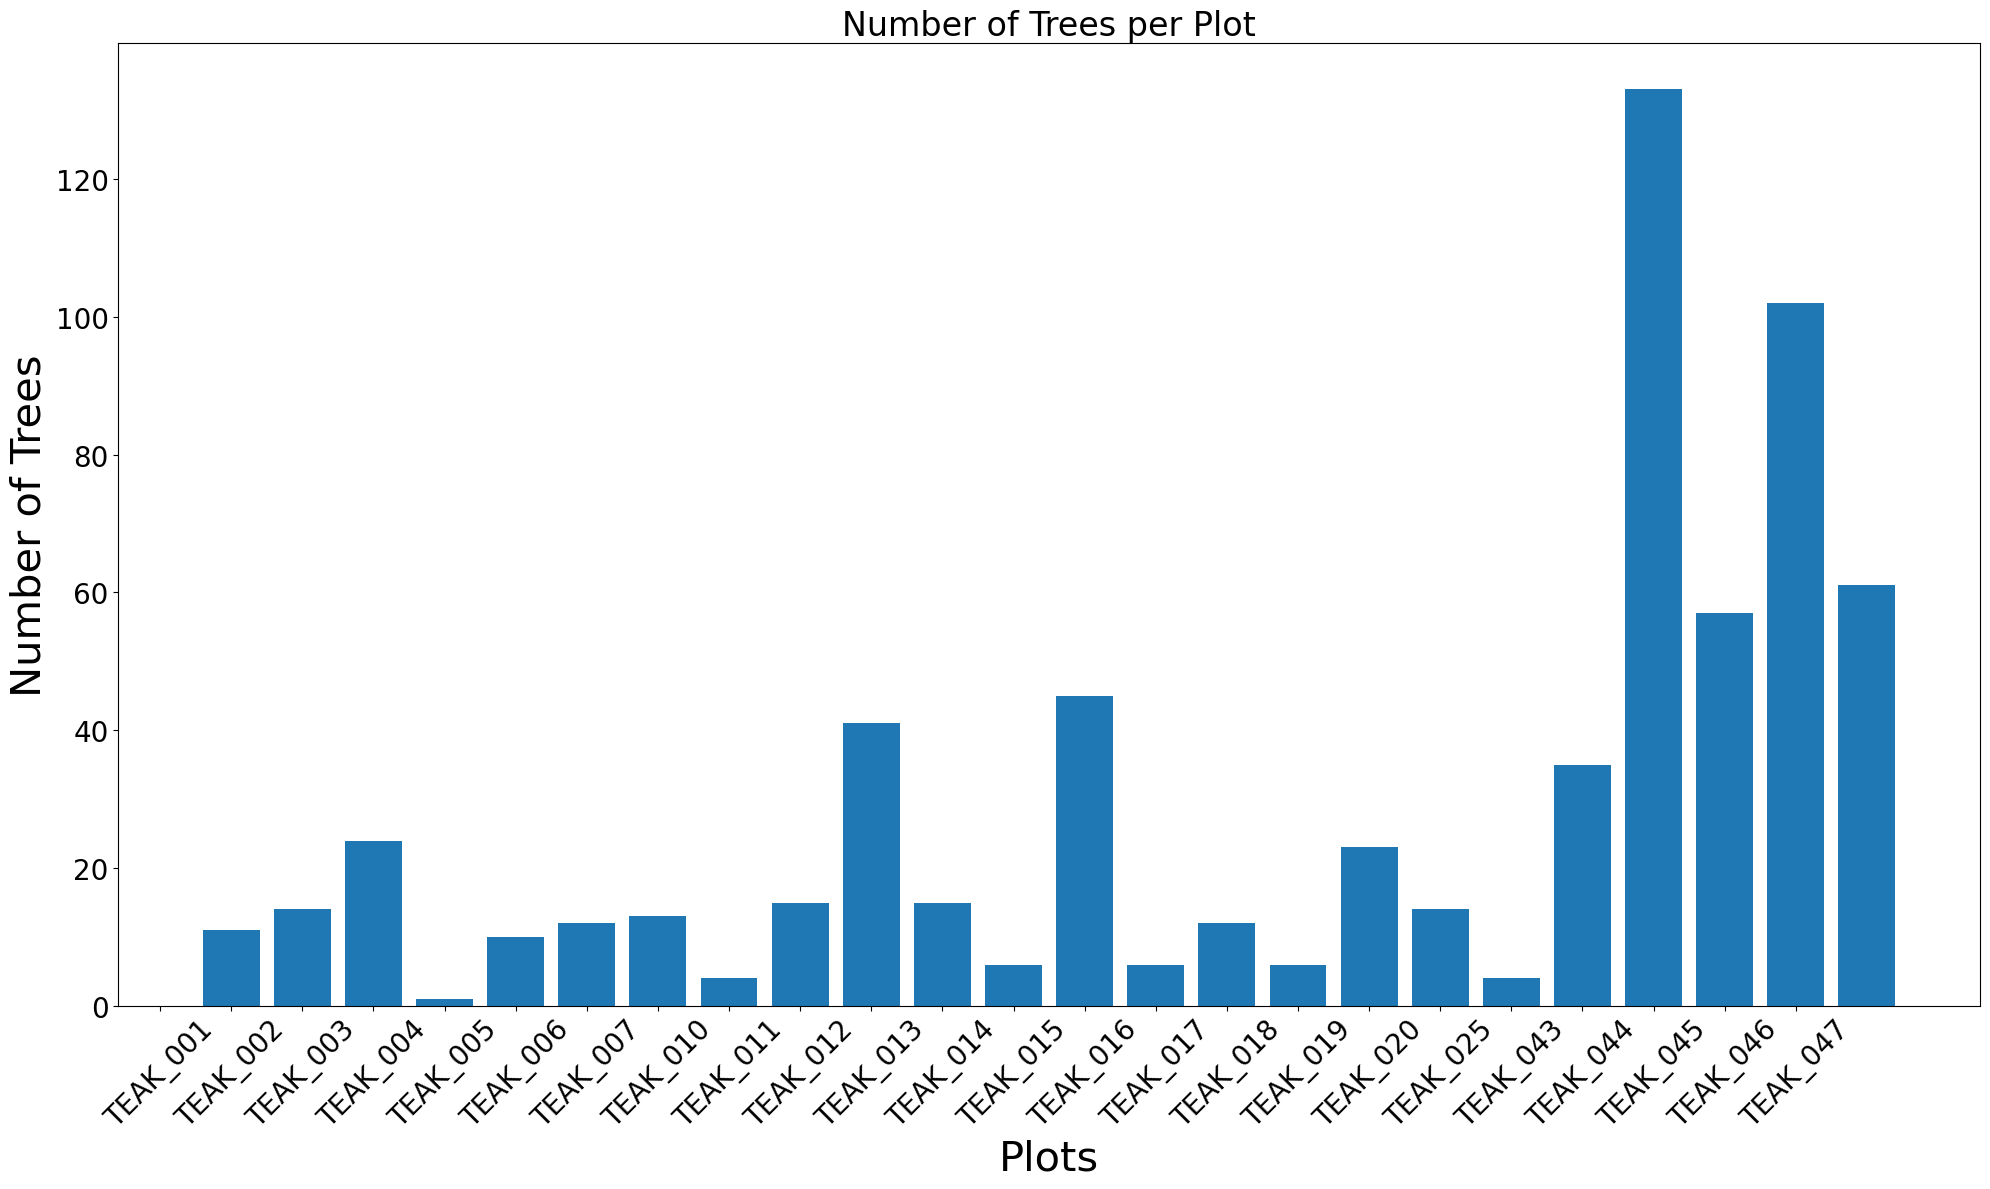

In [54]:
plot_trees_per_plot(noshrub_df, date_output_path, "TEAK_tree_count")
plot_trees_per_plot(noshrub_height_nona_df, date_output_path, "TEAK_tree_count_with_heights")

In [55]:
def plot_tree_density(df, save_path, plot_type):

    df = df.sort_values(by=['plotID'])
    # Filter the DataFrame
    drop_unknown_df = df[df['subplotID'].str.contains('unknown') == False]

    # Calculate unique plotID values
    unique_plotIDs = drop_unknown_df['plotID'].unique()

    # Initialize a dictionary to store the normalized counts for each plotID
    normalized_counts = {}

    # Iterate over unique plotID values
    for plot_id in unique_plotIDs:
        # Get corresponding group DataFrame
        with_unknowns_df = df[df['plotID'] == plot_id]
        without_unknowns_df = drop_unknown_df[drop_unknown_df['plotID'] == plot_id]

        # Calculate count of unique values in 'subplotID'
        subplot_unique_count = len(without_unknowns_df['subplotID'].unique())

        # Calculate count divided by (number of uniques in subplotID * 100)
        normalized_count = len(with_unknowns_df['subplotID']) / (400)

        # Separate data based on whether 'subplotID' contains '_100' or '_400'
        df_100 = with_unknowns_df[with_unknowns_df['subplotID'].str.contains('_100')]
        df_400 = with_unknowns_df[with_unknowns_df['subplotID'].str.contains('_400')]

        # Calculate normalized counts
        normalized_count_100 = len(df_100['subplotID']) / 400  # Divide by 100 for '_100'
        normalized_count_400 = len(df_400['subplotID']) / 800  # Divide by 400 for '_400'

        # Combine the counts
        total_normalized_count = normalized_count_100 + normalized_count_400
        
        # Store normalized count for the plotID
        normalized_counts[plot_id] = total_normalized_count

    # Set up the plot
    plt.figure(figsize=(20, 18))
    plt.bar(range(len(normalized_counts)), normalized_counts.values())
    plt.xlabel(f'{plot_type} m² Plots')
    plt.ylabel('Tree Count per m²')
    plt.title('Tree Density')

    plt.rcParams['axes.titlesize'] = 24
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20

    plt.xticks(range(len(normalized_counts)), normalized_counts.keys(), rotation=45, ha='right')

    # Save the figure to a file
    filename = f'TEAK_tree_density_{plot_type}.png'
    plt.savefig(os.path.join(save_path, filename))

    # Displaying the plot
    plt.tight_layout()
    plt.show()

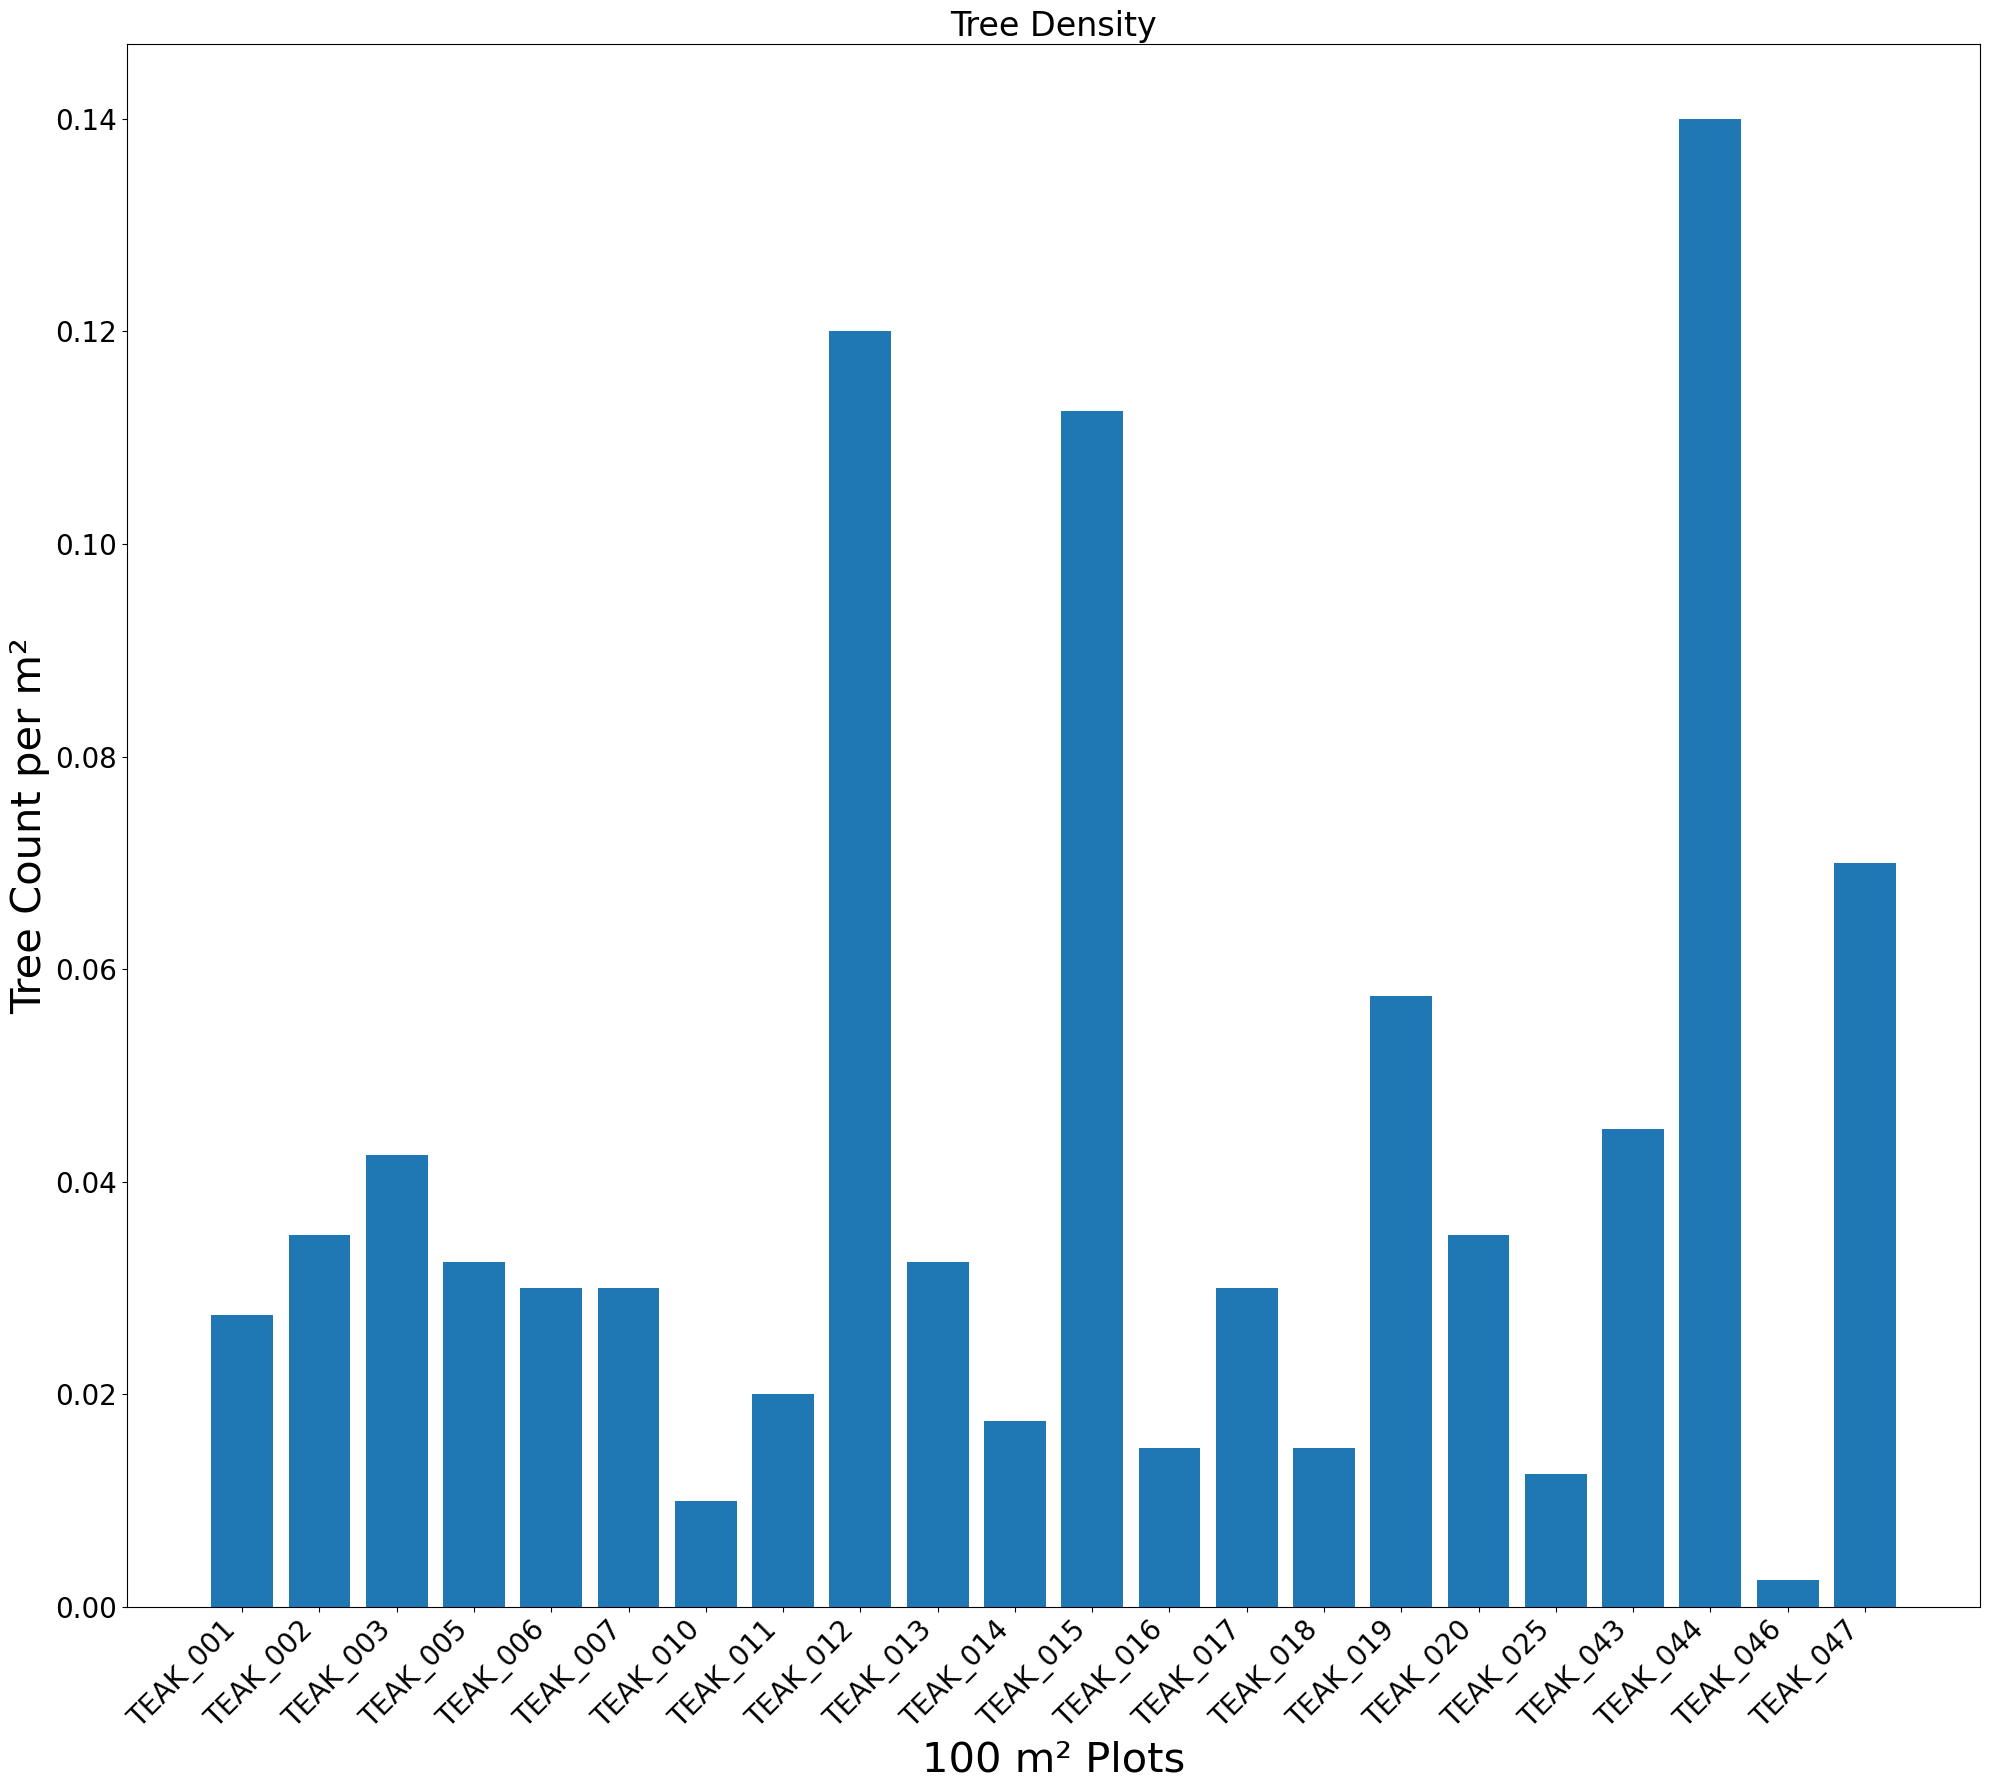

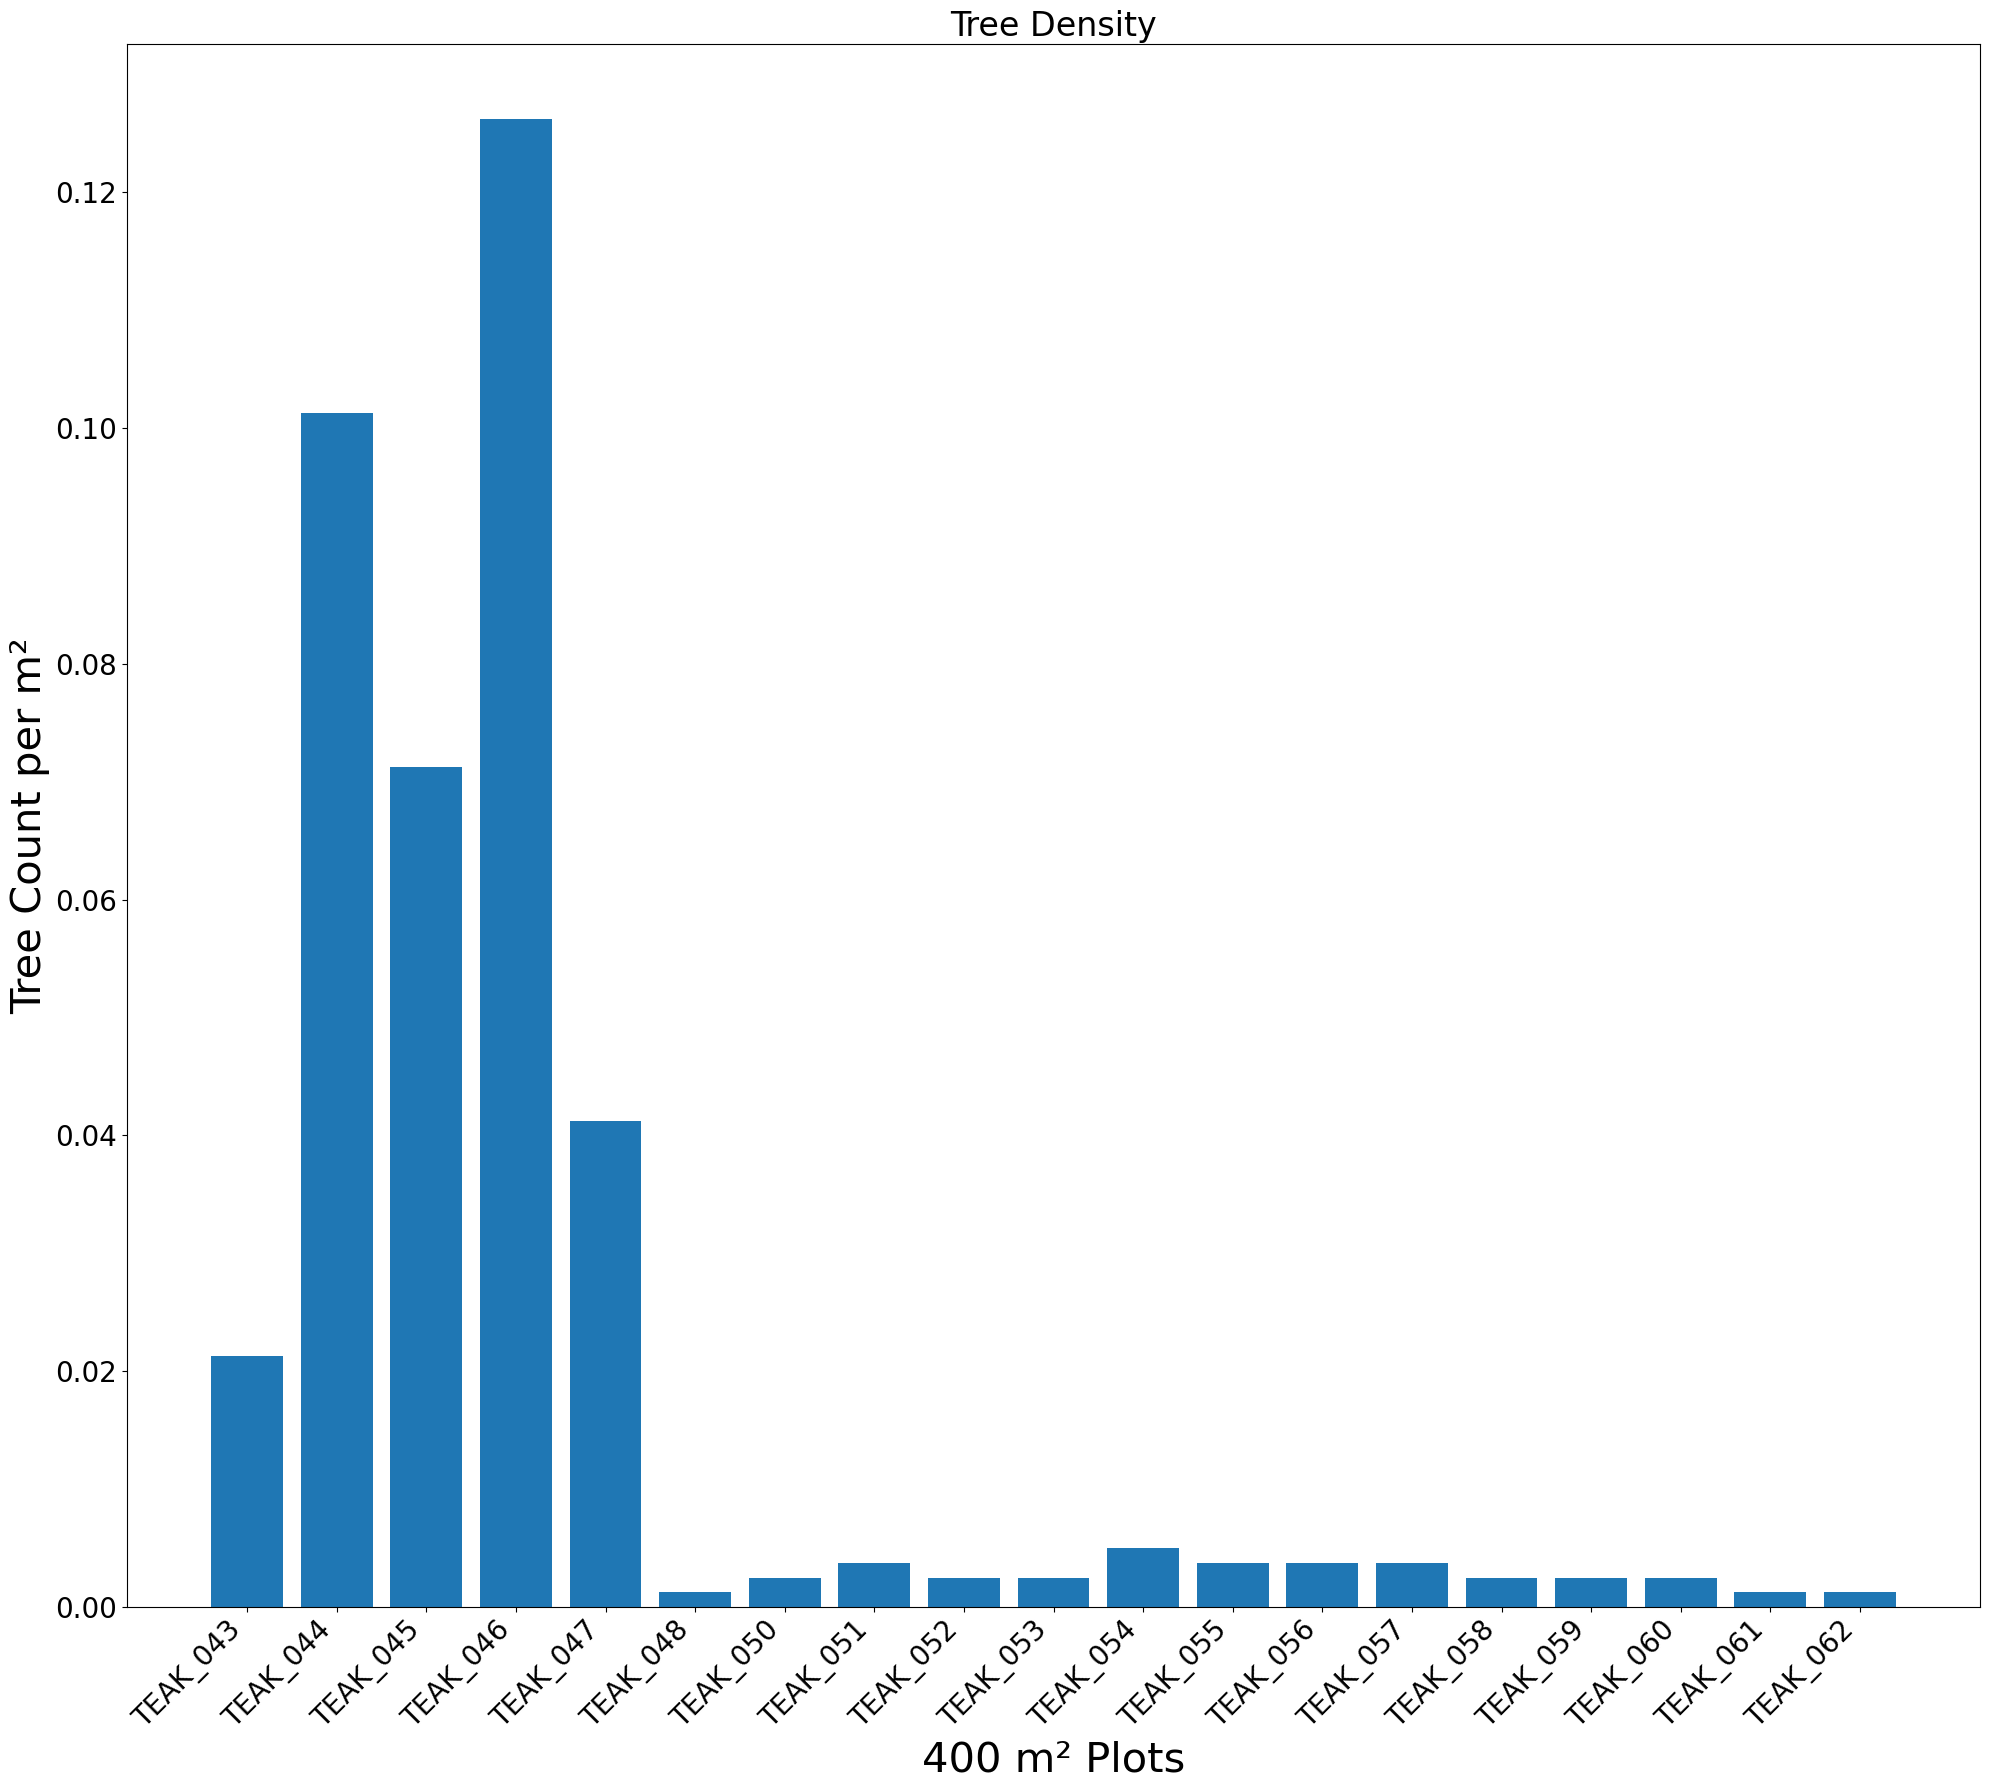

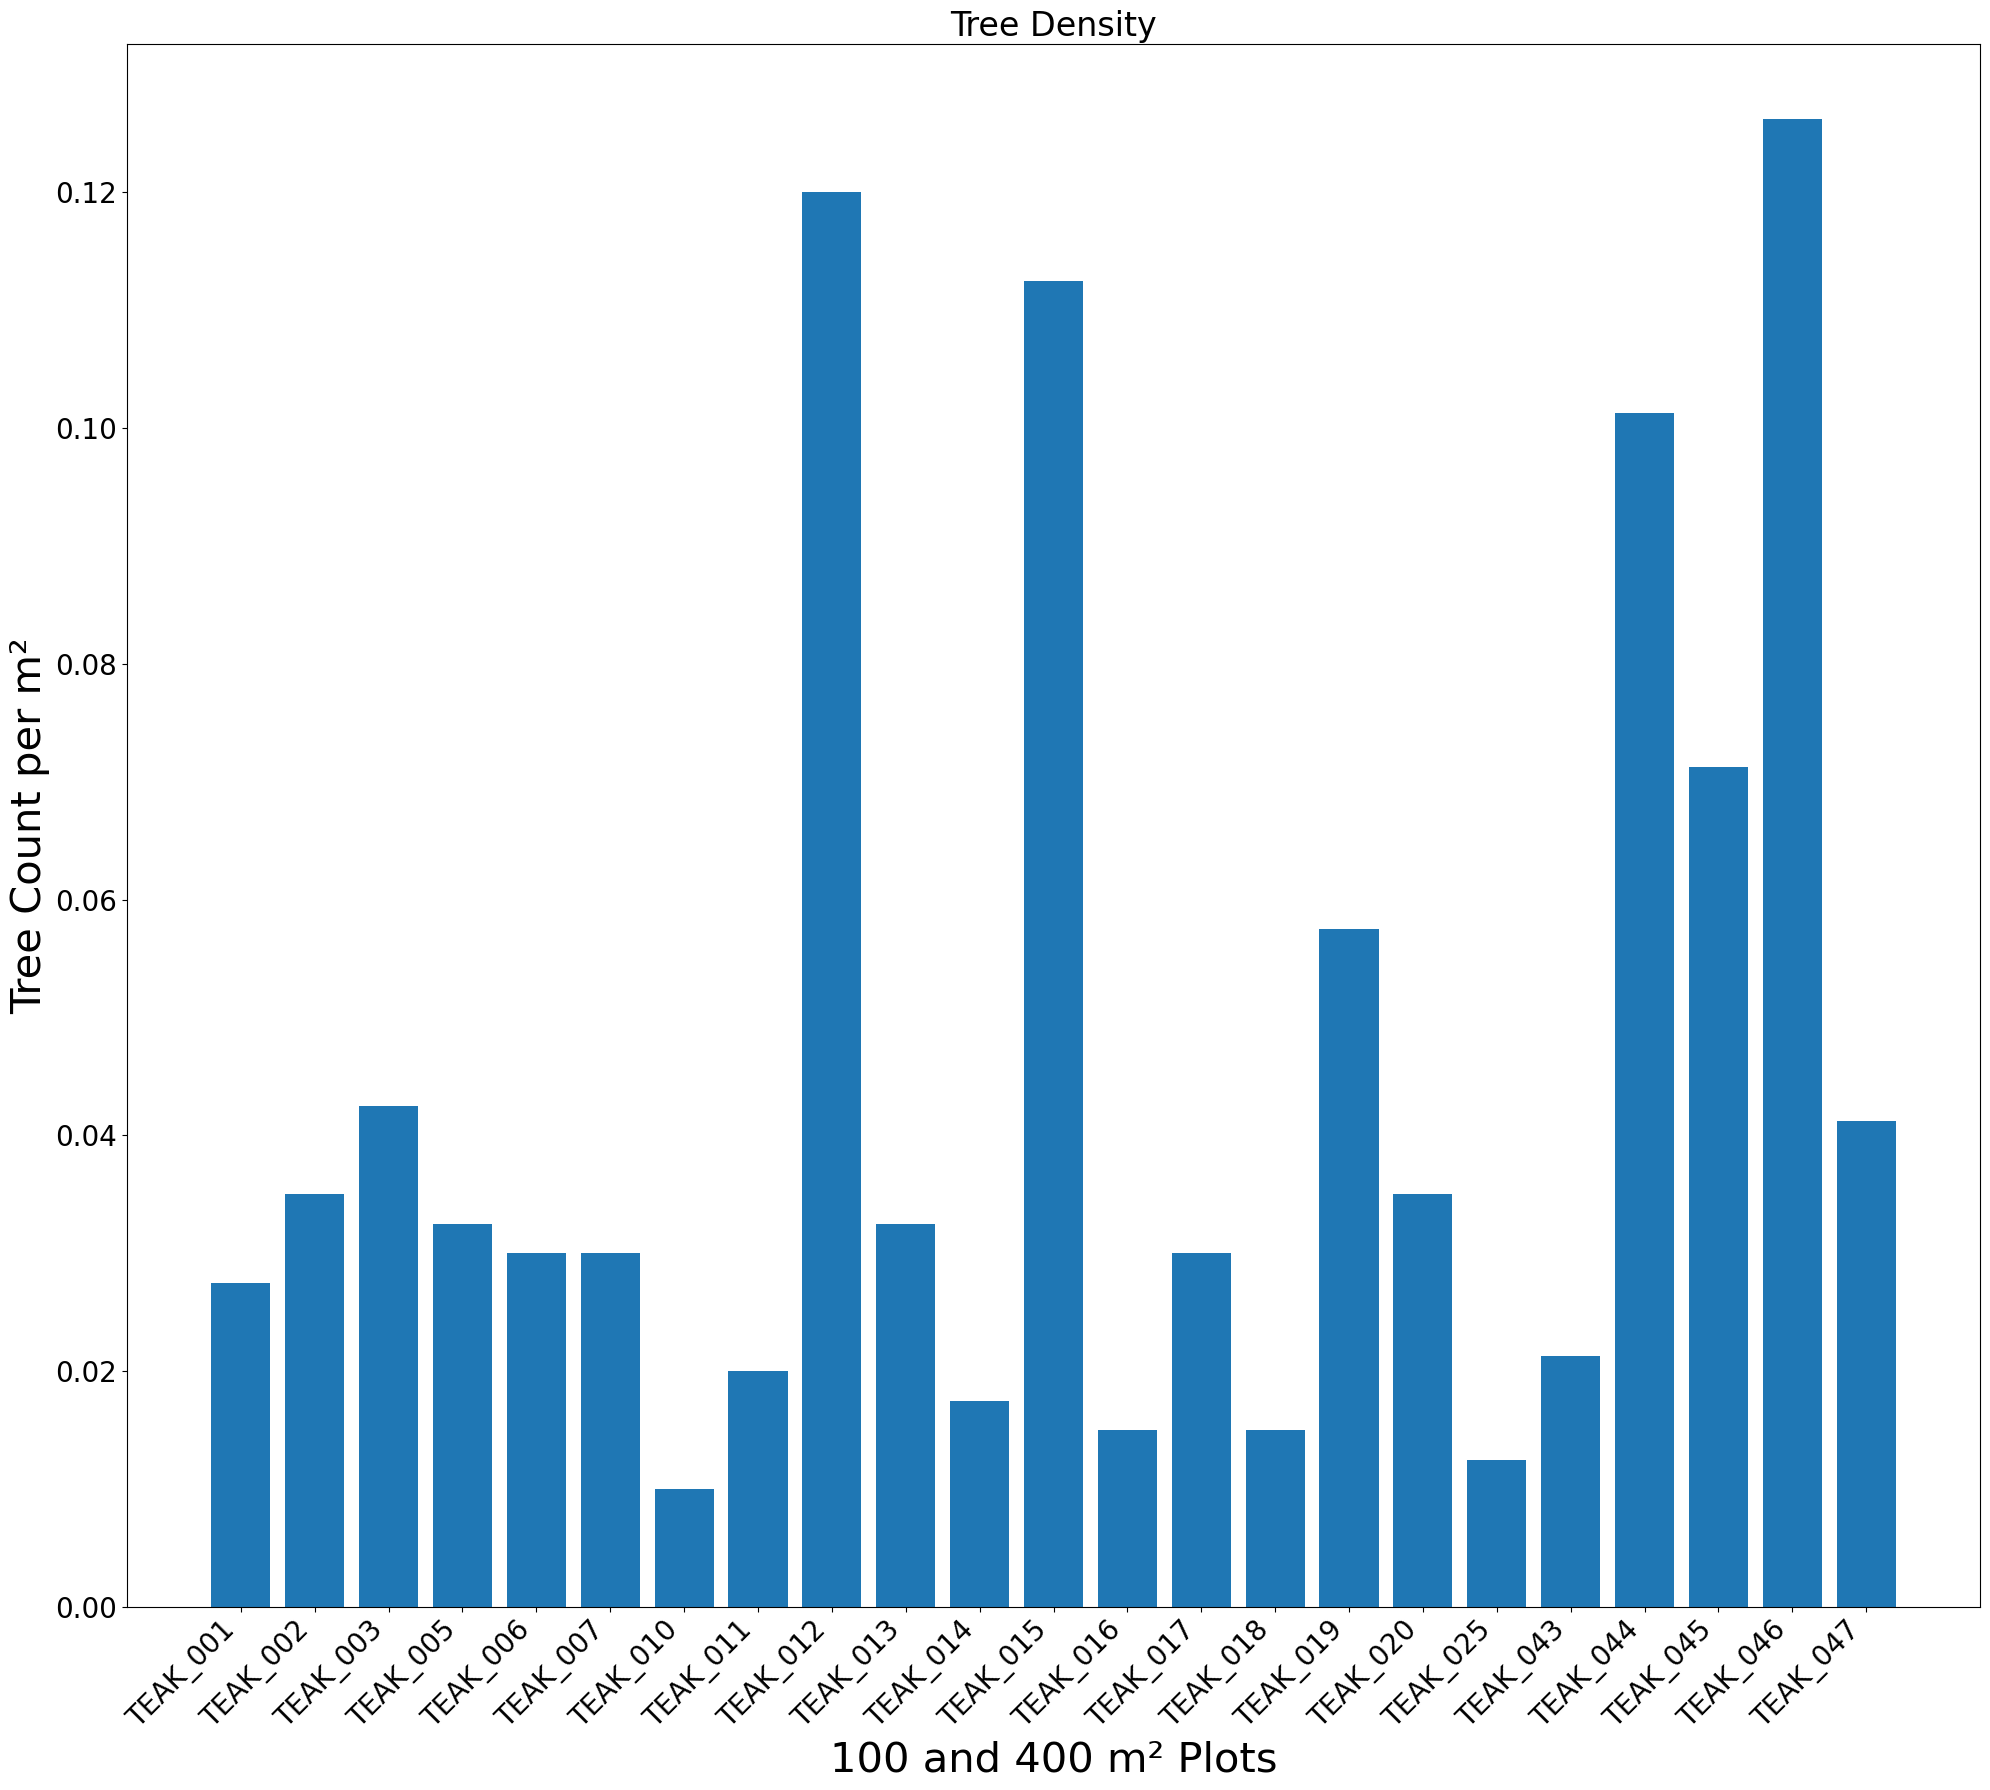

In [56]:
subset = ['TEAK_043', 'TEAK_044', 'TEAK_045', 'TEAK_046', 'TEAK_047']

noshrub_100_df_drop_43_to_47 = noshrub_100_df[~noshrub_100_df['plotID'].isin(subset)]
noshrub_400_df_drop_43_to_47 = noshrub_400_df[noshrub_400_df['plotID'].isin(subset)]
noshrub_all_df = pd.concat([noshrub_100_df_drop_43_to_47, noshrub_400_df_drop_43_to_47], axis=0, ignore_index=True)

plot_tree_density(noshrub_100_df, date_output_path, "100")
plot_tree_density(noshrub_400_df, date_output_path, "400")
plot_tree_density(noshrub_all_df, date_output_path, "100 and 400")

In [58]:
def find_tree_locations(dataframe, map_tag_df, subplot_loc_df, utm_zone=11, southern_hemisphere=False):
    # Initialize a dictionary to store the normalized counts for each plotID
    utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84', south=southern_hemisphere)

    # Merge the dataframe with map_tag_df
    merged_df = pd.merge(dataframe, map_tag_df, on='individualID', how='left')

    # Handle NA values in 'pointID' before conversion
    # Replace NA values with a placeholder, e.g., '0', and then convert to int and back to string
    merged_df['pointID'] = merged_df['pointID'].fillna('999').astype(int).astype(str)

    # Convert 'pointID' to integer and then to string to ensure consistent formatting
    merged_df['pointID'] = merged_df['pointID'].astype(int).astype(str)
    
    merged_df = merged_df.rename(columns={'namedLocation_x': 'namedLocation'})
    
    # Create plotptid column
    merged_df['plotptid'] = merged_df['namedLocation'] + "." + merged_df['pointID'].astype(str)
    
    # Initialize the columns
    merged_df[['stemAzimuthRad', 'easting', 'northing', 'latitude', 'longitude']] = np.NaN

    for index, row in merged_df.iterrows():
        plotptid = row['plotptid']
        found = (subplot_loc_df['locationName'] == plotptid).any()
        if found:
            location_by_individual = subplot_loc_df[subplot_loc_df['locationName'] == plotptid]

            stemAzimuthRad = (row['stemAzimuth'] * np.pi) / 180
            easting = float(location_by_individual['easting'].values[0]) + float(row['stemDistance']) * np.sin(stemAzimuthRad)
            northing = float(location_by_individual['northing'].values[0]) + float(row['stemDistance']) * np.cos(stemAzimuthRad)
            longitude, latitude = utm_proj(easting, northing, inverse=True)

            merged_df.at[index, 'stemAzimuthRad'] = stemAzimuthRad
            merged_df.at[index, 'easting'] = easting
            merged_df.at[index, 'northing'] = northing
            merged_df.at[index, 'latitude'] = latitude
            merged_df.at[index, 'longitude'] = longitude

    # Drop rows with NA in 'stemDistance' and 'stemAzimuth'
    cleaned_df = merged_df.dropna(subset=['stemDistance', 'stemAzimuth'])
    
    # Define the columns to be returned
    columns_to_export = ['plotptid', 'namedLocation', 'date_x', 'plotID_x', 'subplotID', 'individualID', 'growthForm', 'plantStatus', 'stemDiameter', 'height', 'baseCrownHeight',
                         'maxCrownDiameter', 'ninetyCrownDiameter', 'crown_radius', 'crown_width', 'crown_depth', 'taxonID', 'scientificName', 'plotptid', 
                         'stemDistance', 'stemAzimuth', 'stemAzimuthRad', 'easting', 'northing', 'latitude', 'longitude']
    
    # Filter the columns for both dataframes
    cleaned_df = cleaned_df[columns_to_export]
    merged_df = merged_df[columns_to_export]
    
    # Return both dataframes
    return cleaned_df, merged_df

In [59]:
map_tag_df = pd.read_csv(map_tag_csv_path)
subplot_loc_df = pd.read_csv(subplot_loc_csv_path)

map_tag_df = map_tag_df[map_tag_df['date'].str.contains('2015') == False]

# has_duplicates = noshrub_100_df['individualID'].duplicated().any()
# print("Duplicates present:", has_duplicates)
# has_duplicates = noshrub_400_df['individualID'].duplicated().any()
# print("Duplicates present:", has_duplicates)

tree_locations_only_100, tree_locations_full_100 = find_tree_locations(noshrub_100_df, map_tag_df, subplot_loc_df)
tree_locations_only_400, tree_locations_full_400 = find_tree_locations(noshrub_400_df, map_tag_df, subplot_loc_df)

# has_duplicates = tree_locations_only_100['individualID'].duplicated().any()
# print("Duplicates present:", has_duplicates)
# has_duplicates = tree_locations_only_400['individualID'].duplicated().any()
# print("Duplicates present:", has_duplicates)

# Define file paths
tree_locations_only_100_path = os.path.join(date_output_path, 'TEAK_entries_perplot_location_only_100.csv')
tree_locations_full_100_path = os.path.join(date_output_path, 'TEAK_entries_perplot_full_100.csv')
tree_locations_only_400_path = os.path.join(date_output_path, 'TEAK_entries_perplot_location_only_400.csv')
tree_locations_full_400_path = os.path.join(date_output_path, 'TEAK_entries_perplot_full_400.csv')

# Save DataFrames to CSV
tree_locations_only_100.to_csv(tree_locations_only_100_path, index=False)
tree_locations_full_100.to_csv(tree_locations_full_100_path, index=False)
tree_locations_only_400.to_csv(tree_locations_only_400_path, index=False)
tree_locations_full_400.to_csv(tree_locations_full_400_path, index=False)